### Data Exploration


a) Let's start by loading the data and checking how it looks like


In [1]:
import pandas as pd

In [2]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

X_test = pd.read_csv("X_test.csv")

In [3]:
def check_missing_values(df: pd.DataFrame, df_name: str) -> None:
    if df.isnull().values.any():
        print(f"There are some missing values in {df_name} dataframe.")
    else:
        print(f"There aren't any missing values in {df_name} dataframe")


def check_types(df: pd.DataFrame, df_name: str) -> None:
    filtered = df.select_dtypes(exclude=["float64"])
    print(
        f"Columns of {df_name} dataframe with non-float type: {list(filtered.columns)}"
    )

In [4]:
X_train.info()

print()
check_types(X_train, "X_train")
print()
check_missing_values(X_train, "X_train")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Columns: 9000 entries, LINC01409 to AC007325.4
dtypes: float64(9000)
memory usage: 260.5 MB

Columns of X_train dataframe with non-float type: []

There aren't any missing values in X_train dataframe


In [5]:
y_train.info()

print()
check_types(y_train, "y_train")
print()
check_missing_values(y_train, "y_train")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        3794 non-null   int64  
 1   Expected  3794 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.4 KB

Columns of y_train dataframe with non-float type: ['Id']

There aren't any missing values in y_train dataframe


In [6]:
X_test.info()

print()
check_types(X_test, "X_test")
print()
check_missing_values(X_test, "X_test")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Columns: 9000 entries, LINC01409 to AC007325.4
dtypes: float64(9000)
memory usage: 46.0 MB

Columns of X_test dataframe with non-float type: []

There aren't any missing values in X_test dataframe


#### We can notice that:

- There are 9000 independent variables in both train and test X dataframes
- There are 3794 observations in the training set (both X and y), and 670 observations in the test set
- All relevant variables have float type, there's no need to convert them. Only `Id` in the y_train dataframe has int type, but as it's just an identifier of the observation, we don't need to worry about it
- There is no missing data in any dataframe


b) Now let's investigate the empirical distribution of the response variable, we'll do it in two steps:

1. Calculate some basic statistics
2. Present a histogram + density estimator plot


In [7]:
stats = y_train["Expected"].describe()
print(stats)

count    3794.000000
mean        0.791096
std         0.860856
min         0.000000
25%         0.000000
50%         0.311748
75%         1.662514
max         2.860416
Name: Expected, dtype: float64


In [8]:
print(f"CV coefficient: {stats['std'] / stats['mean']:.4f}")

CV coefficient: 1.0882


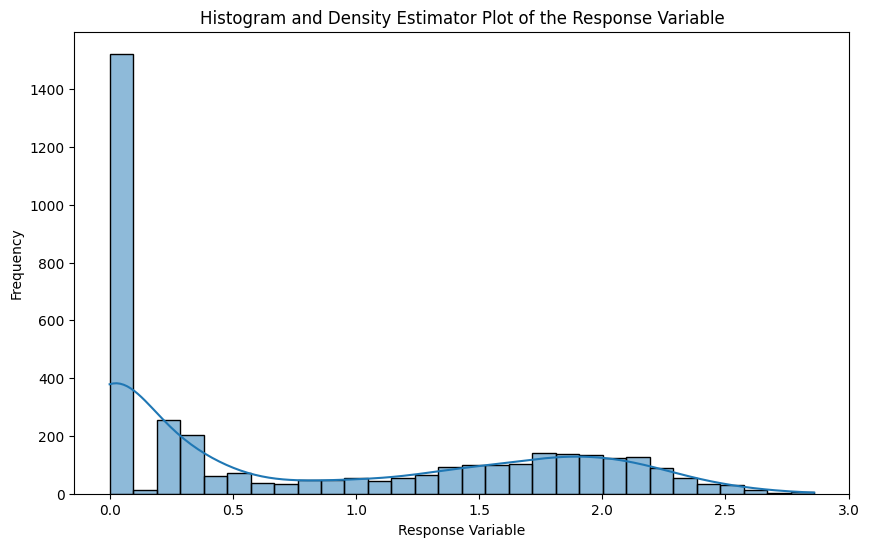

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y_train["Expected"], kde=True, bins=30)
plt.title("Histogram and Density Estimator Plot of the Response Variable")
plt.xlabel("Response Variable")
plt.ylabel("Frequency")
plt.show()

In [10]:
print(
    f"Fraction of observations with response variable equal to 0: {(y_train['Expected'] == 0).sum() / y_train['Expected'].count():.4f}"
)

Fraction of observations with response variable equal to 0: 0.4014


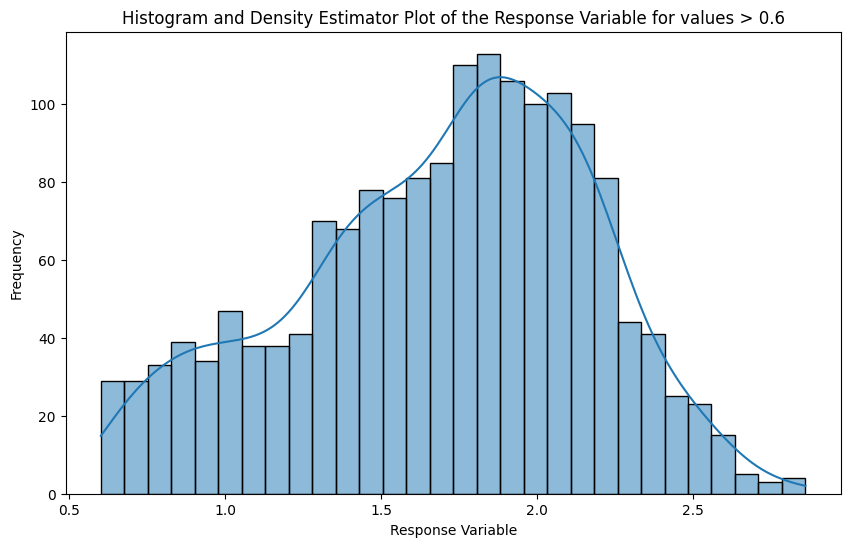

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train["Expected"][y_train["Expected"] > 0.6], kde=True, bins=30)
plt.title(
    "Histogram and Density Estimator Plot of the Response Variable for values > 0.6"
)
plt.xlabel("Response Variable")
plt.ylabel("Frequency")
plt.show()

#### Key notes:

- Values range from 0 to around 2.86
- Mean value is much higher than the median value, which suggests that the distribution is heavily right-skewed (which is also confirmed by the above histogram)
- CV coefficient equal to around 1.0882 can be considered as a high variability of data, as the standard deviation is higher than the mean value
- There's a huge part of observations for which the response variable is equal to 0, it's around 40%
- If we take a look only at values > 0.6, we can see they're more normally distributed (however we can't say it's a perfect normal distribution)


c) Finally let's analyze the correlation coefficients, looking for potentially significant variables and multicolinearity amongst them


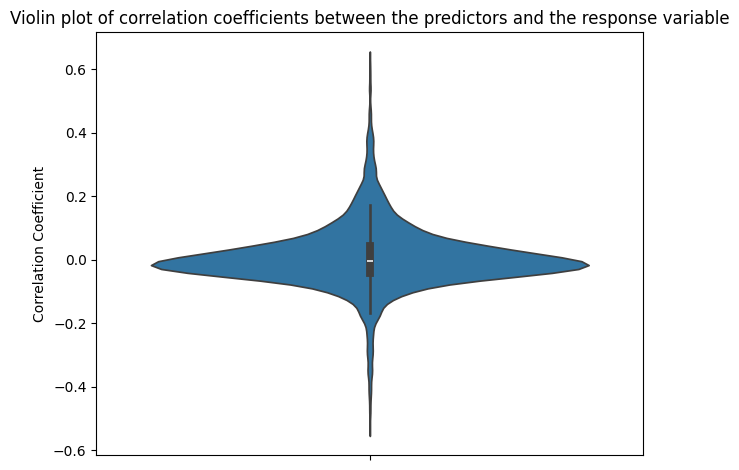

In [12]:
correlations = X_train.corrwith(y_train["Expected"])

sns.violinplot(correlations)
plt.title(
    f"Violin plot of correlation coefficients between the predictors and the response variable"
)
plt.ylabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

The result we got is quite predictable - amongst all the 9000 variables only a small part of them is potentially significant. The correlation coefficient for majority of them is around 0, which suggests no significant association.


Let's now search for multicolinearity amongst the most correlated variables:


FCN1        0.623565
VCAN        0.618140
S100A9      0.598952
CD36        0.597179
FTH1        0.581045
              ...   
TMEM176B    0.376995
PLAUR       0.376783
GNLY        0.376133
CD3G        0.375530
TGFBI       0.374922
Length: 100, dtype: float64


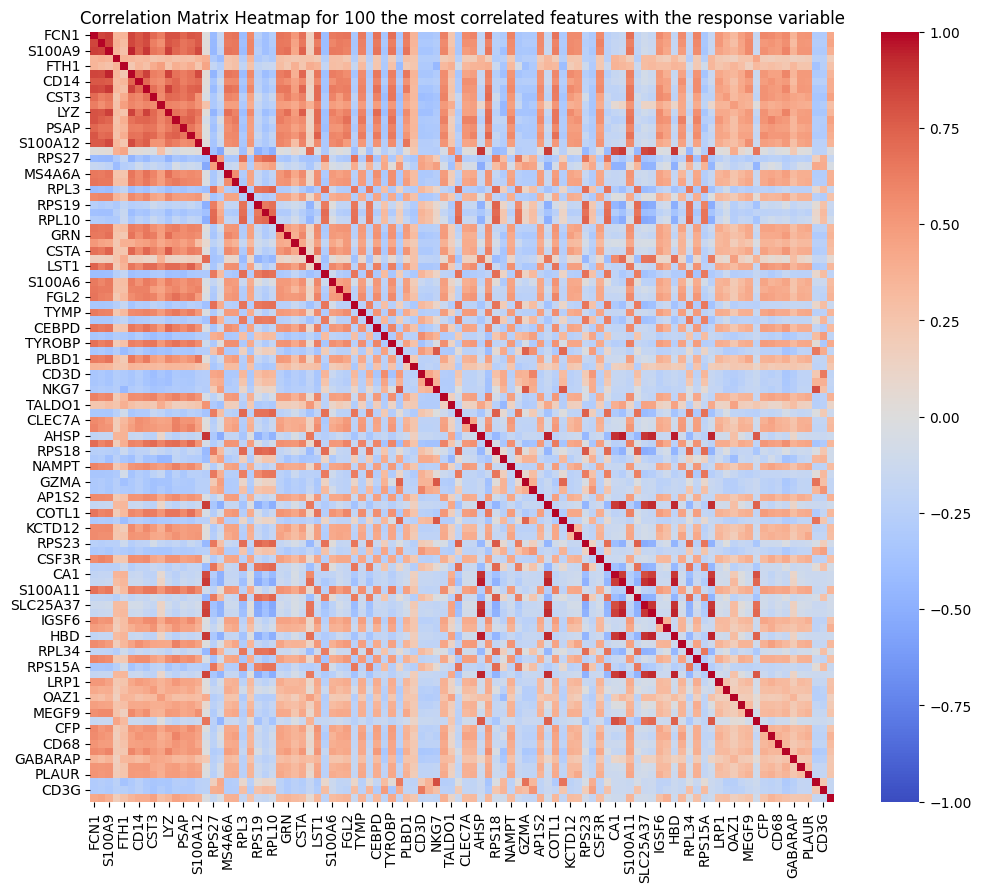

In [13]:
sorted_correlations = correlations.abs().sort_values(ascending=False)
top_correlations = sorted_correlations.head(100)
print(top_correlations)

X_train_filtered = X_train[top_correlations.index]

plt.figure(figsize=(12, 10))
sns.heatmap(X_train_filtered.corr(), cmap="coolwarm", vmin=-1, vmax=1)
plt.title(
    "Correlation Matrix Heatmap for 100 the most correlated features with the response variable"
)
plt.show()

#### Observations:

- There are some highly correlated features, especially amongst the top 16 (with regard to the correlation with response variable) ones
- There are also some noticeable positive correlations for single pairs in the bottom part of the heatmap, e.g. for the `CA1` variable
- For the same variables as in the previous observation, we can spot some higher (in terms of absolute value) negative correlation values, although these aren't as high and as numerous as the positive ones
- In general there's some multicolinearity between the features, which we will need to take into consideration in the further parts of this project


### ElasticNet


ElasticNet is a linear regression model that combines the properties of both Ridge and Lasso regression, and therefore aims to improve the limitations of both by balancing their penalties. Model estimates the linear coefficients/weights, denoted by $\beta$. The estimator can be defined as:

$$ \hat{\beta} = \text{argmin}_{\beta}(\|y - X\beta\|^2_2 + \lambda_{2} \|\beta\|^2_2 + \lambda_1\|\beta\|_1)$$
where:\
$y$ - vector of response variable\
$X$ - matrix of dependent variables\
$\lambda_{2}$ - Ridge coefficient\
$\lambda_{1}$ - LASSO coefficient

Considering the above and the sklearn documentation, the optimization function can be written as:

$$ L(\beta) = \frac{1}{2n} \|y - X\beta\|^2_2 + \alpha \cdot \text{l1\_ratio} \cdot \|\beta\|_1 + \frac{1}{2} \alpha \cdot (1 - \text{l1\_ratio}) \cdot ||\beta||^2_2 $$
where:\
$n$ - number of observations\
$\alpha$ - hyperparameter controlling the overall strength of the regularization, when equal to 0 the model effectively becomes the OLS\
l1_ratio - hyperparameter balancing the LASSO and Ridge penalties, when equal to 0 the model reduces to the Ridge regression, and for value equal to 1 it reduces to the LASSO regression

In [15]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, KFold

np.random.seed(42)

hyperparameters_to_test = {
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3],
    "l1_ratio": [
        0.1,
        0.5,
        0.7,
        0.9,
        0.95,
        0.99,
        1,
    ],  # testing more values near 1 as suggested by the sklearn documentation
}

elastic_net = ElasticNet()

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search_en = GridSearchCV(
    estimator=elastic_net,
    param_grid=hyperparameters_to_test,
    cv=kfold,
    return_train_score=True,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=3,
)

X = X_train
y = y_train["Expected"]

grid_search_en.fit(X, y)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.604e+00, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.5;, score=(train=-0.000, test=-0.299) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.214e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.7;, score=(train=-0.001, test=-0.296) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.5;, score=(train=-0.000, test=-0.289) total time= 1.1min
[CV 2/5] END alpha=0.0001, l1_ratio=0.7;, score=(train=-0.001, test=-0.275) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.922e+00, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.5;, score=(train=-0.000, test=-0.273) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.580e+00, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.944e+00, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.5;, score=(train=-0.000, test=-0.297) total time= 1.1min
[CV 2/5] END alpha=0.0001, l1_ratio=0.5;, score=(train=-0.000, test=-0.288) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e+00, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.789e+00, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.1;, score=(train=-0.000, test=-0.324) total time= 1.2min
[CV 1/5] END alpha=0.0001, l1_ratio=0.1;, score=(train=-0.000, test=-0.315) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.723e+00, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.1;, score=(train=-0.000, test=-0.321) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.805e+00, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.1;, score=(train=-0.000, test=-0.321) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.761e+00, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.1;, score=(train=-0.000, test=-0.331) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.259e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.7;, score=(train=-0.001, test=-0.268) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.284e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.7;, score=(train=-0.001, test=-0.281) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.217e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.9;, score=(train=-0.001, test=-0.270) total time= 1.1min
[CV 4/5] END alpha=0.0001, l1_ratio=0.7;, score=(train=-0.001, test=-0.289) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.9;, score=(train=-0.001, test=-0.275) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.9;, score=(train=-0.001, test=-0.289) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.9;, score=(train=-0.001, test=-0.260) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.95;, score=(train=-0.001, test=-0.288) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.339e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.9;, score=(train=-0.001, test=-0.277) total time= 1.2min
[CV 3/5] END alpha=0.0001, l1_ratio=0.95;, score=(train=-0.001, test=-0.258) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.95;, score=(train=-0.001, test=-0.268) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.385e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.95;, score=(train=-0.001, test=-0.275) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=0.99;, score=(train=-0.001, test=-0.267) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=0.95;, score=(train=-0.001, test=-0.273) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=0.99;, score=(train=-0.001, test=-0.288) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=0.99;, score=(train=-0.001, test=-0.257) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=0.99;, score=(train=-0.001, test=-0.273) total time= 1.2min
[CV 5/5] END alpha=0.0001, l1_ratio=0.99;, score=(train=-0.001, test=-0.272) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.0001, l1_ratio=1;, score=(train=-0.001, test=-0.287) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.0001, l1_ratio=1;, score=(train=-0.001, test=-0.267) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.0001, l1_ratio=1;, score=(train=-0.001, test=-0.272) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.0001, l1_ratio=1;, score=(train=-0.001, test=-0.256) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.0001, l1_ratio=1;, score=(train=-0.001, test=-0.272) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.1;, score=(train=-0.001, test=-0.250) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.742e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.1;, score=(train=-0.001, test=-0.241) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.1;, score=(train=-0.002, test=-0.243) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.1;, score=(train=-0.002, test=-0.232) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.501e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.5;, score=(train=-0.016, test=-0.170) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.773e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.5;, score=(train=-0.015, test=-0.180) total time= 1.1min
[CV 2/5] END alpha=0.001, l1_ratio=0.1;, score=(train=-0.001, test=-0.248) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.859e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.5;, score=(train=-0.016, test=-0.175) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.433e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.5;, score=(train=-0.016, test=-0.164) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.7;, score=(train=-0.023, test=-0.164) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.903e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.5;, score=(train=-0.016, test=-0.169) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.7;, score=(train=-0.024, test=-0.154) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.486e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.7;, score=(train=-0.025, test=-0.153) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.404e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.7;, score=(train=-0.025, test=-0.152) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.264e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.7;, score=(train=-0.024, test=-0.145) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.9;, score=(train=-0.031, test=-0.152) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.461e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.9;, score=(train=-0.033, test=-0.143) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.320e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.9;, score=(train=-0.032, test=-0.145) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.083e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.9;, score=(train=-0.032, test=-0.131) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.95;, score=(train=-0.033, test=-0.149) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.9;, score=(train=-0.033, test=-0.141) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.853e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.363e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=0.95;, score=(train=-0.034, test=-0.143) total time= 1.2min
[CV 4/5] END alpha=0.001, l1_ratio=0.95;, score=(train=-0.034, test=-0.129) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.413e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.95;, score=(train=-0.035, test=-0.141) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.255e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.95;, score=(train=-0.035, test=-0.139) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.051e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=0.99;, score=(train=-0.034, test=-0.148) total time= 1.2min
[CV 2/5] END alpha=0.001, l1_ratio=0.99;, score=(train=-0.035, test=-0.141) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.102e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=0.99;, score=(train=-0.036, test=-0.140) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.162e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.001, l1_ratio=1;, score=(train=-0.035, test=-0.147) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.252e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=0.99;, score=(train=-0.035, test=-0.127) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.218e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.001, l1_ratio=0.99;, score=(train=-0.036, test=-0.138) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=0.001, l1_ratio=1;, score=(train=-0.036, test=-0.126) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.001, l1_ratio=1;, score=(train=-0.037, test=-0.140) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.965e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.712e+00, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.001, l1_ratio=1;, score=(train=-0.036, test=-0.141) total time= 1.2min
[CV 5/5] END alpha=0.001, l1_ratio=1;, score=(train=-0.037, test=-0.137) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e+01, tolerance: 2.270e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.01, l1_ratio=0.1;, score=(train=-0.039, test=-0.138) total time= 1.1min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e+01, tolerance: 2.265e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=0.01, l1_ratio=0.1;, score=(train=-0.040, test=-0.134) total time= 1.2min
[CV 2/5] END alpha=0.01, l1_ratio=0.7;, score=(train=-0.107, test=-0.117) total time=  16.7s
[CV 5/5] END alpha=0.01, l1_ratio=0.5;, score=(train=-0.100, test=-0.125) total time=  20.2s
[CV 2/5] END alpha=0.01, l1_ratio=0.5;, score=(train=-0.099, test=-0.116) total time=  25.3s
[CV 1/5] END alpha=0.01, l1_ratio=0.7;, score=(train=-0.108, test=-0.118) total time=  20.9s
[CV 1/5] END alpha=0.01, l1_ratio=0.5;, score=(train=-0.098, test=-0.116) total time=  28.2s
[CV 3/5] END alpha=0.01, l1_ratio=0.7;, score=(train=-0.108, test=-0.118) total time=  19.7s
[CV 4/5] END alpha=0.01, l1_ratio=0.5;, score=(train=-0.103, test=-0.107) total time=  25.0s
[CV 3/5] END alpha=0.01, l1_ratio=0.5;, score=(train=-0.100, test=-0.116) total time=  26.7s
[CV 4/5] END alpha=0.01, l1_ratio=0.7;, score=(train=-0.111, test=-0.110) total time=  19.4s
[CV 1/5] END alpha=0.01, l1_ratio=0.9;, score=(train=-0.113, test=-0.1

/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e+01, tolerance: 2.242e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=0.01, l1_ratio=0.1;, score=(train=-0.041, test=-0.131) total time= 1.2min


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e+01, tolerance: 2.219e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=0.01, l1_ratio=0.1;, score=(train=-0.041, test=-0.134) total time= 1.3min
[CV 4/5] END alpha=0.01, l1_ratio=1;, score=(train=-0.118, test=-0.114) total time=  14.0s
[CV 2/5] END alpha=0.1, l1_ratio=0.1;, score=(train=-0.117, test=-0.121) total time=  13.3s
[CV 1/5] END alpha=0.1, l1_ratio=0.1;, score=(train=-0.117, test=-0.123) total time=  14.3s


/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.253e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.1, l1_ratio=0.5;, score=(train=-0.162, test=-0.162) total time=   5.3s
[CV 4/5] END alpha=0.01, l1_ratio=0.1;, score=(train=-0.040, test=-0.119) total time= 1.3min
[CV 2/5] END alpha=0.1, l1_ratio=0.5;, score=(train=-0.162, test=-0.161) total time=   4.9s
[CV 3/5] END alpha=0.01, l1_ratio=1;, score=(train=-0.115, test=-0.121) total time=  16.5s
[CV 3/5] END alpha=0.1, l1_ratio=0.1;, score=(train=-0.117, test=-0.124) total time=  15.5s
[CV 5/5] END alpha=0.01, l1_ratio=1;, score=(train=-0.113, test=-0.134) total time=  18.4s
[CV 3/5] END alpha=0.1, l1_ratio=0.5;, score=(train=-0.163, test=-0.162) total time=   5.3s
[CV 5/5] END alpha=0.1, l1_ratio=0.1;, score=(train=-0.115, test=-0.133) total time=  14.1s
[CV 4/5] END alpha=0.1, l1_ratio=0.1;, score=(train=-0.119, test=-0.115) total time=  15.3s
[CV 4/5] END alpha=0.1, l1_ratio=0.5;, score=(train=-0.163, test=-0.158) total time=   5.8s
[CV 1/5] END alpha=0.1, l1_ratio=0.7;, score=(train=-0.175, test=-0.174) total ti

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 100.0, 1000.0],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [17]:
print(f"Hyperparameters of the best model obtained: {grid_search_en.best_params_}")

cv_results_en = grid_search_en.cv_results_
best_index_en = grid_search_en.best_index_

train_err_en = -cv_results_en["mean_train_score"][best_index_en]
val_err_en = -cv_results_en["mean_test_score"][best_index_en]

print(f"Mean train error of the best model obtained: {train_err_en}")
print(f"Mean validation error of the best model obtained: {val_err_en}")

Hyperparameters of the best model obtained: {'alpha': 0.01, 'l1_ratio': 0.5}
Mean train error of the best model obtained: 0.10011185944375278
Mean validation error of the best model obtained: 0.1162091941485709


Grid search was performed for various values of hyperparameters `alpha` and `l1_ratio`.

`alpha` was tested for different orders of magnitude, i.e. from 1e-4 to 1e3

`l1_ratio` was tested in range [0, 1], with more emphasis on the values closer to 1 (as suggested by the sklearn documentation [here](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.ElasticNetCV.html))

The `KFold` object was declared separately from the `GridSearchCV` in order to be reused later, assuring the reasonable comparison of ElasticNet and RandomForest models. The cross-validation was performed using 5 folds, i.e. the validation set size is 20% of the whole dataset size (~759 observations), which should be enough for our case. It's a little more than the size of the test set, which is 670. Using more folds might be beneficial (as there would be more data for training), but it would reduce size of the validation set and could therefore provide less meaningful results.

### Random Forest

Now let's try a different, tree-based approach. We'll feet a `RandomForestRegressor` using the same cross-validation + grid search approach, but this time tuning different hyperparameters. As the mentioned model has many such parameters and we only want to tune 3 of them, I decided to choose those considered in the literature as impactful ones, i.e.:
- `n_estimators` - numbers of trees in the forest
- `max_features` - number of features to consider when looking for the best split
- `min_samples_split` - minimum number of samples required to split an internal node

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


hyperparameters_to_test = {
    "n_estimators": [10, 20, 50, 100],
    "max_features": ["sqrt", 0.1, 0.25, 0.5],
    "min_samples_split": [2, 5, 8, 11]
}

random_forest = RandomForestRegressor()

grid_search_rf = GridSearchCV(
    estimator=random_forest,
    param_grid=hyperparameters_to_test,
    cv=kfold,
    return_train_score=True,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=3,
)

grid_search_rf.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 4/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=(train=-0.030, test=-0.135) total time=   1.5s
[CV 1/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=(train=-0.028, test=-0.157) total time=   1.7s
[CV 3/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=(train=-0.031, test=-0.152) total time=   1.8s
[CV 5/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=(train=-0.031, test=-0.151) total time=   1.9s
[CV 2/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=(train=-0.028, test=-0.145) total time=   2.3s
[CV 5/5] END max_features=sqrt, min_samples_split=2, n_estimators=20;, score=(train=-0.022, test=-0.144) total time=   2.9s
[CV 4/5] END max_features=sqrt, min_samples_split=2, n_estimators=20;, score=(train=-0.023, test=-0.123) total time=   2.9s
[CV 2/5] END max_features=sqrt, min_samples_split=2, n_estimators=20;,

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 0.1, 0.25, 0.5],
                         'min_samples_split': [2, 5, 8, 11],
                         'n_estimators': [10, 20, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [19]:
print(f"Hyperparameters of the best model obtained: {grid_search_rf.best_params_}")

cv_results_rf = grid_search_rf.cv_results_
best_index_rf = grid_search_rf.best_index_

train_err_rf = -cv_results_rf["mean_train_score"][best_index_rf]
val_err_rf = -cv_results_rf["mean_test_score"][best_index_rf]

print(f"Mean train error of the best model obtained: {train_err_rf}")
print(f"Mean validation error of the best model obtained: {val_err_rf}")

Hyperparameters of the best model obtained: {'max_features': 0.25, 'min_samples_split': 2, 'n_estimators': 100}
Mean train error of the best model obtained: 0.014674299703050528
Mean validation error of the best model obtained: 0.10407019944693947


Now let's summarize the above results in a tabular form. For the reference let's use a simple model, which assigns the arithmetic mean of the dependent variable to any independent variable values.

In [21]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_validate


class ReferenceRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, mean):
        super().__init__()

        self.mean = mean

    def fit(self, X, y):
        pass

    def predict(self, X):
        return np.full(X.shape[0], self.mean)


reference_model = ReferenceRegressor(y.mean())

cv_results_ref = cross_validate(
    reference_model,
    X,
    y,
    cv=kfold,
    return_train_score=True,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=3,
)

train_err_ref = -cv_results_ref["train_score"].mean()
val_err_ref = -cv_results_ref["test_score"].mean()

print()
print(f"Mean train error of the best model obtained: {train_err_ref}")
print(f"Mean validation error of the best model obtained: {val_err_ref}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] END ................., score=(train=-0.740, test=-0.743) total time=   0.1s
[CV] END ................., score=(train=-0.739, test=-0.750) total time=   0.1s
[CV] END ................., score=(train=-0.731, test=-0.779) total time=   0.1s
[CV] END ................., score=(train=-0.746, test=-0.720) total time=   0.1s
[CV] END ................., score=(train=-0.748, test=-0.713) total time=   0.1s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished



Mean train error of the best model obtained: 0.7408770638799047
Mean validation error of the best model obtained: 0.7408793416328249


In [22]:
results = pd.DataFrame(
    index=["ElasticNet", "Random Forest", "Reference Model"],
    columns=["Train Error", "Validation Error"],
)

results["Train Error"] = [train_err_en, train_err_rf, train_err_ref]
results["Validation Error"] = [val_err_en, val_err_rf, val_err_ref]

results

,Train Error,Validation Error
ElasticNet,0.100112,0.116209
Random Forest,0.014674,0.104070
Reference Model,0.740877,0.740879


Obviously both tested models work much better than the simple reference model.

We can observe significantly lower validation error for the Random Forest than for the ElasticNet, not to mention the train error, where the difference is huge. It's a predictable result, as the Random Forest model is more sophisticated than the ElasticNet and we dedicated (as we needed to) more compute time to the grid search in its case.

To answer the question "Which model is the best?" we need to ask ourselves what are our priorities. If it's a predictive power, then we should go for the Random Forest. However if we've got a restricted budget and/or resources, it may be a better idea to train the ElasticNet as the results are also great and it's a less resource-heavy model.

### Prediction on a test set

In the final part of the project we'd like to create a model that minimizes error on the test set.

As the number of features in the dataset is enormous and many of them, as we concluded in the first part, aren't significantly correlated with the dependent variable, we'll first focus on reducing the dataset, i.e. feature selection and dimension reduction.

As I have _some_ experience with training ML models, I managed to get to know some techniques. One of them, which at first made a huge impression on me, is a Boruta algorithm. It's an all relevant feature selection method, and even though it's just a pretty simple heuristic, it previously gave me outstanding results.

In [23]:
!pip install Boruta

In [1]:
import pandas as pd

X = pd.read_csv("X_train.csv")
y = pd.read_csv("y_train.csv")["Expected"]

In [2]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42


boruta = BorutaPy(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        max_features="sqrt",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
    n_estimators="auto",
    verbose=2,
    random_state=RANDOM_STATE,
)

boruta.fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	9000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	9000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	9000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	9000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	9000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	9000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	9000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	864
Tentative: 	990
Rejected: 	7146
Iteration: 	9 / 100
Confirmed: 	864
Tentative: 	990
Rejected: 	7146
Iteration: 	10 / 100
Confirmed: 	864
Tentative: 	990
Rejected: 	7146
Iteration: 	11 / 100
Confirmed: 	864
Tentative: 	990
Rejected: 	7146
Iteration: 	12 / 100
Confirmed: 	868
Tentative: 	683
Rejected: 	7449
Iteration: 	13 / 100
Confirmed: 	868
Tentative: 	683
Rejected: 	7449
Iteration: 	14 / 100
Confirmed: 	868
Tentative: 	683
Rejected: 	7449
Iteration: 	15 / 100
Confirmed: 	868
Tentative: 	683
Rejected: 	7449
It

BorutaPy(estimator=RandomForestRegressor(max_depth=5, max_features='sqrt',
                                         n_estimators=844, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7E7F6103C740),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7E7F6103C740, verbose=2)

In [3]:
X_sel = boruta.transform(X.values)
X_sel.shape

(3794, 872)

Now, after we significantly reduced number of features, let's use another method to shrink our dataset and extract only the most important parts from it - the PCA dimension reduction algorithm.

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=0.44) # I did a GridSearch over many values and thus concluded that 0.44 or 0.47 seem to work the best, however this isn't present in the final version of the notebook

X_final = pca.fit_transform(scaler.fit_transform(X_sel, y), y)

We can test our preprocessing on the RF regressor using a GridSearch:

In [195]:
hyperparameters_to_test = {
    "n_estimators": [1000, 1200, 1400, 1600, 1800, 2000],
    "max_depth": [10, 15, 20, 25, 30],
    "min_samples_split": [2, 5, 8, 11],
    "min_samples_leaf": [1, 3, 5],
}

rf_preprocessing_test = RandomForestRegressor(max_features=0.5)

grid_search_preprocessing_test = GridSearchCV(
    estimator=rf_preprocessing_test,
    param_grid=hyperparameters_to_test,
    cv=kfold,
    return_train_score=True,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=3,
)

grid_search_preprocessing_test.fit(X_final, y)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=(train=-0.198, test=-0.312) total time=  46.7s
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=(train=-0.195, test=-0.332) total time=  46.9s
[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=(train=-0.197, test=-0.306) total time=  47.4s
[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=(train=-0.198, test=-0.293) total time=  48.8s
[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=(train=-0.197, test=-0.315) total time=  49.9s
[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1200;, score=(train=-0.198, test=-0.305) total time=  57.1s
[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1200;, sc

/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=(train=-0.122, test=-0.312) total time= 2.3min
[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=1000;, score=(train=-0.136, test=-0.315) total time= 1.1min
[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=1000;, score=(train=-0.138, test=-0.295) total time= 1.1min
[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=(train=-0.121, test=-0.315) total time= 2.3min
[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=(train=-0.122, test=-0.294) total time= 2.3min
[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=1000;, score=(train=-0.137, test=-0.307) total time= 1.1min
[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=(train=-0.121, test=-0.306) total time= 2.3min
[CV 1/5] END 

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(max_features=0.5), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 8, 11],
                         'n_estimators': [1000, 1200, 1400, 1600, 1800, 2000]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=3)

In [196]:
-grid_search_preprocessing_test.best_score_

np.float64(0.3109312635815472)

In [197]:
grid_search_preprocessing_test.best_params_
# {'max_depth': 15,
#  'min_samples_leaf': 3,
#  'min_samples_split': 8,
#  'n_estimators': 1800}

{'max_depth': 15,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1800}

GridSearch isn't the most effective approach to the hyperparameter tuning problem. In the further part of the project I'll use Optuna to tune hyperparameters as it seems to be a more sophisticated and efficient approach. Let's create some methods to make tests easy to run:

In [34]:
from numpy.typing import ArrayLike
from optuna import create_study, Study, Trial
from optuna.visualization import plot_optimization_history
from plotly.io import show
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score, KFold


kfold = kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
model_parameters = {}


def score_trial(
    model: BaseEstimator, X: ArrayLike, y: ArrayLike, kfold: KFold
) -> float:
    return -cross_val_score(
        model,
        X,
        y,
        cv=kfold,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    ).mean()


def get_objective_func(model_type: type, X: ArrayLike, y: ArrayLike, kfold: KFold):
    def objective(trial: Trial) -> float:
        params = model_parameters[model_type](trial)

        model = model_type(**params)

        return score_trial(model, X, y, kfold)

    return objective


def run_study(
    model_type: type,
    X: ArrayLike,
    y: ArrayLike,
    kfold: KFold,
    n_trials: int = 100,
    plot_opt_history: bool = True,
) -> Study:
    study = create_study(direction="minimize")
    objective_fun = get_objective_func(model_type, X, y, kfold)

    study.optimize(objective_fun, n_trials=n_trials, n_jobs=-1, show_progress_bar=True)

    print("Best parameters:", study.best_params)
    print("Best RMSE:", study.best_value)

    if plot_opt_history:
        fig = plot_optimization_history(study)
        show(fig)

    return study

Let's try different models from sklearn to check which one performs the best, in particular we'll use:
- RandomForest
- ExtraTrees
- SVR

In [7]:
# 'rf_n_estimators': 1862, 'rf_max_depth': 19, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 3

from sklearn.ensemble import RandomForestRegressor


def get_rf_parameters(trial: Trial) -> dict[str, int | float]:
    return {
        "max_features": 0.5,
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 11),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "random_state": RANDOM_STATE,
    }


model_parameters[RandomForestRegressor] = get_rf_parameters

run_study(RandomForestRegressor, X_final, y, kfold, n_trials=200)

[I 2025-01-11 00:59:56,183] A new study created in memory with name: no-name-cafdd2cc-b843-4136-b71b-481ccac0c9cd
Best trial: 0. Best value: 0.312316:   0%|          | 1/200 [00:40<2:15:13, 40.77s/it]

[I 2025-01-11 01:00:36,948] Trial 0 finished with value: 0.3123159316435803 and parameters: {'n_estimators': 575, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.3123159316435803.


Best trial: 1. Best value: 0.311333:   1%|          | 2/200 [01:06<1:44:28, 31.66s/it]

[I 2025-01-11 01:01:02,234] Trial 1 finished with value: 0.3113326270370818 and parameters: {'n_estimators': 1153, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.3113326270370818.


Best trial: 3. Best value: 0.311199:   2%|▏         | 3/200 [01:38<1:44:32, 31.84s/it]

[I 2025-01-11 01:01:34,282] Trial 3 finished with value: 0.31119851561135764 and parameters: {'n_estimators': 1130, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.31119851561135764.


Best trial: 3. Best value: 0.311199:   2%|▏         | 4/200 [02:09<1:43:57, 31.82s/it]

[I 2025-01-11 01:02:06,083] Trial 2 finished with value: 0.31281125638205276 and parameters: {'n_estimators': 951, 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.31119851561135764.


Best trial: 3. Best value: 0.311199:   2%|▎         | 5/200 [02:43<1:46:01, 32.62s/it]

[I 2025-01-11 01:02:40,122] Trial 5 finished with value: 0.31140771445138876 and parameters: {'n_estimators': 1135, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.31119851561135764.


Best trial: 3. Best value: 0.311199:   3%|▎         | 6/200 [03:19<1:48:34, 33.58s/it]

[I 2025-01-11 01:03:15,567] Trial 4 finished with value: 0.3121424679620722 and parameters: {'n_estimators': 1039, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.31119851561135764.


Best trial: 3. Best value: 0.311199:   4%|▎         | 7/200 [03:37<1:31:25, 28.42s/it]

[I 2025-01-11 01:03:33,360] Trial 10 finished with value: 0.3116758118350818 and parameters: {'n_estimators': 1733, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.31119851561135764.


Best trial: 3. Best value: 0.311199:   4%|▍         | 8/200 [04:03<1:28:50, 27.76s/it]

[I 2025-01-11 01:03:59,713] Trial 7 finished with value: 0.31209807028843195 and parameters: {'n_estimators': 736, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.31119851561135764.


Best trial: 3. Best value: 0.311199:   4%|▍         | 9/200 [04:42<1:39:15, 31.18s/it]

[I 2025-01-11 01:04:38,418] Trial 6 finished with value: 0.31162819901248234 and parameters: {'n_estimators': 1506, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.31119851561135764.


Best trial: 3. Best value: 0.311199:   5%|▌         | 10/200 [05:16<1:41:24, 32.02s/it]

[I 2025-01-11 01:05:12,310] Trial 8 finished with value: 0.3122191315180872 and parameters: {'n_estimators': 537, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.31119851561135764.


Best trial: 3. Best value: 0.311199:   6%|▌         | 11/200 [05:30<1:23:48, 26.60s/it]

[I 2025-01-11 01:05:26,635] Trial 9 finished with value: 0.3115414539716882 and parameters: {'n_estimators': 1496, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.31119851561135764.


Best trial: 3. Best value: 0.311199:   6%|▌         | 12/200 [05:59<1:25:14, 27.20s/it]

[I 2025-01-11 01:05:55,209] Trial 12 finished with value: 0.31176946230943425 and parameters: {'n_estimators': 726, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.31119851561135764.


Best trial: 3. Best value: 0.311199:   6%|▋         | 13/200 [06:42<1:40:33, 32.27s/it]

[I 2025-01-11 01:06:39,125] Trial 11 finished with value: 0.31127282403612805 and parameters: {'n_estimators': 1726, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.31119851561135764.


Best trial: 14. Best value: 0.31103:   7%|▋         | 14/200 [07:42<2:05:11, 40.38s/it]

[I 2025-01-11 01:07:38,263] Trial 14 finished with value: 0.3110302500094346 and parameters: {'n_estimators': 1482, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:   8%|▊         | 15/200 [07:51<1:35:24, 30.95s/it]

[I 2025-01-11 01:07:47,342] Trial 13 finished with value: 0.31135380293169057 and parameters: {'n_estimators': 1872, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:   8%|▊         | 16/200 [08:29<1:41:16, 33.03s/it]

[I 2025-01-11 01:08:25,198] Trial 15 finished with value: 0.312713624263532 and parameters: {'n_estimators': 1194, 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:   8%|▊         | 17/200 [08:39<1:20:04, 26.26s/it]

[I 2025-01-11 01:08:35,706] Trial 16 finished with value: 0.31153238659422583 and parameters: {'n_estimators': 1247, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:   9%|▉         | 18/200 [08:55<1:10:30, 23.25s/it]

[I 2025-01-11 01:08:51,948] Trial 17 finished with value: 0.31152597916904484 and parameters: {'n_estimators': 603, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  10%|▉         | 19/200 [09:55<1:42:47, 34.08s/it]

[I 2025-01-11 01:09:51,249] Trial 19 finished with value: 0.3115266320358151 and parameters: {'n_estimators': 1494, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  10%|█         | 20/200 [10:33<1:46:16, 35.42s/it]

[I 2025-01-11 01:10:29,818] Trial 18 finished with value: 0.3124432866585848 and parameters: {'n_estimators': 1826, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  10%|█         | 21/200 [11:06<1:43:28, 34.69s/it]

[I 2025-01-11 01:11:02,784] Trial 20 finished with value: 0.3120396316110664 and parameters: {'n_estimators': 1113, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  11%|█         | 22/200 [11:26<1:29:56, 30.32s/it]

[I 2025-01-11 01:11:22,922] Trial 21 finished with value: 0.31171212755995736 and parameters: {'n_estimators': 1461, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  12%|█▏        | 23/200 [11:51<1:24:51, 28.76s/it]

[I 2025-01-11 01:11:48,058] Trial 22 finished with value: 0.31142399277548466 and parameters: {'n_estimators': 1290, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  12%|█▏        | 24/200 [12:09<1:14:20, 25.34s/it]

[I 2025-01-11 01:12:05,412] Trial 23 finished with value: 0.31133529246022446 and parameters: {'n_estimators': 1394, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  12%|█▎        | 25/200 [12:48<1:25:39, 29.37s/it]

[I 2025-01-11 01:12:44,178] Trial 24 finished with value: 0.311697989361281 and parameters: {'n_estimators': 1869, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  13%|█▎        | 26/200 [13:35<1:40:56, 34.81s/it]

[I 2025-01-11 01:13:31,678] Trial 25 finished with value: 0.3113577324576172 and parameters: {'n_estimators': 1985, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  14%|█▎        | 27/200 [13:53<1:25:34, 29.68s/it]

[I 2025-01-11 01:13:49,391] Trial 26 finished with value: 0.3111018137920071 and parameters: {'n_estimators': 1361, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  14%|█▍        | 28/200 [14:17<1:20:42, 28.15s/it]

[I 2025-01-11 01:14:13,991] Trial 27 finished with value: 0.31146732629631274 and parameters: {'n_estimators': 1414, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  14%|█▍        | 29/200 [14:49<1:23:38, 29.35s/it]

[I 2025-01-11 01:14:46,114] Trial 28 finished with value: 0.31145659375674234 and parameters: {'n_estimators': 1476, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  15%|█▌        | 30/200 [15:11<1:16:50, 27.12s/it]

[I 2025-01-11 01:15:08,037] Trial 29 finished with value: 0.31126003693903065 and parameters: {'n_estimators': 1446, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  16%|█▌        | 31/200 [15:34<1:12:36, 25.78s/it]

[I 2025-01-11 01:15:30,684] Trial 30 finished with value: 0.31130074100134786 and parameters: {'n_estimators': 1370, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  16%|█▌        | 32/200 [15:57<1:09:29, 24.82s/it]

[I 2025-01-11 01:15:53,262] Trial 31 finished with value: 0.31128560797786126 and parameters: {'n_estimators': 1384, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 14. Best value: 0.31103:  16%|█▋        | 33/200 [16:39<1:23:22, 29.95s/it]

[I 2025-01-11 01:16:35,201] Trial 32 finished with value: 0.3112408654151385 and parameters: {'n_estimators': 1657, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.3110302500094346.


Best trial: 33. Best value: 0.310907:  17%|█▋        | 34/200 [17:20<1:32:51, 33.56s/it]

[I 2025-01-11 01:17:17,175] Trial 33 finished with value: 0.3109070943013822 and parameters: {'n_estimators': 1625, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.3109070943013822.


Best trial: 33. Best value: 0.310907:  18%|█▊        | 35/200 [17:58<1:35:27, 34.71s/it]

[I 2025-01-11 01:17:54,585] Trial 34 finished with value: 0.31103711848826354 and parameters: {'n_estimators': 1671, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.3109070943013822.


Best trial: 33. Best value: 0.310907:  18%|█▊        | 36/200 [18:37<1:38:44, 36.12s/it]

[I 2025-01-11 01:18:33,997] Trial 35 finished with value: 0.31101766767690836 and parameters: {'n_estimators': 1640, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.3109070943013822.


Best trial: 33. Best value: 0.310907:  18%|█▊        | 37/200 [19:15<1:39:06, 36.48s/it]

[I 2025-01-11 01:19:11,311] Trial 36 finished with value: 0.3110254130561138 and parameters: {'n_estimators': 1655, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.3109070943013822.


Best trial: 33. Best value: 0.310907:  19%|█▉        | 38/200 [19:47<1:35:15, 35.28s/it]

[I 2025-01-11 01:19:43,785] Trial 38 finished with value: 0.31096583140864903 and parameters: {'n_estimators': 939, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.3109070943013822.


Best trial: 33. Best value: 0.310907:  20%|█▉        | 39/200 [19:53<1:10:59, 26.45s/it]

[I 2025-01-11 01:19:49,648] Trial 37 finished with value: 0.31093185340600327 and parameters: {'n_estimators': 1644, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.3109070943013822.


Best trial: 33. Best value: 0.310907:  20%|██        | 40/200 [20:51<1:35:54, 35.97s/it]

[I 2025-01-11 01:20:47,806] Trial 39 finished with value: 0.31129630458877217 and parameters: {'n_estimators': 1605, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.3109070943013822.


Best trial: 33. Best value: 0.310907:  20%|██        | 41/200 [21:05<1:17:23, 29.20s/it]

[I 2025-01-11 01:21:01,219] Trial 40 finished with value: 0.31118578362264837 and parameters: {'n_estimators': 1615, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.3109070943013822.


Best trial: 33. Best value: 0.310907:  21%|██        | 42/200 [22:04<1:40:53, 38.32s/it]

[I 2025-01-11 01:22:00,803] Trial 41 finished with value: 0.3111797368890698 and parameters: {'n_estimators': 1608, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.3109070943013822.


Best trial: 33. Best value: 0.310907:  22%|██▏       | 43/200 [22:21<1:23:42, 31.99s/it]

[I 2025-01-11 01:22:18,030] Trial 42 finished with value: 0.3113018376257056 and parameters: {'n_estimators': 1618, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.3109070943013822.


Best trial: 33. Best value: 0.310907:  22%|██▏       | 44/200 [23:09<1:35:13, 36.62s/it]

[I 2025-01-11 01:23:05,472] Trial 43 finished with value: 0.3111911914665701 and parameters: {'n_estimators': 1626, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.3109070943013822.


Best trial: 44. Best value: 0.310854:  22%|██▎       | 45/200 [23:44<1:33:38, 36.25s/it]

[I 2025-01-11 01:23:40,834] Trial 44 finished with value: 0.31085434345574225 and parameters: {'n_estimators': 1618, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 44 with value: 0.31085434345574225.


Best trial: 45. Best value: 0.3108:  23%|██▎       | 46/200 [23:51<1:10:31, 27.48s/it]  

[I 2025-01-11 01:23:47,859] Trial 45 finished with value: 0.3108001782999482 and parameters: {'n_estimators': 1587, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 45 with value: 0.3108001782999482.


Best trial: 46. Best value: 0.310792:  24%|██▎       | 47/200 [25:02<1:42:53, 40.35s/it]

[I 2025-01-11 01:24:58,241] Trial 46 finished with value: 0.31079175085105015 and parameters: {'n_estimators': 1580, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 46 with value: 0.31079175085105015.


Best trial: 46. Best value: 0.310792:  24%|██▍       | 48/200 [25:12<1:19:43, 31.47s/it]

[I 2025-01-11 01:25:08,989] Trial 47 finished with value: 0.31104845953110505 and parameters: {'n_estimators': 1643, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 46 with value: 0.31079175085105015.


Best trial: 46. Best value: 0.310792:  24%|██▍       | 49/200 [26:10<1:38:44, 39.24s/it]

[I 2025-01-11 01:26:06,353] Trial 50 finished with value: 0.3113841013808032 and parameters: {'n_estimators': 858, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 46 with value: 0.31079175085105015.


Best trial: 46. Best value: 0.310792:  25%|██▌       | 50/200 [26:15<1:12:26, 28.98s/it]

[I 2025-01-11 01:26:11,392] Trial 48 finished with value: 0.3111314780974753 and parameters: {'n_estimators': 1588, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 46 with value: 0.31079175085105015.


Best trial: 46. Best value: 0.310792:  26%|██▌       | 51/200 [26:37<1:07:03, 27.00s/it]

[I 2025-01-11 01:26:33,789] Trial 49 finished with value: 0.3111278192473072 and parameters: {'n_estimators': 1608, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 46 with value: 0.31079175085105015.


Best trial: 46. Best value: 0.310792:  26%|██▌       | 52/200 [26:50<55:59, 22.70s/it]  

[I 2025-01-11 01:26:46,448] Trial 51 finished with value: 0.31160615027246064 and parameters: {'n_estimators': 845, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 46 with value: 0.31079175085105015.


Best trial: 52. Best value: 0.310785:  26%|██▋       | 53/200 [27:21<1:02:11, 25.38s/it]

[I 2025-01-11 01:27:18,089] Trial 52 finished with value: 0.3107851074208501 and parameters: {'n_estimators': 874, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  27%|██▋       | 54/200 [27:38<55:33, 22.83s/it]  

[I 2025-01-11 01:27:34,980] Trial 53 finished with value: 0.3108580105469796 and parameters: {'n_estimators': 927, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  28%|██▊       | 55/200 [28:04<57:25, 23.76s/it]

[I 2025-01-11 01:28:00,909] Trial 54 finished with value: 0.31089627562092526 and parameters: {'n_estimators': 996, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  28%|██▊       | 56/200 [28:27<56:22, 23.49s/it]

[I 2025-01-11 01:28:23,769] Trial 55 finished with value: 0.31087707005809817 and parameters: {'n_estimators': 922, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  28%|██▊       | 57/200 [28:46<52:32, 22.05s/it]

[I 2025-01-11 01:28:42,442] Trial 56 finished with value: 0.31084580942047285 and parameters: {'n_estimators': 915, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  29%|██▉       | 58/200 [29:08<52:35, 22.22s/it]

[I 2025-01-11 01:29:05,077] Trial 57 finished with value: 0.3107875823138809 and parameters: {'n_estimators': 859, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  30%|██▉       | 59/200 [30:01<1:13:49, 31.42s/it]

[I 2025-01-11 01:29:57,953] Trial 58 finished with value: 0.3108058702244029 and parameters: {'n_estimators': 1551, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  30%|███       | 60/200 [30:35<1:14:57, 32.12s/it]

[I 2025-01-11 01:30:31,712] Trial 59 finished with value: 0.31140750319518884 and parameters: {'n_estimators': 1774, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  30%|███       | 61/200 [31:39<1:36:18, 41.57s/it]

[I 2025-01-11 01:31:35,329] Trial 60 finished with value: 0.3112906776787751 and parameters: {'n_estimators': 1762, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  31%|███       | 62/200 [32:12<1:29:58, 39.12s/it]

[I 2025-01-11 01:32:08,724] Trial 61 finished with value: 0.31137308100422534 and parameters: {'n_estimators': 1762, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  32%|███▏      | 63/200 [33:14<1:44:37, 45.82s/it]

[I 2025-01-11 01:33:10,190] Trial 62 finished with value: 0.31138271616937496 and parameters: {'n_estimators': 1766, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  32%|███▏      | 64/200 [33:44<1:33:26, 41.23s/it]

[I 2025-01-11 01:33:40,689] Trial 63 finished with value: 0.3113598243334756 and parameters: {'n_estimators': 1760, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  32%|███▎      | 65/200 [34:12<1:23:40, 37.19s/it]

[I 2025-01-11 01:34:08,461] Trial 64 finished with value: 0.31135661152448396 and parameters: {'n_estimators': 1783, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  33%|███▎      | 66/200 [34:58<1:29:19, 39.99s/it]

[I 2025-01-11 01:34:55,002] Trial 66 finished with value: 0.3116541999199027 and parameters: {'n_estimators': 991, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  34%|███▎      | 67/200 [35:05<1:06:43, 30.10s/it]

[I 2025-01-11 01:35:02,029] Trial 65 finished with value: 0.3113368359849907 and parameters: {'n_estimators': 1739, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  34%|███▍      | 68/200 [35:26<59:59, 27.27s/it]  

[I 2025-01-11 01:35:22,668] Trial 67 finished with value: 0.3116556105043289 and parameters: {'n_estimators': 754, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  34%|███▍      | 69/200 [35:39<50:23, 23.08s/it]

[I 2025-01-11 01:35:35,970] Trial 68 finished with value: 0.31187294564633206 and parameters: {'n_estimators': 715, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  35%|███▌      | 70/200 [35:47<39:53, 18.41s/it]

[I 2025-01-11 01:35:43,492] Trial 69 finished with value: 0.3113745350034053 and parameters: {'n_estimators': 725, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  36%|███▌      | 71/200 [36:19<48:26, 22.53s/it]

[I 2025-01-11 01:36:15,647] Trial 70 finished with value: 0.3118872278303052 and parameters: {'n_estimators': 698, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  36%|███▌      | 72/200 [36:25<37:45, 17.70s/it]

[I 2025-01-11 01:36:22,067] Trial 71 finished with value: 0.31157515980581474 and parameters: {'n_estimators': 679, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  36%|███▋      | 73/200 [36:58<47:13, 22.31s/it]

[I 2025-01-11 01:36:55,134] Trial 73 finished with value: 0.31160662118899973 and parameters: {'n_estimators': 692, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  37%|███▋      | 74/200 [37:00<33:41, 16.04s/it]

[I 2025-01-11 01:36:56,549] Trial 72 finished with value: 0.3119018971857394 and parameters: {'n_estimators': 756, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  38%|███▊      | 75/200 [37:16<33:10, 15.92s/it]

[I 2025-01-11 01:37:12,192] Trial 74 finished with value: 0.3111470648637767 and parameters: {'n_estimators': 769, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  38%|███▊      | 76/200 [37:31<32:21, 15.66s/it]

[I 2025-01-11 01:37:27,240] Trial 75 finished with value: 0.31112314943883457 and parameters: {'n_estimators': 656, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  38%|███▊      | 77/200 [37:43<29:56, 14.61s/it]

[I 2025-01-11 01:37:39,387] Trial 76 finished with value: 0.311461466804987 and parameters: {'n_estimators': 706, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  39%|███▉      | 78/200 [38:04<33:53, 16.66s/it]

[I 2025-01-11 01:38:00,856] Trial 77 finished with value: 0.31147508865241746 and parameters: {'n_estimators': 707, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  40%|███▉      | 79/200 [38:09<26:15, 13.02s/it]

[I 2025-01-11 01:38:05,384] Trial 78 finished with value: 0.31112573865138865 and parameters: {'n_estimators': 653, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  40%|████      | 80/200 [38:30<30:59, 15.49s/it]

[I 2025-01-11 01:38:26,641] Trial 79 finished with value: 0.31102444961833153 and parameters: {'n_estimators': 652, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  40%|████      | 81/200 [39:06<42:40, 21.52s/it]

[I 2025-01-11 01:39:02,208] Trial 81 finished with value: 0.31101008709302075 and parameters: {'n_estimators': 1080, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  41%|████      | 82/200 [39:19<37:41, 19.16s/it]

[I 2025-01-11 01:39:15,876] Trial 80 finished with value: 0.31082995933555485 and parameters: {'n_estimators': 1530, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  42%|████▏     | 83/200 [39:43<39:54, 20.47s/it]

[I 2025-01-11 01:39:39,400] Trial 82 finished with value: 0.3114799501986699 and parameters: {'n_estimators': 840, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  42%|████▏     | 84/200 [39:58<36:43, 19.00s/it]

[I 2025-01-11 01:39:54,955] Trial 83 finished with value: 0.3111066721266439 and parameters: {'n_estimators': 882, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  42%|████▎     | 85/200 [40:41<50:14, 26.21s/it]

[I 2025-01-11 01:40:38,018] Trial 85 finished with value: 0.31093490391748146 and parameters: {'n_estimators': 1109, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  43%|████▎     | 86/200 [40:55<42:32, 22.39s/it]

[I 2025-01-11 01:40:51,493] Trial 84 finished with value: 0.3108442089778887 and parameters: {'n_estimators': 1553, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  44%|████▎     | 87/200 [41:45<57:38, 30.61s/it]

[I 2025-01-11 01:41:41,277] Trial 86 finished with value: 0.31083950662029036 and parameters: {'n_estimators': 1540, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  44%|████▍     | 88/200 [42:04<50:42, 27.16s/it]

[I 2025-01-11 01:42:00,393] Trial 87 finished with value: 0.3112646388616242 and parameters: {'n_estimators': 1558, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  44%|████▍     | 89/200 [42:43<57:14, 30.94s/it]

[I 2025-01-11 01:42:40,142] Trial 89 finished with value: 0.3116202137712514 and parameters: {'n_estimators': 837, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  45%|████▌     | 90/200 [43:05<51:18, 27.99s/it]

[I 2025-01-11 01:43:01,240] Trial 88 finished with value: 0.3112770209587392 and parameters: {'n_estimators': 1545, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  46%|████▌     | 91/200 [43:40<55:07, 30.35s/it]

[I 2025-01-11 01:43:37,100] Trial 91 finished with value: 0.31141570136726593 and parameters: {'n_estimators': 1082, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  46%|████▌     | 92/200 [43:53<44:56, 24.97s/it]

[I 2025-01-11 01:43:49,504] Trial 90 finished with value: 0.3117293800027427 and parameters: {'n_estimators': 1547, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  46%|████▋     | 93/200 [44:47<1:00:13, 33.77s/it]

[I 2025-01-11 01:44:43,828] Trial 93 finished with value: 0.3114861425141173 and parameters: {'n_estimators': 1312, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  47%|████▋     | 94/200 [44:57<46:49, 26.50s/it]  

[I 2025-01-11 01:44:53,364] Trial 92 finished with value: 0.3108273074375224 and parameters: {'n_estimators': 1539, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  48%|████▊     | 95/200 [46:03<1:07:08, 38.36s/it]

[I 2025-01-11 01:45:59,405] Trial 94 finished with value: 0.3114985854347878 and parameters: {'n_estimators': 1699, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  48%|████▊     | 96/200 [46:14<52:29, 30.29s/it]  

[I 2025-01-11 01:46:10,850] Trial 95 finished with value: 0.3115456190762863 and parameters: {'n_estimators': 1513, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  48%|████▊     | 97/200 [47:08<1:03:53, 37.22s/it]

[I 2025-01-11 01:47:04,229] Trial 96 finished with value: 0.31121446394322627 and parameters: {'n_estimators': 1566, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  49%|████▉     | 98/200 [47:25<52:59, 31.17s/it]  

[I 2025-01-11 01:47:21,299] Trial 97 finished with value: 0.3115135910514718 and parameters: {'n_estimators': 1515, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  50%|████▉     | 99/200 [47:50<49:47, 29.58s/it]

[I 2025-01-11 01:47:47,155] Trial 98 finished with value: 0.3114419245083869 and parameters: {'n_estimators': 1534, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  50%|█████     | 100/200 [48:34<56:24, 33.84s/it]

[I 2025-01-11 01:48:30,956] Trial 99 finished with value: 0.3114789804452749 and parameters: {'n_estimators': 1690, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  50%|█████     | 101/200 [48:46<44:45, 27.12s/it]

[I 2025-01-11 01:48:42,395] Trial 100 finished with value: 0.3114139142012944 and parameters: {'n_estimators': 1527, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  51%|█████     | 102/200 [49:40<57:36, 35.27s/it]

[I 2025-01-11 01:49:36,691] Trial 101 finished with value: 0.31140562809247924 and parameters: {'n_estimators': 1523, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  52%|█████▏    | 103/200 [49:53<46:07, 28.53s/it]

[I 2025-01-11 01:49:49,482] Trial 102 finished with value: 0.311493516793869 and parameters: {'n_estimators': 1699, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  52%|█████▏    | 104/200 [50:07<38:57, 24.35s/it]

[I 2025-01-11 01:50:04,070] Trial 103 finished with value: 0.31144427808876357 and parameters: {'n_estimators': 1316, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  52%|█████▎    | 105/200 [50:56<50:16, 31.75s/it]

[I 2025-01-11 01:50:53,093] Trial 104 finished with value: 0.31141278257189875 and parameters: {'n_estimators': 1517, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  53%|█████▎    | 106/200 [51:12<41:56, 26.77s/it]

[I 2025-01-11 01:51:08,233] Trial 105 finished with value: 0.311493516793869 and parameters: {'n_estimators': 1699, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  54%|█████▎    | 107/200 [51:56<49:50, 32.15s/it]

[I 2025-01-11 01:51:52,946] Trial 106 finished with value: 0.3112553567895472 and parameters: {'n_estimators': 1436, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  54%|█████▍    | 108/200 [52:12<41:48, 27.27s/it]

[I 2025-01-11 01:52:08,821] Trial 107 finished with value: 0.31149567000218925 and parameters: {'n_estimators': 1447, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  55%|█████▍    | 109/200 [52:52<47:09, 31.10s/it]

[I 2025-01-11 01:52:48,852] Trial 108 finished with value: 0.3115092187162034 and parameters: {'n_estimators': 1429, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  55%|█████▌    | 110/200 [53:14<42:37, 28.41s/it]

[I 2025-01-11 01:53:11,002] Trial 109 finished with value: 0.31151320084734857 and parameters: {'n_estimators': 1416, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  56%|█████▌    | 111/200 [53:22<33:00, 22.25s/it]

[I 2025-01-11 01:53:18,885] Trial 110 finished with value: 0.3115001248505892 and parameters: {'n_estimators': 1441, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  56%|█████▌    | 112/200 [54:19<47:49, 32.61s/it]

[I 2025-01-11 01:54:15,668] Trial 111 finished with value: 0.3109812161314921 and parameters: {'n_estimators': 1438, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  56%|█████▋    | 113/200 [54:36<40:29, 27.92s/it]

[I 2025-01-11 01:54:32,650] Trial 112 finished with value: 0.31084499204232874 and parameters: {'n_estimators': 1451, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  57%|█████▋    | 114/200 [55:22<47:45, 33.32s/it]

[I 2025-01-11 01:55:18,569] Trial 113 finished with value: 0.31140610735225044 and parameters: {'n_estimators': 1421, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  57%|█████▊    | 115/200 [55:47<43:34, 30.76s/it]

[I 2025-01-11 01:55:43,355] Trial 114 finished with value: 0.31125836504014404 and parameters: {'n_estimators': 1446, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  58%|█████▊    | 116/200 [55:59<35:27, 25.33s/it]

[I 2025-01-11 01:55:56,014] Trial 115 finished with value: 0.31083497273685246 and parameters: {'n_estimators': 1432, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  58%|█████▊    | 117/200 [56:59<49:21, 35.68s/it]

[I 2025-01-11 01:56:55,840] Trial 116 finished with value: 0.3112467432279155 and parameters: {'n_estimators': 1449, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  59%|█████▉    | 118/200 [57:06<37:07, 27.16s/it]

[I 2025-01-11 01:57:03,128] Trial 117 finished with value: 0.3112497148829319 and parameters: {'n_estimators': 1461, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  60%|█████▉    | 119/200 [57:52<44:00, 32.60s/it]

[I 2025-01-11 01:57:48,413] Trial 118 finished with value: 0.3112989173092483 and parameters: {'n_estimators': 1196, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  60%|██████    | 120/200 [58:23<42:49, 32.11s/it]

[I 2025-01-11 01:58:19,395] Trial 119 finished with value: 0.3108439060824635 and parameters: {'n_estimators': 1480, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  60%|██████    | 121/200 [58:40<36:23, 27.64s/it]

[I 2025-01-11 01:58:36,606] Trial 120 finished with value: 0.3108264183641695 and parameters: {'n_estimators': 1206, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  61%|██████    | 122/200 [59:13<38:03, 29.28s/it]

[I 2025-01-11 01:59:09,701] Trial 121 finished with value: 0.31086932844417786 and parameters: {'n_estimators': 1179, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  62%|██████▏   | 123/200 [59:48<39:40, 30.92s/it]

[I 2025-01-11 01:59:44,456] Trial 122 finished with value: 0.31078970334852485 and parameters: {'n_estimators': 1576, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  62%|██████▏   | 124/200 [1:00:37<45:56, 36.27s/it]

[I 2025-01-11 02:00:33,218] Trial 123 finished with value: 0.31080959591715757 and parameters: {'n_estimators': 1586, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  62%|██████▎   | 125/200 [1:00:57<39:16, 31.42s/it]

[I 2025-01-11 02:00:53,329] Trial 124 finished with value: 0.31078661522799655 and parameters: {'n_estimators': 1474, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 52. Best value: 0.310785:  63%|██████▎   | 126/200 [1:01:29<39:05, 31.69s/it]

[I 2025-01-11 02:01:25,643] Trial 125 finished with value: 0.31085042933643425 and parameters: {'n_estimators': 1481, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 52 with value: 0.3107851074208501.


Best trial: 127. Best value: 0.310763:  64%|██████▎   | 127/200 [1:01:55<36:26, 29.95s/it]

[I 2025-01-11 02:01:51,537] Trial 127 finished with value: 0.3107625252994068 and parameters: {'n_estimators': 807, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 127 with value: 0.3107625252994068.


Best trial: 127. Best value: 0.310763:  64%|██████▍   | 128/200 [1:02:17<33:15, 27.72s/it]

[I 2025-01-11 02:02:14,047] Trial 126 finished with value: 0.3108105581607596 and parameters: {'n_estimators': 1488, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 127 with value: 0.3107625252994068.


Best trial: 129. Best value: 0.310728:  64%|██████▍   | 129/200 [1:03:02<38:54, 32.88s/it]

[I 2025-01-11 02:02:58,963] Trial 129 finished with value: 0.31072782500046336 and parameters: {'n_estimators': 1217, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  65%|██████▌   | 130/200 [1:03:16<31:43, 27.20s/it]

[I 2025-01-11 02:03:12,904] Trial 128 finished with value: 0.31078638315305335 and parameters: {'n_estimators': 1578, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  66%|██████▌   | 131/200 [1:04:18<43:02, 37.43s/it]

[I 2025-01-11 02:04:14,193] Trial 130 finished with value: 0.31082370327013514 and parameters: {'n_estimators': 1578, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  66%|██████▌   | 132/200 [1:04:31<34:22, 30.34s/it]

[I 2025-01-11 02:04:27,983] Trial 131 finished with value: 0.3108023334265913 and parameters: {'n_estimators': 1486, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  66%|██████▋   | 133/200 [1:05:40<46:49, 41.93s/it]

[I 2025-01-11 02:05:36,971] Trial 133 finished with value: 0.31080113324685327 and parameters: {'n_estimators': 1493, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  67%|██████▋   | 134/200 [1:05:44<33:31, 30.48s/it]

[I 2025-01-11 02:05:40,723] Trial 132 finished with value: 0.31080549257692935 and parameters: {'n_estimators': 1587, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  68%|██████▊   | 135/200 [1:06:15<33:08, 30.60s/it]

[I 2025-01-11 02:06:11,599] Trial 134 finished with value: 0.3107846787809184 and parameters: {'n_estimators': 1565, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  68%|██████▊   | 136/200 [1:07:08<39:45, 37.27s/it]

[I 2025-01-11 02:07:04,434] Trial 135 finished with value: 0.3108187929679489 and parameters: {'n_estimators': 1594, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  68%|██████▊   | 137/200 [1:07:34<35:31, 33.84s/it]

[I 2025-01-11 02:07:30,259] Trial 136 finished with value: 0.3107861461944009 and parameters: {'n_estimators': 1570, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  69%|██████▉   | 138/200 [1:08:10<35:38, 34.48s/it]

[I 2025-01-11 02:08:06,261] Trial 138 finished with value: 0.31077324807492895 and parameters: {'n_estimators': 806, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  70%|██████▉   | 139/200 [1:08:30<30:52, 30.37s/it]

[I 2025-01-11 02:08:27,022] Trial 137 finished with value: 0.31079603614477797 and parameters: {'n_estimators': 1571, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  70%|███████   | 140/200 [1:08:37<23:07, 23.13s/it]

[I 2025-01-11 02:08:33,265] Trial 139 finished with value: 0.31077324807492895 and parameters: {'n_estimators': 806, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  70%|███████   | 141/200 [1:09:14<27:03, 27.51s/it]

[I 2025-01-11 02:09:11,013] Trial 141 finished with value: 0.3113679683887785 and parameters: {'n_estimators': 791, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  71%|███████   | 142/200 [1:09:18<19:41, 20.36s/it]

[I 2025-01-11 02:09:14,693] Trial 140 finished with value: 0.310733657584864 and parameters: {'n_estimators': 1240, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  72%|███████▏  | 143/200 [1:09:59<25:10, 26.49s/it]

[I 2025-01-11 02:09:55,481] Trial 143 finished with value: 0.3113679683887785 and parameters: {'n_estimators': 791, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  72%|███████▏  | 144/200 [1:10:34<27:14, 29.19s/it]

[I 2025-01-11 02:10:30,969] Trial 142 finished with value: 0.31124707312523026 and parameters: {'n_estimators': 1585, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  72%|███████▎  | 145/200 [1:10:41<20:27, 22.32s/it]

[I 2025-01-11 02:10:37,272] Trial 144 finished with value: 0.3114057610704183 and parameters: {'n_estimators': 810, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  73%|███████▎  | 146/200 [1:10:49<16:24, 18.23s/it]

[I 2025-01-11 02:10:45,958] Trial 145 finished with value: 0.3113697555373378 and parameters: {'n_estimators': 783, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  74%|███████▎  | 147/200 [1:11:14<17:44, 20.09s/it]

[I 2025-01-11 02:11:10,389] Trial 147 finished with value: 0.311070050422566 and parameters: {'n_estimators': 502, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  74%|███████▍  | 148/200 [1:11:25<15:07, 17.46s/it]

[I 2025-01-11 02:11:21,696] Trial 146 finished with value: 0.3113742392575333 and parameters: {'n_estimators': 802, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  74%|███████▍  | 149/200 [1:11:54<17:49, 20.98s/it]

[I 2025-01-11 02:11:50,886] Trial 148 finished with value: 0.3113639945740053 and parameters: {'n_estimators': 795, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  75%|███████▌  | 150/200 [1:12:08<15:37, 18.75s/it]

[I 2025-01-11 02:12:04,439] Trial 149 finished with value: 0.3114898018916897 and parameters: {'n_estimators': 876, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  76%|███████▌  | 151/200 [1:12:28<15:42, 19.23s/it]

[I 2025-01-11 02:12:24,797] Trial 150 finished with value: 0.3113949921412613 and parameters: {'n_estimators': 807, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  76%|███████▌  | 152/200 [1:12:53<16:39, 20.83s/it]

[I 2025-01-11 02:12:49,365] Trial 151 finished with value: 0.3114919341834646 and parameters: {'n_estimators': 880, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  76%|███████▋  | 153/200 [1:13:03<13:54, 17.75s/it]

[I 2025-01-11 02:12:59,937] Trial 152 finished with value: 0.3113697555373378 and parameters: {'n_estimators': 783, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  77%|███████▋  | 154/200 [1:13:35<16:48, 21.93s/it]

[I 2025-01-11 02:13:31,621] Trial 153 finished with value: 0.31139952369637197 and parameters: {'n_estimators': 819, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  78%|███████▊  | 155/200 [1:13:48<14:25, 19.23s/it]

[I 2025-01-11 02:13:44,530] Trial 154 finished with value: 0.3115136335819747 and parameters: {'n_estimators': 971, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  78%|███████▊  | 156/200 [1:14:16<16:06, 21.96s/it]

[I 2025-01-11 02:14:12,874] Trial 156 finished with value: 0.3110735377222137 and parameters: {'n_estimators': 501, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  78%|███████▊  | 157/200 [1:14:21<12:06, 16.90s/it]

[I 2025-01-11 02:14:17,971] Trial 155 finished with value: 0.31152340761901465 and parameters: {'n_estimators': 885, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  79%|███████▉  | 158/200 [1:14:31<10:14, 14.64s/it]

[I 2025-01-11 02:14:27,340] Trial 157 finished with value: 0.31158063033143546 and parameters: {'n_estimators': 524, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  80%|███████▉  | 159/200 [1:15:10<15:02, 22.01s/it]

[I 2025-01-11 02:15:06,541] Trial 158 finished with value: 0.31091946230544104 and parameters: {'n_estimators': 973, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  80%|████████  | 160/200 [1:15:12<10:45, 16.13s/it]

[I 2025-01-11 02:15:08,937] Trial 159 finished with value: 0.3108651199852232 and parameters: {'n_estimators': 899, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  80%|████████  | 161/200 [1:15:50<14:40, 22.58s/it]

[I 2025-01-11 02:15:46,595] Trial 160 finished with value: 0.31084535101812816 and parameters: {'n_estimators': 884, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  81%|████████  | 162/200 [1:16:21<15:58, 25.22s/it]

[I 2025-01-11 02:16:17,976] Trial 161 finished with value: 0.3107383462445898 and parameters: {'n_estimators': 1251, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  82%|████████▏ | 163/200 [1:16:42<14:40, 23.79s/it]

[I 2025-01-11 02:16:38,426] Trial 162 finished with value: 0.31089410692714514 and parameters: {'n_estimators': 988, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  82%|████████▏ | 164/200 [1:17:20<16:58, 28.28s/it]

[I 2025-01-11 02:17:17,169] Trial 163 finished with value: 0.31075707554578813 and parameters: {'n_estimators': 1254, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  82%|████████▎ | 165/200 [1:17:52<17:06, 29.32s/it]

[I 2025-01-11 02:17:48,929] Trial 164 finished with value: 0.3108676332726131 and parameters: {'n_estimators': 1659, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  83%|████████▎ | 166/200 [1:18:13<15:13, 26.86s/it]

[I 2025-01-11 02:18:10,033] Trial 165 finished with value: 0.3113953389626166 and parameters: {'n_estimators': 967, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  84%|████████▎ | 167/200 [1:19:10<19:41, 35.80s/it]

[I 2025-01-11 02:19:06,706] Trial 167 finished with value: 0.3107892060865344 and parameters: {'n_estimators': 1347, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  84%|████████▍ | 168/200 [1:19:21<15:06, 28.32s/it]

[I 2025-01-11 02:19:17,549] Trial 166 finished with value: 0.31083925999002926 and parameters: {'n_estimators': 1646, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  84%|████████▍ | 169/200 [1:20:07<17:26, 33.75s/it]

[I 2025-01-11 02:20:03,968] Trial 168 finished with value: 0.3110369933129101 and parameters: {'n_estimators': 1228, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  85%|████████▌ | 170/200 [1:20:19<13:38, 27.27s/it]

[I 2025-01-11 02:20:16,127] Trial 169 finished with value: 0.3107383462445898 and parameters: {'n_estimators': 1251, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  86%|████████▌ | 171/200 [1:21:13<17:02, 35.27s/it]

[I 2025-01-11 02:21:10,070] Trial 170 finished with value: 0.3107383462445898 and parameters: {'n_estimators': 1251, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  86%|████████▌ | 172/200 [1:21:47<16:12, 34.72s/it]

[I 2025-01-11 02:21:43,488] Trial 171 finished with value: 0.31109013704969507 and parameters: {'n_estimators': 1656, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  86%|████████▋ | 173/200 [1:22:01<12:49, 28.50s/it]

[I 2025-01-11 02:21:57,483] Trial 172 finished with value: 0.311109212781541 and parameters: {'n_estimators': 1658, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  87%|████████▋ | 174/200 [1:23:05<17:02, 39.33s/it]

[I 2025-01-11 02:23:02,073] Trial 174 finished with value: 0.3110368496518142 and parameters: {'n_estimators': 1254, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  88%|████████▊ | 175/200 [1:23:15<12:39, 30.38s/it]

[I 2025-01-11 02:23:11,572] Trial 173 finished with value: 0.311109212781541 and parameters: {'n_estimators': 1658, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  88%|████████▊ | 176/200 [1:24:09<14:56, 37.37s/it]

[I 2025-01-11 02:24:05,270] Trial 175 finished with value: 0.3110942991939206 and parameters: {'n_estimators': 1230, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  88%|████████▊ | 177/200 [1:24:14<10:38, 27.77s/it]

[I 2025-01-11 02:24:10,636] Trial 176 finished with value: 0.31105952637418327 and parameters: {'n_estimators': 1266, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  89%|████████▉ | 178/200 [1:24:44<10:25, 28.43s/it]

[I 2025-01-11 02:24:40,605] Trial 177 finished with value: 0.31110600057013016 and parameters: {'n_estimators': 1642, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  90%|████████▉ | 179/200 [1:25:22<10:57, 31.32s/it]

[I 2025-01-11 02:25:18,675] Trial 178 finished with value: 0.31106474611654644 and parameters: {'n_estimators': 1293, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  90%|█████████ | 180/200 [1:25:45<09:34, 28.74s/it]

[I 2025-01-11 02:25:41,380] Trial 179 finished with value: 0.31107091730706465 and parameters: {'n_estimators': 1241, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  90%|█████████ | 181/200 [1:26:29<10:36, 33.49s/it]

[I 2025-01-11 02:26:25,944] Trial 180 finished with value: 0.311053823118157 and parameters: {'n_estimators': 1280, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  91%|█████████ | 182/200 [1:26:54<09:16, 30.90s/it]

[I 2025-01-11 02:26:50,822] Trial 181 finished with value: 0.31108584723185645 and parameters: {'n_estimators': 1305, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  92%|█████████▏| 183/200 [1:27:24<08:39, 30.55s/it]

[I 2025-01-11 02:27:20,553] Trial 182 finished with value: 0.3110672328434879 and parameters: {'n_estimators': 1297, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  92%|█████████▏| 184/200 [1:27:43<07:14, 27.15s/it]

[I 2025-01-11 02:27:39,779] Trial 183 finished with value: 0.311053823118157 and parameters: {'n_estimators': 1280, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  92%|█████████▎| 185/200 [1:28:11<06:50, 27.36s/it]

[I 2025-01-11 02:28:07,631] Trial 184 finished with value: 0.31105536616516366 and parameters: {'n_estimators': 1263, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  93%|█████████▎| 186/200 [1:28:51<07:17, 31.23s/it]

[I 2025-01-11 02:28:47,893] Trial 185 finished with value: 0.31106181513972614 and parameters: {'n_estimators': 1276, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  94%|█████████▎| 187/200 [1:29:18<06:30, 30.04s/it]

[I 2025-01-11 02:29:15,161] Trial 186 finished with value: 0.3107817595306652 and parameters: {'n_estimators': 1345, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  94%|█████████▍| 188/200 [1:30:03<06:50, 34.24s/it]

[I 2025-01-11 02:29:59,190] Trial 187 finished with value: 0.3107713143179587 and parameters: {'n_estimators': 1344, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  94%|█████████▍| 189/200 [1:30:13<04:59, 27.19s/it]

[I 2025-01-11 02:30:09,930] Trial 188 finished with value: 0.3108176030786412 and parameters: {'n_estimators': 1356, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  95%|█████████▌| 190/200 [1:30:40<04:30, 27.04s/it]

[I 2025-01-11 02:30:36,634] Trial 189 finished with value: 0.31073966032626493 and parameters: {'n_estimators': 1298, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  96%|█████████▌| 191/200 [1:31:29<05:03, 33.72s/it]

[I 2025-01-11 02:31:25,941] Trial 190 finished with value: 0.3107814321183949 and parameters: {'n_estimators': 1334, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  96%|█████████▌| 192/200 [1:31:53<04:06, 30.82s/it]

[I 2025-01-11 02:31:49,979] Trial 191 finished with value: 0.31082443766866713 and parameters: {'n_estimators': 1363, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  96%|█████████▋| 193/200 [1:32:34<03:57, 33.91s/it]

[I 2025-01-11 02:32:31,093] Trial 192 finished with value: 0.31078228439136624 and parameters: {'n_estimators': 1339, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 129. Best value: 0.310728:  97%|█████████▋| 194/200 [1:33:08<03:22, 33.70s/it]

[I 2025-01-11 02:33:04,329] Trial 193 finished with value: 0.3108054676296004 and parameters: {'n_estimators': 1371, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 129 with value: 0.31072782500046336.


Best trial: 194. Best value: 0.310721:  98%|█████████▊| 195/200 [1:33:23<02:20, 28.17s/it]

[I 2025-01-11 02:33:19,595] Trial 194 finished with value: 0.310721037378484 and parameters: {'n_estimators': 1156, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 194 with value: 0.310721037378484.


Best trial: 194. Best value: 0.310721:  98%|█████████▊| 196/200 [1:33:51<01:52, 28.11s/it]

[I 2025-01-11 02:33:47,553] Trial 195 finished with value: 0.31077136844068576 and parameters: {'n_estimators': 1142, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 194 with value: 0.310721037378484.


Best trial: 194. Best value: 0.310721:  98%|█████████▊| 197/200 [1:34:05<01:12, 24.05s/it]

[I 2025-01-11 02:34:02,113] Trial 196 finished with value: 0.3107311150473962 and parameters: {'n_estimators': 1173, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 194 with value: 0.310721037378484.


Best trial: 194. Best value: 0.310721:  99%|█████████▉| 198/200 [1:34:47<00:58, 29.32s/it]

[I 2025-01-11 02:34:43,757] Trial 197 finished with value: 0.310755484232443 and parameters: {'n_estimators': 1161, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 194 with value: 0.310721037378484.


Best trial: 194. Best value: 0.310721: 100%|█████████▉| 199/200 [1:35:19<00:29, 29.96s/it]

[I 2025-01-11 02:35:15,218] Trial 198 finished with value: 0.31078733918890894 and parameters: {'n_estimators': 1349, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 194 with value: 0.310721037378484.


Best trial: 194. Best value: 0.310721: 100%|██████████| 200/200 [1:35:44<00:00, 28.72s/it]

[I 2025-01-11 02:35:41,032] Trial 199 finished with value: 0.3108182159524868 and parameters: {'n_estimators': 1364, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 194 with value: 0.310721037378484.
Best parameters: {'n_estimators': 1156, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}
Best RMSE: 0.310721037378484


In [6]:
# 'et_n_estimators': 1244, 'et_max_depth': 27, 'et_min_samples_split': 5, 'et_min_samples_leaf': 2 - 0.3081084996280383
# 'et_n_estimators': 1931, 'et_max_depth': 26, 'et_min_samples_split': 4, 'et_min_samples_leaf': 2 - 0.3081757201790431
# 'et_n_estimators': 1121, 'et_max_depth': 17, 'et_min_samples_split': 2, 'et_min_samples_leaf': 2 - 0.30813124682434545

from sklearn.ensemble import ExtraTreesRegressor


def get_et_parameters(trial: Trial) -> dict[str, int | float]:
    return {
        "max_features": 0.5,
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 11),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "random_state": RANDOM_STATE,
    }


model_parameters[ExtraTreesRegressor] = get_et_parameters

run_study(ExtraTreesRegressor, X_final, y, kfold, n_trials=200)

[I 2025-01-11 00:42:45,216] A new study created in memory with name: no-name-930ca629-6426-44a3-ad03-3fa3dd0b3f47
Best trial: 2. Best value: 0.312145:   0%|          | 1/200 [00:06<20:51,  6.29s/it]

[I 2025-01-11 00:42:51,502] Trial 2 finished with value: 0.31214503868894133 and parameters: {'n_estimators': 757, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.31214503868894133.


Best trial: 9. Best value: 0.308821:   1%|          | 2/200 [00:27<50:10, 15.20s/it]

[I 2025-01-11 00:43:12,946] Trial 9 finished with value: 0.30882119739413455 and parameters: {'n_estimators': 1522, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 9 with value: 0.30882119739413455.


Best trial: 9. Best value: 0.308821:   2%|▏         | 3/200 [00:33<35:30, 10.82s/it]

[I 2025-01-11 00:43:18,543] Trial 7 finished with value: 0.30935818206911647 and parameters: {'n_estimators': 620, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 9 with value: 0.30882119739413455.


Best trial: 9. Best value: 0.308821:   2%|▏         | 4/200 [00:34<22:25,  6.86s/it]

[I 2025-01-11 00:43:19,343] Trial 4 finished with value: 0.3100164653971905 and parameters: {'n_estimators': 590, 'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.30882119739413455.


Best trial: 9. Best value: 0.308821:   2%|▎         | 5/200 [00:36<17:01,  5.24s/it]

[I 2025-01-11 00:43:21,693] Trial 5 finished with value: 0.30970729680841885 and parameters: {'n_estimators': 584, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 9 with value: 0.30882119739413455.


Best trial: 9. Best value: 0.308821:   3%|▎         | 6/200 [00:38<13:19,  4.12s/it]

[I 2025-01-11 00:43:23,643] Trial 3 finished with value: 0.3090387749852491 and parameters: {'n_estimators': 1154, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 9 with value: 0.30882119739413455.


Best trial: 9. Best value: 0.308821:   4%|▎         | 7/200 [00:40<11:15,  3.50s/it]

[I 2025-01-11 00:43:25,868] Trial 10 finished with value: 0.31080587435578655 and parameters: {'n_estimators': 1247, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 9 with value: 0.30882119739413455.


Best trial: 9. Best value: 0.308821:   4%|▍         | 8/200 [00:41<08:53,  2.78s/it]

[I 2025-01-11 00:43:27,108] Trial 0 finished with value: 0.31042440091521145 and parameters: {'n_estimators': 1834, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 9 with value: 0.30882119739413455.


Best trial: 6. Best value: 0.308746:   4%|▍         | 9/200 [00:45<09:58,  3.13s/it]

[I 2025-01-11 00:43:31,012] Trial 6 finished with value: 0.3087457976822455 and parameters: {'n_estimators': 920, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:   5%|▌         | 10/200 [00:47<08:41,  2.74s/it]

[I 2025-01-11 00:43:32,890] Trial 11 finished with value: 0.31096932915599995 and parameters: {'n_estimators': 1699, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:   6%|▌         | 11/200 [00:52<10:13,  3.25s/it]

[I 2025-01-11 00:43:37,284] Trial 12 finished with value: 0.31155114318384364 and parameters: {'n_estimators': 873, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:   6%|▌         | 12/200 [00:55<10:25,  3.33s/it]

[I 2025-01-11 00:43:40,791] Trial 8 finished with value: 0.309204166888698 and parameters: {'n_estimators': 1210, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:   6%|▋         | 13/200 [01:00<11:58,  3.84s/it]

[I 2025-01-11 00:43:45,815] Trial 1 finished with value: 0.3088381629417076 and parameters: {'n_estimators': 1559, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:   7%|▋         | 14/200 [01:02<10:26,  3.37s/it]

[I 2025-01-11 00:43:48,087] Trial 14 finished with value: 0.31217762803113197 and parameters: {'n_estimators': 1840, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:   8%|▊         | 15/200 [01:06<10:17,  3.34s/it]

[I 2025-01-11 00:43:51,357] Trial 13 finished with value: 0.309016561796783 and parameters: {'n_estimators': 1798, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:   8%|▊         | 16/200 [01:07<08:03,  2.63s/it]

[I 2025-01-11 00:43:52,341] Trial 15 finished with value: 0.311000643453763 and parameters: {'n_estimators': 782, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:   8%|▊         | 17/200 [01:15<13:30,  4.43s/it]

[I 2025-01-11 00:44:00,965] Trial 16 finished with value: 0.3093624481793943 and parameters: {'n_estimators': 1472, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:   9%|▉         | 18/200 [01:17<11:05,  3.66s/it]

[I 2025-01-11 00:44:02,814] Trial 17 finished with value: 0.30927295740407923 and parameters: {'n_estimators': 1362, 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  10%|▉         | 19/200 [01:25<14:53,  4.94s/it]

[I 2025-01-11 00:44:10,744] Trial 18 finished with value: 0.3096902169160649 and parameters: {'n_estimators': 1401, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  10%|█         | 20/200 [01:29<14:18,  4.77s/it]

[I 2025-01-11 00:44:15,127] Trial 19 finished with value: 0.3090102739047237 and parameters: {'n_estimators': 1036, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  10%|█         | 21/200 [01:31<10:57,  3.67s/it]

[I 2025-01-11 00:44:16,233] Trial 20 finished with value: 0.3105929421834007 and parameters: {'n_estimators': 915, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  11%|█         | 22/200 [01:33<09:24,  3.17s/it]

[I 2025-01-11 00:44:18,246] Trial 21 finished with value: 0.3092952992965464 and parameters: {'n_estimators': 982, 'max_depth': 29, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  12%|█▏        | 23/200 [01:42<15:16,  5.18s/it]

[I 2025-01-11 00:44:28,099] Trial 22 finished with value: 0.30904463468252114 and parameters: {'n_estimators': 1535, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  12%|█▏        | 24/200 [01:45<13:20,  4.55s/it]

[I 2025-01-11 00:44:31,181] Trial 23 finished with value: 0.30911724186493184 and parameters: {'n_estimators': 1568, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  12%|█▎        | 25/200 [01:50<13:02,  4.47s/it]

[I 2025-01-11 00:44:35,461] Trial 24 finished with value: 0.3090523890659206 and parameters: {'n_estimators': 1021, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  13%|█▎        | 26/200 [01:56<14:34,  5.03s/it]

[I 2025-01-11 00:44:41,780] Trial 25 finished with value: 0.30910811741855504 and parameters: {'n_estimators': 1470, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  14%|█▎        | 27/200 [02:01<14:36,  5.07s/it]

[I 2025-01-11 00:44:46,943] Trial 26 finished with value: 0.3090972823611704 and parameters: {'n_estimators': 1446, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  14%|█▍        | 28/200 [02:07<14:50,  5.18s/it]

[I 2025-01-11 00:44:52,377] Trial 28 finished with value: 0.3090658239486566 and parameters: {'n_estimators': 1025, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  14%|█▍        | 29/200 [02:09<12:11,  4.28s/it]

[I 2025-01-11 00:44:54,566] Trial 27 finished with value: 0.3090421436593399 and parameters: {'n_estimators': 1453, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  15%|█▌        | 30/200 [02:12<11:23,  4.02s/it]

[I 2025-01-11 00:44:57,983] Trial 29 finished with value: 0.30892947710093116 and parameters: {'n_estimators': 981, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  16%|█▌        | 31/200 [02:16<10:46,  3.82s/it]

[I 2025-01-11 00:45:01,354] Trial 30 finished with value: 0.3092710056371465 and parameters: {'n_estimators': 1033, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  16%|█▌        | 32/200 [02:19<10:33,  3.77s/it]

[I 2025-01-11 00:45:05,001] Trial 31 finished with value: 0.3093512745475243 and parameters: {'n_estimators': 1018, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  16%|█▋        | 33/200 [02:29<15:35,  5.60s/it]

[I 2025-01-11 00:45:14,869] Trial 32 finished with value: 0.30909235926481105 and parameters: {'n_estimators': 1593, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  17%|█▋        | 34/200 [02:33<14:00,  5.06s/it]

[I 2025-01-11 00:45:18,676] Trial 33 finished with value: 0.30909711104623555 and parameters: {'n_estimators': 1595, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  18%|█▊        | 35/200 [02:43<18:20,  6.67s/it]

[I 2025-01-11 00:45:29,087] Trial 34 finished with value: 0.3089260345382894 and parameters: {'n_estimators': 1984, 'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  18%|█▊        | 36/200 [02:48<16:45,  6.13s/it]

[I 2025-01-11 00:45:33,964] Trial 35 finished with value: 0.3090885049589415 and parameters: {'n_estimators': 1965, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  18%|█▊        | 37/200 [02:56<17:50,  6.57s/it]

[I 2025-01-11 00:45:41,547] Trial 36 finished with value: 0.3090796954149303 and parameters: {'n_estimators': 1630, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  19%|█▉        | 38/200 [03:03<18:28,  6.84s/it]

[I 2025-01-11 00:45:49,042] Trial 37 finished with value: 0.3090793606299872 and parameters: {'n_estimators': 1669, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  20%|█▉        | 39/200 [03:08<16:21,  6.10s/it]

[I 2025-01-11 00:45:53,397] Trial 38 finished with value: 0.3088392554588917 and parameters: {'n_estimators': 1697, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  20%|██        | 40/200 [03:20<21:18,  7.99s/it]

[I 2025-01-11 00:46:05,809] Trial 39 finished with value: 0.30886185204272565 and parameters: {'n_estimators': 1983, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  20%|██        | 41/200 [03:25<18:32,  7.00s/it]

[I 2025-01-11 00:46:10,481] Trial 40 finished with value: 0.3088480389786525 and parameters: {'n_estimators': 1702, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  21%|██        | 42/200 [03:34<20:13,  7.68s/it]

[I 2025-01-11 00:46:19,769] Trial 41 finished with value: 0.30882008328291416 and parameters: {'n_estimators': 1692, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  22%|██▏       | 43/200 [03:38<17:23,  6.64s/it]

[I 2025-01-11 00:46:23,988] Trial 42 finished with value: 0.3090829184120009 and parameters: {'n_estimators': 1635, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  22%|██▏       | 44/200 [03:48<19:40,  7.57s/it]

[I 2025-01-11 00:46:33,708] Trial 44 finished with value: 0.30917190193039906 and parameters: {'n_estimators': 1141, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  22%|██▎       | 45/200 [03:49<14:40,  5.68s/it]

[I 2025-01-11 00:46:34,977] Trial 43 finished with value: 0.3090761490707469 and parameters: {'n_estimators': 1645, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  23%|██▎       | 46/200 [03:51<11:43,  4.57s/it]

[I 2025-01-11 00:46:36,958] Trial 45 finished with value: 0.3093831466223124 and parameters: {'n_estimators': 1148, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  24%|██▎       | 47/200 [04:04<17:42,  6.94s/it]

[I 2025-01-11 00:46:49,449] Trial 46 finished with value: 0.30925617616059786 and parameters: {'n_estimators': 1988, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  24%|██▍       | 48/200 [04:08<15:29,  6.12s/it]

[I 2025-01-11 00:46:53,633] Trial 47 finished with value: 0.30925537647540335 and parameters: {'n_estimators': 1995, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  24%|██▍       | 49/200 [04:19<19:28,  7.74s/it]

[I 2025-01-11 00:47:05,161] Trial 49 finished with value: 0.3091527062739684 and parameters: {'n_estimators': 1314, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  25%|██▌       | 50/200 [04:22<15:09,  6.06s/it]

[I 2025-01-11 00:47:07,306] Trial 48 finished with value: 0.30924133829486844 and parameters: {'n_estimators': 1971, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  26%|██▌       | 51/200 [04:29<15:42,  6.33s/it]

[I 2025-01-11 00:47:14,247] Trial 50 finished with value: 0.3091783550258348 and parameters: {'n_estimators': 1156, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  26%|██▌       | 52/200 [04:35<15:42,  6.37s/it]

[I 2025-01-11 00:47:20,724] Trial 51 finished with value: 0.3088941137063261 and parameters: {'n_estimators': 1320, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  26%|██▋       | 53/200 [04:41<15:07,  6.17s/it]

[I 2025-01-11 00:47:26,426] Trial 52 finished with value: 0.3090669152888049 and parameters: {'n_estimators': 1826, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  27%|██▋       | 54/200 [04:52<19:01,  7.82s/it]

[I 2025-01-11 00:47:38,083] Trial 53 finished with value: 0.30906424686376105 and parameters: {'n_estimators': 1780, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  28%|██▊       | 55/200 [04:54<14:35,  6.04s/it]

[I 2025-01-11 00:47:39,969] Trial 54 finished with value: 0.3090054622371266 and parameters: {'n_estimators': 1327, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  28%|██▊       | 56/200 [05:07<19:32,  8.14s/it]

[I 2025-01-11 00:47:53,026] Trial 55 finished with value: 0.30918637094014906 and parameters: {'n_estimators': 1810, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  28%|██▊       | 57/200 [05:12<17:06,  7.18s/it]

[I 2025-01-11 00:47:57,942] Trial 56 finished with value: 0.30919851171091295 and parameters: {'n_estimators': 1768, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  29%|██▉       | 58/200 [05:16<14:32,  6.14s/it]

[I 2025-01-11 00:48:01,673] Trial 57 finished with value: 0.3096032225606648 and parameters: {'n_estimators': 1785, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  30%|██▉       | 59/200 [05:29<19:15,  8.20s/it]

[I 2025-01-11 00:48:14,662] Trial 58 finished with value: 0.30905824384556974 and parameters: {'n_estimators': 1724, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  30%|███       | 60/200 [05:33<16:08,  6.92s/it]

[I 2025-01-11 00:48:18,597] Trial 59 finished with value: 0.3091967169551045 and parameters: {'n_estimators': 1793, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  30%|███       | 61/200 [05:41<17:06,  7.38s/it]

[I 2025-01-11 00:48:27,066] Trial 61 finished with value: 0.31226147143544253 and parameters: {'n_estimators': 1844, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  31%|███       | 62/200 [05:42<12:09,  5.29s/it]

[I 2025-01-11 00:48:27,475] Trial 60 finished with value: 0.30911953175754003 and parameters: {'n_estimators': 1807, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  32%|███▏      | 63/200 [05:50<13:58,  6.12s/it]

[I 2025-01-11 00:48:35,524] Trial 63 finished with value: 0.31455878434276524 and parameters: {'n_estimators': 1749, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  32%|███▏      | 64/200 [05:52<10:58,  4.84s/it]

[I 2025-01-11 00:48:37,396] Trial 62 finished with value: 0.3095834414343188 and parameters: {'n_estimators': 1751, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  32%|███▎      | 65/200 [06:03<15:32,  6.90s/it]

[I 2025-01-11 00:48:49,109] Trial 64 finished with value: 0.309126080641018 and parameters: {'n_estimators': 1732, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.
[I 2025-01-11 00:48:49,157] Trial 65 finished with value: 0.30959123896458307 and parameters: {'n_estimators': 1733, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  34%|███▎      | 67/200 [06:15<14:15,  6.44s/it]

[I 2025-01-11 00:49:00,884] Trial 66 finished with value: 0.3095940659523195 and parameters: {'n_estimators': 1704, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  34%|███▍      | 68/200 [06:19<13:00,  5.91s/it]

[I 2025-01-11 00:49:05,202] Trial 67 finished with value: 0.30907520605375655 and parameters: {'n_estimators': 1706, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  34%|███▍      | 69/200 [06:22<11:13,  5.14s/it]

[I 2025-01-11 00:49:08,161] Trial 70 finished with value: 0.3140737068709282 and parameters: {'n_estimators': 537, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  35%|███▌      | 70/200 [06:26<10:11,  4.70s/it]

[I 2025-01-11 00:49:11,700] Trial 68 finished with value: 0.3090650702903652 and parameters: {'n_estimators': 1731, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  36%|███▌      | 71/200 [06:28<08:40,  4.04s/it]

[I 2025-01-11 00:49:14,030] Trial 69 finished with value: 0.3116727825152037 and parameters: {'n_estimators': 1719, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  36%|███▌      | 72/200 [06:31<07:35,  3.56s/it]

[I 2025-01-11 00:49:16,394] Trial 71 finished with value: 0.3138873150512773 and parameters: {'n_estimators': 1535, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  36%|███▋      | 73/200 [06:35<08:04,  3.81s/it]

[I 2025-01-11 00:49:20,831] Trial 73 finished with value: 0.30941134381480767 and parameters: {'n_estimators': 515, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  37%|███▋      | 74/200 [06:45<11:34,  5.51s/it]

[I 2025-01-11 00:49:30,455] Trial 72 finished with value: 0.3092894293547884 and parameters: {'n_estimators': 1898, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  38%|███▊      | 75/200 [06:49<10:51,  5.21s/it]

[I 2025-01-11 00:49:34,932] Trial 74 finished with value: 0.3092959419081927 and parameters: {'n_estimators': 1880, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  38%|███▊      | 76/200 [06:54<10:32,  5.10s/it]

[I 2025-01-11 00:49:39,776] Trial 75 finished with value: 0.3094152948163773 and parameters: {'n_estimators': 1529, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  38%|███▊      | 77/200 [07:04<13:21,  6.51s/it]

[I 2025-01-11 00:49:49,622] Trial 76 finished with value: 0.3092902764315295 and parameters: {'n_estimators': 1909, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.
[I 2025-01-11 00:49:49,671] Trial 78 finished with value: 0.3094199531465435 and parameters: {'n_estimators': 526, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  40%|███▉      | 79/200 [07:04<07:17,  3.62s/it]

[I 2025-01-11 00:49:50,035] Trial 77 finished with value: 0.30942855402855024 and parameters: {'n_estimators': 1520, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  40%|████      | 80/200 [07:20<13:13,  6.61s/it]

[I 2025-01-11 00:50:05,760] Trial 80 finished with value: 0.30883392086177447 and parameters: {'n_estimators': 1522, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 6. Best value: 0.308746:  40%|████      | 81/200 [07:22<10:52,  5.48s/it]

[I 2025-01-11 00:50:08,064] Trial 79 finished with value: 0.3090346303514522 and parameters: {'n_estimators': 1910, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.3087457976822455.


Best trial: 81. Best value: 0.308725:  41%|████      | 82/200 [07:35<14:30,  7.38s/it]

[I 2025-01-11 00:50:20,519] Trial 81 finished with value: 0.30872523854244804 and parameters: {'n_estimators': 1898, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 81 with value: 0.30872523854244804.


/home/pawel/.pyenv/versions/university/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

Best trial: 81. Best value: 0.308725:  42%|████▏     | 83/200 [07:46<16:21,  8.39s/it]

[I 2025-01-11 00:50:31,520] Trial 82 finished with value: 0.30915747681769623 and parameters: {'n_estimators': 1894, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.30872523854244804.


Best trial: 81. Best value: 0.308725:  42%|████▏     | 84/200 [07:58<18:17,  9.46s/it]

[I 2025-01-11 00:50:43,669] Trial 83 finished with value: 0.30914188889158306 and parameters: {'n_estimators': 1907, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.30872523854244804.


Best trial: 81. Best value: 0.308725:  42%|████▎     | 85/200 [08:04<16:21,  8.53s/it]

[I 2025-01-11 00:50:49,926] Trial 84 finished with value: 0.30884035428997186 and parameters: {'n_estimators': 1503, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.30872523854244804.


Best trial: 81. Best value: 0.308725:  43%|████▎     | 86/200 [08:08<13:38,  7.18s/it]

[I 2025-01-11 00:50:53,827] Trial 85 finished with value: 0.30910524280284174 and parameters: {'n_estimators': 1499, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.30872523854244804.


Best trial: 81. Best value: 0.308725:  44%|████▎     | 87/200 [08:09<10:09,  5.40s/it]

[I 2025-01-11 00:50:54,960] Trial 86 finished with value: 0.3088120099710315 and parameters: {'n_estimators': 751, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.30872523854244804.


Best trial: 81. Best value: 0.308725:  44%|████▍     | 88/200 [08:13<09:02,  4.85s/it]

[I 2025-01-11 00:50:58,497] Trial 87 finished with value: 0.30922281990092026 and parameters: {'n_estimators': 703, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.30872523854244804.


Best trial: 81. Best value: 0.308725:  44%|████▍     | 89/200 [08:18<09:19,  5.04s/it]

[I 2025-01-11 00:51:03,995] Trial 88 finished with value: 0.30889166522730643 and parameters: {'n_estimators': 803, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.30872523854244804.


Best trial: 81. Best value: 0.308725:  45%|████▌     | 90/200 [08:19<06:42,  3.66s/it]

[I 2025-01-11 00:51:04,409] Trial 89 finished with value: 0.30876523017337554 and parameters: {'n_estimators': 672, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.30872523854244804.


Best trial: 81. Best value: 0.308725:  46%|████▌     | 91/200 [08:33<12:27,  6.86s/it]

[I 2025-01-11 00:51:18,768] Trial 91 finished with value: 0.3088673132338239 and parameters: {'n_estimators': 1400, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 81 with value: 0.30872523854244804.


Best trial: 81. Best value: 0.308725:  46%|████▌     | 92/200 [08:34<08:58,  4.99s/it]

[I 2025-01-11 00:51:19,387] Trial 90 finished with value: 0.3087446861535864 and parameters: {'n_estimators': 1421, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.30872523854244804.


Best trial: 81. Best value: 0.308725:  46%|████▋     | 93/200 [08:45<12:29,  7.01s/it]

[I 2025-01-11 00:51:31,103] Trial 93 finished with value: 0.30880149054843564 and parameters: {'n_estimators': 1426, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 81 with value: 0.30872523854244804.


Best trial: 92. Best value: 0.308638:  47%|████▋     | 94/200 [08:46<08:54,  5.05s/it]

[I 2025-01-11 00:51:31,571] Trial 92 finished with value: 0.30863766314970226 and parameters: {'n_estimators': 1422, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  48%|████▊     | 95/200 [08:50<08:13,  4.70s/it]

[I 2025-01-11 00:51:35,461] Trial 95 finished with value: 0.3087372557487231 and parameters: {'n_estimators': 644, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  48%|████▊     | 96/200 [08:56<08:47,  5.07s/it]

[I 2025-01-11 00:51:41,387] Trial 94 finished with value: 0.30880560922335165 and parameters: {'n_estimators': 1423, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  48%|████▊     | 97/200 [08:59<07:43,  4.50s/it]

[I 2025-01-11 00:51:44,571] Trial 96 finished with value: 0.3086376796851479 and parameters: {'n_estimators': 1426, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  49%|████▉     | 98/200 [09:03<07:17,  4.29s/it]

[I 2025-01-11 00:51:48,366] Trial 98 finished with value: 0.30877663951041767 and parameters: {'n_estimators': 649, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  50%|████▉     | 99/200 [09:04<05:47,  3.44s/it]

[I 2025-01-11 00:51:49,828] Trial 97 finished with value: 0.30875021330076363 and parameters: {'n_estimators': 1576, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  50%|█████     | 100/200 [09:08<05:44,  3.44s/it]

[I 2025-01-11 00:51:53,268] Trial 99 finished with value: 0.3089827018710436 and parameters: {'n_estimators': 759, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  50%|█████     | 101/200 [09:11<05:50,  3.54s/it]

[I 2025-01-11 00:51:57,052] Trial 101 finished with value: 0.3091862659312878 and parameters: {'n_estimators': 673, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  51%|█████     | 102/200 [09:15<06:00,  3.68s/it]

[I 2025-01-11 00:52:01,049] Trial 100 finished with value: 0.3087923865216556 and parameters: {'n_estimators': 1414, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  52%|█████▏    | 103/200 [09:17<05:01,  3.11s/it]

[I 2025-01-11 00:52:02,838] Trial 102 finished with value: 0.3091816806260497 and parameters: {'n_estimators': 674, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  52%|█████▏    | 104/200 [09:20<04:41,  2.93s/it]

[I 2025-01-11 00:52:05,333] Trial 103 finished with value: 0.3090145246268124 and parameters: {'n_estimators': 642, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  52%|█████▎    | 105/200 [09:22<04:11,  2.65s/it]

[I 2025-01-11 00:52:07,346] Trial 104 finished with value: 0.30900235456906594 and parameters: {'n_estimators': 676, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  53%|█████▎    | 106/200 [09:24<04:04,  2.60s/it]

[I 2025-01-11 00:52:09,823] Trial 105 finished with value: 0.30900315328328354 and parameters: {'n_estimators': 656, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  54%|█████▎    | 107/200 [09:27<04:06,  2.65s/it]

[I 2025-01-11 00:52:12,574] Trial 106 finished with value: 0.3088142721461073 and parameters: {'n_estimators': 690, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  54%|█████▍    | 108/200 [09:29<03:48,  2.48s/it]

[I 2025-01-11 00:52:14,677] Trial 107 finished with value: 0.309181713889504 and parameters: {'n_estimators': 677, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  55%|█████▍    | 109/200 [09:32<04:01,  2.66s/it]

[I 2025-01-11 00:52:17,738] Trial 108 finished with value: 0.3090251383395407 and parameters: {'n_estimators': 683, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  55%|█████▌    | 110/200 [09:34<03:36,  2.40s/it]

[I 2025-01-11 00:52:19,543] Trial 109 finished with value: 0.3089892645426584 and parameters: {'n_estimators': 613, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  56%|█████▌    | 111/200 [09:37<03:48,  2.56s/it]

[I 2025-01-11 00:52:22,485] Trial 110 finished with value: 0.3092681217827466 and parameters: {'n_estimators': 644, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  56%|█████▌    | 112/200 [09:39<03:24,  2.33s/it]

[I 2025-01-11 00:52:24,253] Trial 111 finished with value: 0.308824747316573 and parameters: {'n_estimators': 665, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  56%|█████▋    | 113/200 [09:45<05:22,  3.71s/it]

[I 2025-01-11 00:52:31,198] Trial 112 finished with value: 0.3091773868763412 and parameters: {'n_estimators': 1413, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  57%|█████▋    | 114/200 [09:48<04:38,  3.24s/it]

[I 2025-01-11 00:52:33,352] Trial 113 finished with value: 0.30914965800828514 and parameters: {'n_estimators': 1280, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  57%|█████▊    | 115/200 [09:55<06:10,  4.36s/it]

[I 2025-01-11 00:52:40,321] Trial 114 finished with value: 0.3091598328439208 and parameters: {'n_estimators': 1249, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  58%|█████▊    | 117/200 [09:57<03:44,  2.70s/it]

[I 2025-01-11 00:52:42,753] Trial 116 finished with value: 0.3094224152714905 and parameters: {'n_estimators': 582, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.
[I 2025-01-11 00:52:42,931] Trial 115 finished with value: 0.3091485134086946 and parameters: {'n_estimators': 1229, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  59%|█████▉    | 118/200 [10:02<04:37,  3.38s/it]

[I 2025-01-11 00:52:47,907] Trial 117 finished with value: 0.30916454682756794 and parameters: {'n_estimators': 1198, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  60%|█████▉    | 119/200 [10:07<05:19,  3.94s/it]

[I 2025-01-11 00:52:53,140] Trial 118 finished with value: 0.30871335113576787 and parameters: {'n_estimators': 1380, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  60%|██████    | 120/200 [10:13<05:49,  4.37s/it]

[I 2025-01-11 00:52:58,515] Trial 119 finished with value: 0.3091537306970881 and parameters: {'n_estimators': 1272, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  60%|██████    | 121/200 [10:17<05:46,  4.39s/it]

[I 2025-01-11 00:53:02,951] Trial 120 finished with value: 0.30918523390046315 and parameters: {'n_estimators': 1361, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  61%|██████    | 122/200 [10:20<05:11,  3.99s/it]

[I 2025-01-11 00:53:06,016] Trial 121 finished with value: 0.3091707344614146 and parameters: {'n_estimators': 1286, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  62%|██████▏   | 123/200 [10:27<06:04,  4.74s/it]

[I 2025-01-11 00:53:12,495] Trial 122 finished with value: 0.3091769330081484 and parameters: {'n_estimators': 1412, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  62%|██████▏   | 124/200 [10:29<05:07,  4.05s/it]

[I 2025-01-11 00:53:14,942] Trial 123 finished with value: 0.30917959518276633 and parameters: {'n_estimators': 1414, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  62%|██████▎   | 125/200 [10:34<05:10,  4.14s/it]

[I 2025-01-11 00:53:19,306] Trial 124 finished with value: 0.3091707344614146 and parameters: {'n_estimators': 1286, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 92. Best value: 0.308638:  63%|██████▎   | 126/200 [10:39<05:40,  4.59s/it]

[I 2025-01-11 00:53:24,949] Trial 125 finished with value: 0.30871335113576787 and parameters: {'n_estimators': 1380, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 92 with value: 0.30863766314970226.


Best trial: 126. Best value: 0.308474:  64%|██████▎   | 127/200 [10:44<05:29,  4.51s/it]

[I 2025-01-11 00:53:29,274] Trial 126 finished with value: 0.30847360580536654 and parameters: {'n_estimators': 1359, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 126 with value: 0.30847360580536654.


Best trial: 126. Best value: 0.308474:  64%|██████▍   | 128/200 [10:47<05:10,  4.31s/it]

[I 2025-01-11 00:53:33,098] Trial 127 finished with value: 0.30932177224613466 and parameters: {'n_estimators': 1369, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 126 with value: 0.30847360580536654.


Best trial: 128. Best value: 0.308401:  64%|██████▍   | 129/200 [10:54<06:03,  5.12s/it]

[I 2025-01-11 00:53:40,099] Trial 128 finished with value: 0.30840100414898436 and parameters: {'n_estimators': 1434, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 128 with value: 0.30840100414898436.


Best trial: 128. Best value: 0.308401:  65%|██████▌   | 130/200 [10:56<04:39,  3.99s/it]

[I 2025-01-11 00:53:41,471] Trial 129 finished with value: 0.30873368459838313 and parameters: {'n_estimators': 1369, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 128 with value: 0.30840100414898436.


Best trial: 128. Best value: 0.308401:  66%|██████▌   | 132/200 [11:03<03:54,  3.45s/it]

[I 2025-01-11 00:53:48,446] Trial 130 finished with value: 0.30873196722439916 and parameters: {'n_estimators': 1370, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 128 with value: 0.30840100414898436.
[I 2025-01-11 00:53:48,537] Trial 131 finished with value: 0.30999052315179193 and parameters: {'n_estimators': 1368, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 128 with value: 0.30840100414898436.


Best trial: 128. Best value: 0.308401:  66%|██████▋   | 133/200 [11:11<05:34,  4.99s/it]

[I 2025-01-11 00:53:57,141] Trial 132 finished with value: 0.3086563331144763 and parameters: {'n_estimators': 1415, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 128 with value: 0.30840100414898436.


Best trial: 128. Best value: 0.308401:  67%|██████▋   | 134/200 [11:13<04:15,  3.87s/it]

[I 2025-01-11 00:53:58,379] Trial 133 finished with value: 0.3092778246312642 and parameters: {'n_estimators': 1435, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 128 with value: 0.30840100414898436.


Best trial: 128. Best value: 0.308401:  68%|██████▊   | 135/200 [11:20<05:15,  4.85s/it]

[I 2025-01-11 00:54:05,520] Trial 134 finished with value: 0.3086428168026088 and parameters: {'n_estimators': 1440, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 128 with value: 0.30840100414898436.


Best trial: 128. Best value: 0.308401:  68%|██████▊   | 136/200 [11:24<04:55,  4.62s/it]

[I 2025-01-11 00:54:09,604] Trial 135 finished with value: 0.3086417966192254 and parameters: {'n_estimators': 1456, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 128 with value: 0.30840100414898436.


Best trial: 128. Best value: 0.308401:  68%|██████▊   | 137/200 [11:28<04:41,  4.46s/it]

[I 2025-01-11 00:54:13,707] Trial 136 finished with value: 0.3086417966192254 and parameters: {'n_estimators': 1456, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 128 with value: 0.30840100414898436.


Best trial: 128. Best value: 0.308401:  69%|██████▉   | 138/200 [11:33<04:54,  4.75s/it]

[I 2025-01-11 00:54:19,115] Trial 137 finished with value: 0.3092686400257659 and parameters: {'n_estimators': 1462, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 128 with value: 0.30840100414898436.


Best trial: 128. Best value: 0.308401:  70%|██████▉   | 139/200 [11:37<04:37,  4.54s/it]

[I 2025-01-11 00:54:23,182] Trial 138 finished with value: 0.30845641632028425 and parameters: {'n_estimators': 1370, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 128 with value: 0.30840100414898436.


Best trial: 139. Best value: 0.308386:  70%|███████   | 140/200 [11:43<04:56,  4.94s/it]

[I 2025-01-11 00:54:29,051] Trial 139 finished with value: 0.30838567506837683 and parameters: {'n_estimators': 1467, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  70%|███████   | 141/200 [11:47<04:31,  4.61s/it]

[I 2025-01-11 00:54:32,871] Trial 140 finished with value: 0.3086376101227317 and parameters: {'n_estimators': 1455, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  71%|███████   | 142/200 [11:53<04:47,  4.96s/it]

[I 2025-01-11 00:54:38,669] Trial 141 finished with value: 0.30847150270846047 and parameters: {'n_estimators': 1358, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  72%|███████▏  | 143/200 [12:00<05:22,  5.65s/it]

[I 2025-01-11 00:54:45,926] Trial 142 finished with value: 0.30856433017865303 and parameters: {'n_estimators': 1472, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  72%|███████▏  | 144/200 [12:05<04:57,  5.32s/it]

[I 2025-01-11 00:54:50,460] Trial 143 finished with value: 0.3085650770774893 and parameters: {'n_estimators': 1466, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  72%|███████▎  | 145/200 [12:09<04:39,  5.08s/it]

[I 2025-01-11 00:54:54,977] Trial 144 finished with value: 0.3086752309412299 and parameters: {'n_estimators': 1469, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  73%|███████▎  | 146/200 [12:15<04:44,  5.26s/it]

[I 2025-01-11 00:55:00,674] Trial 145 finished with value: 0.3085595830615805 and parameters: {'n_estimators': 1473, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  74%|███████▎  | 147/200 [12:20<04:31,  5.12s/it]

[I 2025-01-11 00:55:05,453] Trial 146 finished with value: 0.3083864677252535 and parameters: {'n_estimators': 1469, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  74%|███████▍  | 148/200 [12:27<05:02,  5.81s/it]

[I 2025-01-11 00:55:12,886] Trial 147 finished with value: 0.3085660348050367 and parameters: {'n_estimators': 1471, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  74%|███████▍  | 149/200 [12:31<04:25,  5.20s/it]

[I 2025-01-11 00:55:16,649] Trial 148 finished with value: 0.3085650770774893 and parameters: {'n_estimators': 1466, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  75%|███████▌  | 150/200 [12:38<04:47,  5.75s/it]

[I 2025-01-11 00:55:23,675] Trial 149 finished with value: 0.3085766117925246 and parameters: {'n_estimators': 1461, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  76%|███████▌  | 151/200 [12:41<04:04,  5.00s/it]

[I 2025-01-11 00:55:26,922] Trial 150 finished with value: 0.3085538467555329 and parameters: {'n_estimators': 1337, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  76%|███████▌  | 152/200 [12:47<04:09,  5.20s/it]

[I 2025-01-11 00:55:32,614] Trial 151 finished with value: 0.3085595830615805 and parameters: {'n_estimators': 1473, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  76%|███████▋  | 153/200 [12:54<04:30,  5.76s/it]

[I 2025-01-11 00:55:39,674] Trial 152 finished with value: 0.3085616942142436 and parameters: {'n_estimators': 1481, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  77%|███████▋  | 154/200 [12:58<03:56,  5.14s/it]

[I 2025-01-11 00:55:43,367] Trial 153 finished with value: 0.30855864908469427 and parameters: {'n_estimators': 1474, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  78%|███████▊  | 155/200 [13:05<04:20,  5.80s/it]

[I 2025-01-11 00:55:50,690] Trial 154 finished with value: 0.308577389958405 and parameters: {'n_estimators': 1489, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  78%|███████▊  | 156/200 [13:10<04:03,  5.54s/it]

[I 2025-01-11 00:55:55,620] Trial 155 finished with value: 0.3085678030600029 and parameters: {'n_estimators': 1485, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  78%|███████▊  | 157/200 [13:16<04:06,  5.74s/it]

[I 2025-01-11 00:56:01,843] Trial 156 finished with value: 0.3085678030600029 and parameters: {'n_estimators': 1485, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  79%|███████▉  | 158/200 [13:20<03:34,  5.11s/it]

[I 2025-01-11 00:56:05,477] Trial 157 finished with value: 0.308556705578554 and parameters: {'n_estimators': 1331, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  80%|███████▉  | 159/200 [13:27<03:53,  5.68s/it]

[I 2025-01-11 00:56:12,499] Trial 158 finished with value: 0.3085649850215248 and parameters: {'n_estimators': 1476, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  80%|████████  | 160/200 [13:32<03:35,  5.40s/it]

[I 2025-01-11 00:56:17,232] Trial 159 finished with value: 0.30857852672451624 and parameters: {'n_estimators': 1492, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  80%|████████  | 161/200 [13:38<03:39,  5.64s/it]

[I 2025-01-11 00:56:23,428] Trial 160 finished with value: 0.3085842563121917 and parameters: {'n_estimators': 1491, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  81%|████████  | 162/200 [13:43<03:35,  5.66s/it]

[I 2025-01-11 00:56:29,154] Trial 161 finished with value: 0.308577389958405 and parameters: {'n_estimators': 1489, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  82%|████████▏ | 163/200 [13:48<03:16,  5.32s/it]

[I 2025-01-11 00:56:33,666] Trial 162 finished with value: 0.30857981165718645 and parameters: {'n_estimators': 1488, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  82%|████████▏ | 164/200 [13:55<03:34,  5.97s/it]

[I 2025-01-11 00:56:41,151] Trial 163 finished with value: 0.30857981165718645 and parameters: {'n_estimators': 1488, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  82%|████████▎ | 165/200 [14:00<03:17,  5.64s/it]

[I 2025-01-11 00:56:46,010] Trial 164 finished with value: 0.3085781934157466 and parameters: {'n_estimators': 1501, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  83%|████████▎ | 166/200 [14:05<03:05,  5.45s/it]

[I 2025-01-11 00:56:51,025] Trial 165 finished with value: 0.30857844150548913 and parameters: {'n_estimators': 1500, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  84%|████████▎ | 167/200 [14:11<03:05,  5.62s/it]

[I 2025-01-11 00:56:57,031] Trial 166 finished with value: 0.3085735983979018 and parameters: {'n_estimators': 1576, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  84%|████████▍ | 168/200 [14:18<03:08,  5.90s/it]

[I 2025-01-11 00:57:03,607] Trial 167 finished with value: 0.3084105871599781 and parameters: {'n_estimators': 1554, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  84%|████████▍ | 169/200 [14:25<03:10,  6.16s/it]

[I 2025-01-11 00:57:10,356] Trial 168 finished with value: 0.30841230755160753 and parameters: {'n_estimators': 1547, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  85%|████████▌ | 170/200 [14:28<02:37,  5.26s/it]

[I 2025-01-11 00:57:13,534] Trial 169 finished with value: 0.30842518754721027 and parameters: {'n_estimators': 1533, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  86%|████████▌ | 171/200 [14:33<02:31,  5.21s/it]

[I 2025-01-11 00:57:18,614] Trial 170 finished with value: 0.30849652180216847 and parameters: {'n_estimators': 1347, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  86%|████████▌ | 172/200 [14:38<02:21,  5.04s/it]

[I 2025-01-11 00:57:23,277] Trial 171 finished with value: 0.30850192174665836 and parameters: {'n_estimators': 1335, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  86%|████████▋ | 173/200 [14:42<02:15,  5.01s/it]

[I 2025-01-11 00:57:28,203] Trial 172 finished with value: 0.30849000805133653 and parameters: {'n_estimators': 1333, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  87%|████████▋ | 174/200 [14:50<02:29,  5.73s/it]

[I 2025-01-11 00:57:35,624] Trial 173 finished with value: 0.3084207243877629 and parameters: {'n_estimators': 1543, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  88%|████████▊ | 175/200 [14:53<02:06,  5.05s/it]

[I 2025-01-11 00:57:39,084] Trial 174 finished with value: 0.3084065637200133 and parameters: {'n_estimators': 1559, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  88%|████████▊ | 176/200 [15:03<02:32,  6.36s/it]

[I 2025-01-11 00:57:48,508] Trial 175 finished with value: 0.30840440330739194 and parameters: {'n_estimators': 1560, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  88%|████████▊ | 177/200 [15:04<01:53,  4.91s/it]

[I 2025-01-11 00:57:50,036] Trial 176 finished with value: 0.3084968286809466 and parameters: {'n_estimators': 1324, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  89%|████████▉ | 178/200 [15:12<02:07,  5.81s/it]

[I 2025-01-11 00:57:57,936] Trial 177 finished with value: 0.3084072332947585 and parameters: {'n_estimators': 1553, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  90%|████████▉ | 179/200 [15:15<01:42,  4.88s/it]

[I 2025-01-11 00:58:00,658] Trial 178 finished with value: 0.30849709182516927 and parameters: {'n_estimators': 1326, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  90%|█████████ | 180/200 [15:23<01:56,  5.83s/it]

[I 2025-01-11 00:58:08,716] Trial 179 finished with value: 0.3084205996871425 and parameters: {'n_estimators': 1545, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  90%|█████████ | 181/200 [15:27<01:42,  5.39s/it]

[I 2025-01-11 00:58:13,065] Trial 180 finished with value: 0.308424157817552 and parameters: {'n_estimators': 1544, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  91%|█████████ | 182/200 [15:32<01:31,  5.06s/it]

[I 2025-01-11 00:58:17,359] Trial 181 finished with value: 0.3084958185557861 and parameters: {'n_estimators': 1331, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  92%|█████████▏| 183/200 [15:39<01:38,  5.81s/it]

[I 2025-01-11 00:58:24,924] Trial 183 finished with value: 0.3084958185557861 and parameters: {'n_estimators': 1331, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  92%|█████████▏| 184/200 [15:40<01:08,  4.27s/it]

[I 2025-01-11 00:58:25,580] Trial 182 finished with value: 0.30841588959632155 and parameters: {'n_estimators': 1546, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  92%|█████████▎| 185/200 [15:51<01:32,  6.18s/it]

[I 2025-01-11 00:58:36,234] Trial 185 finished with value: 0.30848722560359276 and parameters: {'n_estimators': 1329, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  93%|█████████▎| 186/200 [15:51<01:02,  4.49s/it]

[I 2025-01-11 00:58:36,792] Trial 184 finished with value: 0.3084139933821361 and parameters: {'n_estimators': 1549, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 139. Best value: 0.308386:  94%|█████████▎| 187/200 [16:03<01:26,  6.64s/it]

[I 2025-01-11 00:58:48,428] Trial 186 finished with value: 0.30841588959632155 and parameters: {'n_estimators': 1546, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 139 with value: 0.30838567506837683.


Best trial: 187. Best value: 0.308374:  94%|█████████▍| 188/200 [16:05<01:02,  5.25s/it]

[I 2025-01-11 00:58:50,436] Trial 187 finished with value: 0.3083739671031248 and parameters: {'n_estimators': 1595, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374:  94%|█████████▍| 189/200 [16:11<01:01,  5.59s/it]

[I 2025-01-11 00:58:56,834] Trial 188 finished with value: 0.30839314844182775 and parameters: {'n_estimators': 1613, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374:  95%|█████████▌| 190/200 [16:18<00:58,  5.84s/it]

[I 2025-01-11 00:59:03,230] Trial 189 finished with value: 0.3084111452767982 and parameters: {'n_estimators': 1556, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374:  96%|█████████▌| 191/200 [16:22<00:47,  5.30s/it]

[I 2025-01-11 00:59:07,292] Trial 190 finished with value: 0.3083905764028779 and parameters: {'n_estimators': 1616, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374:  96%|█████████▌| 192/200 [16:28<00:45,  5.69s/it]

[I 2025-01-11 00:59:13,903] Trial 191 finished with value: 0.31062315031116644 and parameters: {'n_estimators': 1612, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374:  96%|█████████▋| 193/200 [16:33<00:38,  5.56s/it]

[I 2025-01-11 00:59:19,148] Trial 192 finished with value: 0.3083866274401612 and parameters: {'n_estimators': 1623, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374:  97%|█████████▋| 194/200 [16:37<00:30,  5.04s/it]

[I 2025-01-11 00:59:22,987] Trial 193 finished with value: 0.3084092782349002 and parameters: {'n_estimators': 1609, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374:  98%|█████████▊| 195/200 [16:47<00:32,  6.41s/it]

[I 2025-01-11 00:59:32,602] Trial 194 finished with value: 0.3083866274401612 and parameters: {'n_estimators': 1623, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374:  98%|█████████▊| 196/200 [16:50<00:21,  5.29s/it]

[I 2025-01-11 00:59:35,273] Trial 195 finished with value: 0.30891468068678307 and parameters: {'n_estimators': 1610, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374:  98%|█████████▊| 197/200 [17:00<00:20,  6.80s/it]

[I 2025-01-11 00:59:45,602] Trial 196 finished with value: 0.3089108170234143 and parameters: {'n_estimators': 1614, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374:  99%|█████████▉| 198/200 [17:01<00:10,  5.04s/it]

[I 2025-01-11 00:59:46,515] Trial 197 finished with value: 0.30892454090322136 and parameters: {'n_estimators': 1600, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374: 100%|█████████▉| 199/200 [17:07<00:05,  5.36s/it]

[I 2025-01-11 00:59:52,627] Trial 198 finished with value: 0.30872384553685234 and parameters: {'n_estimators': 1611, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.


Best trial: 187. Best value: 0.308374: 100%|██████████| 200/200 [17:10<00:00,  5.15s/it]

[I 2025-01-11 00:59:56,112] Trial 199 finished with value: 0.3087136184253743 and parameters: {'n_estimators': 1550, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 187 with value: 0.3083739671031248.
Best parameters: {'n_estimators': 1595, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}
Best RMSE: 0.3083739671031248


In [8]:
from sklearn.svm import SVR


def get_svr_parameters(trial: Trial) -> dict[str, int | float | str]:
    return {
        "C": trial.suggest_float("C", 1, 1e2),
        "epsilon": trial.suggest_float("epsilon", 1e-3, 1),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf"]),
    }


model_parameters[SVR] = get_svr_parameters

run_study(SVR, X_final, y, kfold, n_trials=200)

[I 2025-01-11 02:35:41,071] A new study created in memory with name: no-name-a5aa8e8b-1551-431b-854e-7cf403eba76d
Best trial: 1. Best value: 0.331546:   0%|          | 1/200 [00:05<16:52,  5.09s/it]

[I 2025-01-11 02:35:46,152] Trial 1 finished with value: 0.3315464480627991 and parameters: {'C': 13.98297631716617, 'epsilon': 0.07122291712709387, 'kernel': 'rbf'}. Best is trial 1 with value: 0.3315464480627991.


Best trial: 1. Best value: 0.331546:   1%|          | 2/200 [00:05<08:12,  2.49s/it]

[I 2025-01-11 02:35:46,819] Trial 5 finished with value: 0.34555452488601235 and parameters: {'C': 28.890412257298664, 'epsilon': 0.28673697577264196, 'kernel': 'rbf'}. Best is trial 1 with value: 0.3315464480627991.


Best trial: 1. Best value: 0.331546:   2%|▏         | 3/200 [03:38<5:23:12, 98.44s/it]

[I 2025-01-11 02:39:19,444] Trial 7 finished with value: 0.3646153557769808 and parameters: {'C': 90.1830823818988, 'epsilon': 0.32622136607759045, 'kernel': 'rbf'}. Best is trial 1 with value: 0.3315464480627991.


Best trial: 1. Best value: 0.331546:   2%|▏         | 4/200 [03:55<3:37:14, 66.50s/it]

[I 2025-01-11 02:39:36,988] Trial 4 finished with value: 0.37456561296540725 and parameters: {'C': 96.54604215430469, 'epsilon': 0.6913570393688361, 'kernel': 'linear'}. Best is trial 1 with value: 0.3315464480627991.


Best trial: 1. Best value: 0.331546:   2%|▎         | 5/200 [04:06<2:30:01, 46.16s/it]

[I 2025-01-11 02:39:47,072] Trial 11 finished with value: 0.3887531066565858 and parameters: {'C': 12.332821896007387, 'epsilon': 0.8072316812549972, 'kernel': 'linear'}. Best is trial 1 with value: 0.3315464480627991.


Best trial: 1. Best value: 0.331546:   3%|▎         | 6/200 [04:09<1:42:03, 31.57s/it]

[I 2025-01-11 02:39:50,318] Trial 6 finished with value: 0.37394795524155605 and parameters: {'C': 15.713768213312573, 'epsilon': 0.5696174781930338, 'kernel': 'rbf'}. Best is trial 1 with value: 0.3315464480627991.


Best trial: 2. Best value: 0.325368:   4%|▎         | 7/200 [04:09<1:08:54, 21.42s/it]

[I 2025-01-11 02:39:50,848] Trial 2 finished with value: 0.3253679572585008 and parameters: {'C': 8.969429009812496, 'epsilon': 0.07393237634576455, 'kernel': 'rbf'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:   4%|▍         | 8/200 [06:12<2:52:03, 53.77s/it]

[I 2025-01-11 02:41:53,878] Trial 8 finished with value: 0.3553724689551026 and parameters: {'C': 27.019535163500784, 'epsilon': 0.549931433877801, 'kernel': 'linear'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:   4%|▍         | 9/200 [06:23<2:08:35, 40.39s/it]

[I 2025-01-11 02:42:04,859] Trial 10 finished with value: 0.5629665397946878 and parameters: {'C': 23.471238424104826, 'epsilon': 0.8371391585617721, 'kernel': 'poly'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:   5%|▌         | 10/200 [06:34<1:39:09, 31.31s/it]

[I 2025-01-11 02:42:15,836] Trial 12 finished with value: 0.890073841839472 and parameters: {'C': 41.39045358230991, 'epsilon': 0.2177869787455073, 'kernel': 'poly'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:   6%|▌         | 11/200 [06:50<1:23:27, 26.50s/it]

[I 2025-01-11 02:42:31,421] Trial 0 finished with value: 0.34379558851448644 and parameters: {'C': 96.14812309929532, 'epsilon': 0.3445596639145485, 'kernel': 'linear'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:   6%|▌         | 12/200 [12:06<5:59:31, 114.74s/it]

[I 2025-01-11 02:47:47,993] Trial 13 finished with value: 0.3520061063405501 and parameters: {'C': 58.64979536465051, 'epsilon': 0.48093445430428644, 'kernel': 'linear'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:   6%|▋         | 13/200 [12:24<4:25:55, 85.33s/it] 

[I 2025-01-11 02:48:05,628] Trial 15 finished with value: 0.37955587823058073 and parameters: {'C': 71.65611564421897, 'epsilon': 0.5352222332853842, 'kernel': 'rbf'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:   7%|▋         | 14/200 [12:37<3:16:47, 63.48s/it]

[I 2025-01-11 02:48:18,627] Trial 14 finished with value: 0.3838601928136994 and parameters: {'C': 19.968704812694696, 'epsilon': 0.7447761225484757, 'kernel': 'linear'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:   8%|▊         | 15/200 [13:42<3:17:05, 63.92s/it]

[I 2025-01-11 02:49:23,580] Trial 17 finished with value: 0.44615911134166397 and parameters: {'C': 8.252891054598509, 'epsilon': 0.7227799475496216, 'kernel': 'rbf'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:   8%|▊         | 16/200 [13:44<2:19:12, 45.39s/it]

[I 2025-01-11 02:49:25,945] Trial 16 finished with value: 0.3955975421179099 and parameters: {'C': 48.103710439678316, 'epsilon': 0.820045343441582, 'kernel': 'linear'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:   8%|▊         | 17/200 [14:57<2:43:29, 53.60s/it]

[I 2025-01-11 02:50:38,644] Trial 19 finished with value: 0.6623900067309771 and parameters: {'C': 62.45645336987998, 'epsilon': 0.970196341242333, 'kernel': 'poly'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:   9%|▉         | 18/200 [15:37<2:29:51, 49.41s/it]

[I 2025-01-11 02:51:18,268] Trial 18 finished with value: 0.35220539639315407 and parameters: {'C': 28.491350042703203, 'epsilon': 0.48916087516830714, 'kernel': 'linear'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:  10%|▉         | 19/200 [15:47<1:53:39, 37.67s/it]

[I 2025-01-11 02:51:28,621] Trial 20 finished with value: 0.38848763285312093 and parameters: {'C': 20.723227840630535, 'epsilon': 0.8047287560940058, 'kernel': 'linear'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 2. Best value: 0.325368:  10%|█         | 20/200 [15:49<1:20:31, 26.84s/it]

[I 2025-01-11 02:51:30,209] Trial 21 finished with value: 0.3761283016169589 and parameters: {'C': 63.72311825580065, 'epsilon': 0.009072205973221323, 'kernel': 'rbf'}. Best is trial 2 with value: 0.3253679572585008.


Best trial: 23. Best value: 0.316563:  10%|█         | 21/200 [15:51<57:41, 19.34s/it]  

[I 2025-01-11 02:51:32,051] Trial 23 finished with value: 0.316563044921561 and parameters: {'C': 1.8657746903258143, 'epsilon': 0.0016237998396219921, 'kernel': 'rbf'}. Best is trial 23 with value: 0.316563044921561.
[I 2025-01-11 02:51:32,076] Trial 22 finished with value: 0.36439598754435 and parameters: {'C': 59.71330927594454, 'epsilon': 0.09394058872499472, 'kernel': 'rbf'}. Best is trial 23 with value: 0.316563044921561.


Best trial: 23. Best value: 0.316563:  12%|█▏        | 23/200 [15:52<31:47, 10.78s/it]

[I 2025-01-11 02:51:33,640] Trial 24 finished with value: 0.32211906921127603 and parameters: {'C': 4.646334529011964, 'epsilon': 0.0011252917221988845, 'kernel': 'rbf'}. Best is trial 23 with value: 0.316563044921561.


Best trial: 25. Best value: 0.314167:  12%|█▏        | 24/200 [15:53<24:19,  8.29s/it]

[I 2025-01-11 02:51:34,402] Trial 25 finished with value: 0.3141670055412939 and parameters: {'C': 1.1991591728192095, 'epsilon': 0.02476952946889529, 'kernel': 'rbf'}. Best is trial 25 with value: 0.3141670055412939.


Best trial: 26. Best value: 0.312454:  12%|█▎        | 25/200 [15:54<18:26,  6.32s/it]

[I 2025-01-11 02:51:35,156] Trial 26 finished with value: 0.3124535372379237 and parameters: {'C': 1.5814693384474836, 'epsilon': 0.08731807780519488, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  13%|█▎        | 26/200 [15:55<14:36,  5.04s/it]

[I 2025-01-11 02:51:36,763] Trial 27 finished with value: 0.32363606451568827 and parameters: {'C': 5.92846121662337, 'epsilon': 0.01000095797070194, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  14%|█▎        | 27/200 [15:56<11:14,  3.90s/it]

[I 2025-01-11 02:51:37,742] Trial 28 finished with value: 0.3150865944541073 and parameters: {'C': 1.121968251243004, 'epsilon': 0.010166973833035331, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  14%|█▍        | 28/200 [15:57<08:58,  3.13s/it]

[I 2025-01-11 02:51:38,938] Trial 29 finished with value: 0.31751706456072415 and parameters: {'C': 2.3709409877597505, 'epsilon': 0.0033753911751680243, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  14%|█▍        | 29/200 [15:59<07:30,  2.64s/it]

[I 2025-01-11 02:51:40,361] Trial 30 finished with value: 0.3220059998740401 and parameters: {'C': 4.95793150126935, 'epsilon': 0.010280853885912697, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  15%|█▌        | 30/200 [16:00<06:03,  2.14s/it]

[I 2025-01-11 02:51:41,305] Trial 31 finished with value: 0.3165454402394893 and parameters: {'C': 2.4225656423304347, 'epsilon': 0.022008125015707446, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  16%|█▌        | 31/200 [16:01<05:03,  1.79s/it]

[I 2025-01-11 02:51:42,278] Trial 32 finished with value: 0.3184457388787324 and parameters: {'C': 4.21221002834902, 'epsilon': 0.06221085984224106, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  16%|█▌        | 32/200 [16:01<03:44,  1.34s/it]

[I 2025-01-11 02:51:42,529] Trial 33 finished with value: 0.3126411512348401 and parameters: {'C': 1.2308865700694278, 'epsilon': 0.12448079842733244, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  16%|█▋        | 33/200 [16:01<03:02,  1.09s/it]

[I 2025-01-11 02:51:43,032] Trial 34 finished with value: 0.3143693654525268 and parameters: {'C': 1.616494130621301, 'epsilon': 0.15300936512960972, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  17%|█▋        | 34/200 [16:02<02:25,  1.14it/s]

[I 2025-01-11 02:51:43,417] Trial 35 finished with value: 0.3140315557369302 and parameters: {'C': 1.0734324768603827, 'epsilon': 0.1828461897494384, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  18%|█▊        | 35/200 [16:02<02:02,  1.34it/s]

[I 2025-01-11 02:51:43,848] Trial 36 finished with value: 0.3141868443253112 and parameters: {'C': 1.208710660656488, 'epsilon': 0.1803891746413224, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  18%|█▊        | 36/200 [16:04<02:26,  1.12it/s]

[I 2025-01-11 02:51:45,089] Trial 37 finished with value: 0.34667148211763427 and parameters: {'C': 35.88979048445043, 'epsilon': 0.19030599293851866, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  18%|█▊        | 37/200 [16:05<02:59,  1.10s/it]

[I 2025-01-11 02:51:46,678] Trial 38 finished with value: 0.3476676459378598 and parameters: {'C': 37.06601610711789, 'epsilon': 0.17376786470694355, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  19%|█▉        | 38/200 [16:08<04:29,  1.66s/it]

[I 2025-01-11 02:51:49,649] Trial 39 finished with value: 0.8870661061296822 and parameters: {'C': 35.779812431680476, 'epsilon': 0.17912474515824844, 'kernel': 'poly'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  20%|█▉        | 39/200 [16:11<05:28,  2.04s/it]

[I 2025-01-11 02:51:52,575] Trial 40 finished with value: 0.8810672069313521 and parameters: {'C': 35.32865715483927, 'epsilon': 0.18168687872839578, 'kernel': 'poly'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  20%|██        | 40/200 [16:14<05:56,  2.23s/it]

[I 2025-01-11 02:51:55,238] Trial 41 finished with value: 0.9008892676589249 and parameters: {'C': 37.214223178456265, 'epsilon': 0.17696207471104486, 'kernel': 'poly'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  20%|██        | 41/200 [16:14<04:37,  1.74s/it]

[I 2025-01-11 02:51:55,855] Trial 42 finished with value: 0.33418479914767846 and parameters: {'C': 16.863766547029922, 'epsilon': 0.1649936386398914, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  21%|██        | 42/200 [16:15<03:59,  1.52s/it]

[I 2025-01-11 02:51:56,843] Trial 43 finished with value: 0.33333975690915907 and parameters: {'C': 15.906905632943113, 'epsilon': 0.16456001658335961, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  22%|██▏       | 43/200 [16:18<04:47,  1.83s/it]

[I 2025-01-11 02:51:59,411] Trial 44 finished with value: 0.8938356022672499 and parameters: {'C': 34.99838905487277, 'epsilon': 0.16169076863148024, 'kernel': 'poly'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  22%|██▏       | 44/200 [16:20<05:12,  2.01s/it]

[I 2025-01-11 02:52:01,825] Trial 45 finished with value: 0.8906368605651304 and parameters: {'C': 36.97504450254184, 'epsilon': 0.18752838160791163, 'kernel': 'poly'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  22%|██▎       | 45/200 [16:22<05:00,  1.94s/it]

[I 2025-01-11 02:52:03,600] Trial 46 finished with value: 0.8101866595127142 and parameters: {'C': 37.45576242122344, 'epsilon': 0.25218165873398907, 'kernel': 'poly'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  23%|██▎       | 46/200 [16:23<04:02,  1.57s/it]

[I 2025-01-11 02:52:04,327] Trial 47 finished with value: 0.6007471300730911 and parameters: {'C': 15.057818452618704, 'epsilon': 0.2626662029833482, 'kernel': 'poly'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  24%|██▎       | 47/200 [16:24<03:27,  1.36s/it]

[I 2025-01-11 02:52:05,178] Trial 48 finished with value: 0.5848140368718813 and parameters: {'C': 14.125955732934331, 'epsilon': 0.2691444361355583, 'kernel': 'poly'}. Best is trial 26 with value: 0.3124535372379237.
[I 2025-01-11 02:52:05,215] Trial 49 finished with value: 0.34932008161730327 and parameters: {'C': 16.494793105031324, 'epsilon': 0.4101210219232383, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  24%|██▍       | 49/200 [16:24<02:00,  1.25it/s]

[I 2025-01-11 02:52:05,476] Trial 50 finished with value: 0.34805904962008044 and parameters: {'C': 13.743761696746548, 'epsilon': 0.40800152057003536, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  25%|██▌       | 50/200 [16:24<01:47,  1.39it/s]

[I 2025-01-11 02:52:05,938] Trial 51 finished with value: 0.3364714745788507 and parameters: {'C': 13.975832888418314, 'epsilon': 0.266035780855679, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  26%|██▌       | 51/200 [16:25<01:39,  1.50it/s]

[I 2025-01-11 02:52:06,463] Trial 52 finished with value: 0.33431531431434125 and parameters: {'C': 11.626400310975258, 'epsilon': 0.25967883918477785, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  26%|██▌       | 52/200 [16:25<01:27,  1.68it/s]

[I 2025-01-11 02:52:06,864] Trial 53 finished with value: 0.3344469805900456 and parameters: {'C': 10.372655607509326, 'epsilon': 0.2764264572307095, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  26%|██▋       | 53/200 [16:26<01:22,  1.79it/s]

[I 2025-01-11 02:52:07,327] Trial 54 finished with value: 0.3339825684346675 and parameters: {'C': 10.57155905690685, 'epsilon': 0.26756848659746, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  27%|██▋       | 54/200 [16:26<01:17,  1.87it/s]

[I 2025-01-11 02:52:07,804] Trial 55 finished with value: 0.33462946491836704 and parameters: {'C': 11.697594619045324, 'epsilon': 0.26386102255353794, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  28%|██▊       | 55/200 [16:26<01:04,  2.26it/s]

[I 2025-01-11 02:52:08,022] Trial 56 finished with value: 0.3454090707341303 and parameters: {'C': 10.975336067093632, 'epsilon': 0.3939408607323089, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  28%|██▊       | 56/200 [16:27<00:54,  2.62it/s]

[I 2025-01-11 02:52:08,260] Trial 57 finished with value: 0.3459824611041881 and parameters: {'C': 11.437141992446955, 'epsilon': 0.3969227400984661, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  28%|██▊       | 57/200 [16:27<00:49,  2.89it/s]

[I 2025-01-11 02:52:08,517] Trial 58 finished with value: 0.343516218639291 and parameters: {'C': 9.863650578989366, 'epsilon': 0.379766388222153, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  29%|██▉       | 58/200 [16:28<01:28,  1.60it/s]

[I 2025-01-11 02:52:09,798] Trial 59 finished with value: 0.3263441682017614 and parameters: {'C': 10.087150111227505, 'epsilon': 0.09618448886704847, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  30%|██▉       | 59/200 [16:29<01:53,  1.24it/s]

[I 2025-01-11 02:52:11,043] Trial 60 finished with value: 0.326834351236071 and parameters: {'C': 10.28000262838813, 'epsilon': 0.1167715835223562, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  30%|███       | 60/200 [16:31<02:11,  1.06it/s]

[I 2025-01-11 02:52:12,302] Trial 61 finished with value: 0.32555239665322555 and parameters: {'C': 9.462689232581234, 'epsilon': 0.0924135250593907, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  30%|███       | 61/200 [16:32<02:34,  1.11s/it]

[I 2025-01-11 02:52:13,818] Trial 62 finished with value: 0.3266682506829396 and parameters: {'C': 10.368640220184426, 'epsilon': 0.10145498788826549, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  31%|███       | 62/200 [16:34<02:41,  1.17s/it]

[I 2025-01-11 02:52:15,133] Trial 63 finished with value: 0.32472316179293803 and parameters: {'C': 8.812749231837705, 'epsilon': 0.0925094555046126, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  32%|███▏      | 63/200 [16:38<04:46,  2.09s/it]

[I 2025-01-11 02:52:19,373] Trial 64 finished with value: 0.3757475086587935 and parameters: {'C': 89.41394389278413, 'epsilon': 0.09864919466754077, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  32%|███▏      | 64/200 [16:42<05:50,  2.57s/it]

[I 2025-01-11 02:52:23,079] Trial 65 finished with value: 0.3700773349801119 and parameters: {'C': 78.54709778479554, 'epsilon': 0.11022633953260992, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  32%|███▎      | 65/200 [16:45<06:35,  2.93s/it]

[I 2025-01-11 02:52:26,840] Trial 66 finished with value: 0.3720879849228513 and parameters: {'C': 82.27289970530244, 'epsilon': 0.10566993095349247, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  33%|███▎      | 66/200 [16:49<07:10,  3.21s/it]

[I 2025-01-11 02:52:30,709] Trial 67 finished with value: 0.37374357235943545 and parameters: {'C': 88.67387662510018, 'epsilon': 0.10993028203854378, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  34%|███▎      | 67/200 [16:51<05:56,  2.68s/it]

[I 2025-01-11 02:52:32,137] Trial 68 finished with value: 0.3409896940920009 and parameters: {'C': 24.181693825589807, 'epsilon': 0.11395680211225565, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  34%|███▍      | 68/200 [16:58<08:46,  3.99s/it]

[I 2025-01-11 02:52:39,181] Trial 3 finished with value: 0.3425113396358256 and parameters: {'C': 59.23106255903037, 'epsilon': 0.015375390611880074, 'kernel': 'linear'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  34%|███▍      | 69/200 [21:33<3:06:36, 85.47s/it]

[I 2025-01-11 02:57:14,842] Trial 69 finished with value: 0.3405705024357567 and parameters: {'C': 23.03158762234849, 'epsilon': 0.11932553422820397, 'kernel': 'linear'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  35%|███▌      | 70/200 [24:22<3:59:04, 110.34s/it]

[I 2025-01-11 03:00:03,230] Trial 9 finished with value: 0.3418323643216665 and parameters: {'C': 76.74508662043922, 'epsilon': 0.0657072986578436, 'kernel': 'linear'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  36%|███▌      | 71/200 [24:53<3:06:33, 86.77s/it] 

[I 2025-01-11 03:00:34,987] Trial 71 finished with value: 0.34204731629785856 and parameters: {'C': 25.8884547461646, 'epsilon': 0.3196396318452141, 'kernel': 'linear'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  36%|███▌      | 72/200 [26:02<2:53:08, 81.16s/it]

[I 2025-01-11 03:01:43,068] Trial 72 finished with value: 0.34242327688709173 and parameters: {'C': 5.97495981711086, 'epsilon': 0.0441941093251938, 'kernel': 'linear'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  36%|███▋      | 73/200 [27:00<2:37:16, 74.30s/it]

[I 2025-01-11 03:02:41,363] Trial 75 finished with value: 0.3216000187820224 and parameters: {'C': 5.906303796360821, 'epsilon': 0.049529395678255546, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  37%|███▋      | 74/200 [27:21<2:02:28, 58.32s/it]

[I 2025-01-11 03:03:02,401] Trial 74 finished with value: 0.3424592419838703 and parameters: {'C': 1.4252908070973271, 'epsilon': 0.049418801242906624, 'kernel': 'linear'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  38%|███▊      | 75/200 [28:25<2:04:51, 59.94s/it]

[I 2025-01-11 03:04:06,094] Trial 76 finished with value: 0.34228748492584377 and parameters: {'C': 1.5566019295125275, 'epsilon': 0.05424874242079211, 'kernel': 'linear'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  38%|███▊      | 76/200 [32:43<4:06:57, 119.50s/it]

[I 2025-01-11 03:08:24,579] Trial 78 finished with value: 0.33975370817717365 and parameters: {'C': 1.2935638862112424, 'epsilon': 0.22141543593874669, 'kernel': 'linear'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  38%|███▊      | 77/200 [33:10<3:08:07, 91.76s/it] 

[I 2025-01-11 03:08:51,636] Trial 77 finished with value: 0.3421754162436149 and parameters: {'C': 5.9783204687802005, 'epsilon': 0.05545905385848628, 'kernel': 'linear'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  39%|███▉      | 78/200 [33:41<2:29:32, 73.54s/it]

[I 2025-01-11 03:09:22,656] Trial 79 finished with value: 0.34236972647830016 and parameters: {'C': 1.0514746393366987, 'epsilon': 0.043357557301900496, 'kernel': 'linear'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  40%|███▉      | 79/200 [35:14<2:39:59, 79.34s/it]

[I 2025-01-11 03:10:55,518] Trial 81 finished with value: 0.322479227528901 and parameters: {'C': 6.658111308294771, 'epsilon': 0.05841618532124406, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  40%|████      | 80/200 [35:16<1:52:02, 56.02s/it]

[I 2025-01-11 03:10:57,136] Trial 82 finished with value: 0.3125093067828878 and parameters: {'C': 1.065414061980124, 'epsilon': 0.05029218387436257, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  40%|████      | 81/200 [35:18<1:18:59, 39.83s/it]

[I 2025-01-11 03:10:59,191] Trial 83 finished with value: 0.3132740638343762 and parameters: {'C': 1.5558862530381405, 'epsilon': 0.05381772158994774, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  41%|████      | 82/200 [35:18<55:13, 28.08s/it]  

[I 2025-01-11 03:10:59,866] Trial 84 finished with value: 0.3216309351217724 and parameters: {'C': 2.6896044575603018, 'epsilon': 0.2174535549612549, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  42%|████▏     | 83/200 [35:19<38:34, 19.78s/it]

[I 2025-01-11 03:11:00,271] Trial 85 finished with value: 0.3195449744971802 and parameters: {'C': 1.3380635021684704, 'epsilon': 0.22880274034847622, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  42%|████▏     | 84/200 [35:20<27:12, 14.08s/it]

[I 2025-01-11 03:11:01,045] Trial 86 finished with value: 0.3244108281524383 and parameters: {'C': 4.247280243792242, 'epsilon': 0.22118420176782377, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.
[I 2025-01-11 03:11:01,077] Trial 87 finished with value: 0.3909104462861459 and parameters: {'C': 6.731908722495734, 'epsilon': 0.61849610033167, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  43%|████▎     | 86/200 [35:21<15:02,  7.91s/it]

[I 2025-01-11 03:11:02,477] Trial 89 finished with value: 0.38973444005715496 and parameters: {'C': 7.24810480233286, 'epsilon': 0.6165945927065002, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.
[I 2025-01-11 03:11:02,679] Trial 88 finished with value: 0.3198008563246126 and parameters: {'C': 4.546830145586272, 'epsilon': 0.13993654006637818, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  44%|████▍     | 88/200 [35:23<09:03,  4.85s/it]

[I 2025-01-11 03:11:04,283] Trial 90 finished with value: 0.31839389000880736 and parameters: {'C': 3.711196044172702, 'epsilon': 0.1423589031142262, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  45%|████▌     | 90/200 [35:25<05:28,  2.99s/it]

[I 2025-01-11 03:11:06,284] Trial 92 finished with value: 0.407572631177202 and parameters: {'C': 4.679046133340162, 'epsilon': 0.6474157254938533, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.
[I 2025-01-11 03:11:06,481] Trial 91 finished with value: 0.33726928129874095 and parameters: {'C': 20.371117530937635, 'epsilon': 0.14783596473005592, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  46%|████▌     | 91/200 [35:26<04:32,  2.50s/it]

[I 2025-01-11 03:11:07,748] Trial 93 finished with value: 0.31956004137737454 and parameters: {'C': 4.388561377401107, 'epsilon': 0.14088605251711317, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  46%|████▌     | 92/200 [35:28<03:53,  2.16s/it]

[I 2025-01-11 03:11:09,098] Trial 94 finished with value: 0.31858321086152697 and parameters: {'C': 3.8090755619822243, 'epsilon': 0.14291646660613513, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  46%|████▋     | 93/200 [35:30<03:50,  2.15s/it]

[I 2025-01-11 03:11:11,227] Trial 95 finished with value: 0.3359637288225827 and parameters: {'C': 18.98628606804552, 'epsilon': 0.1554278422049504, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  47%|████▋     | 94/200 [35:32<04:04,  2.31s/it]

[I 2025-01-11 03:11:13,911] Trial 96 finished with value: 0.3355741404373755 and parameters: {'C': 18.434940160165908, 'epsilon': 0.14021147748159993, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  48%|████▊     | 95/200 [35:34<03:27,  1.97s/it]

[I 2025-01-11 03:11:15,088] Trial 97 finished with value: 0.319351646951773 and parameters: {'C': 4.145943432572951, 'epsilon': 0.03087144643516973, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  48%|████▊     | 96/200 [35:35<03:04,  1.78s/it]

[I 2025-01-11 03:11:16,404] Trial 98 finished with value: 0.31956601115756456 and parameters: {'C': 4.40764629791725, 'epsilon': 0.13954904875854182, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  48%|████▊     | 97/200 [35:40<04:32,  2.64s/it]

[I 2025-01-11 03:11:21,082] Trial 99 finished with value: 0.3403884951717747 and parameters: {'C': 20.536866266455213, 'epsilon': 0.026998438334555445, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  49%|████▉     | 98/200 [35:41<04:08,  2.44s/it]

[I 2025-01-11 03:11:23,044] Trial 100 finished with value: 0.3344500947624883 and parameters: {'C': 17.254030444529956, 'epsilon': 0.14177144103349285, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  50%|████▉     | 99/200 [35:43<03:37,  2.16s/it]

[I 2025-01-11 03:11:24,539] Trial 101 finished with value: 0.31891440695115764 and parameters: {'C': 3.8920950794906046, 'epsilon': 0.03061717649153224, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  50%|█████     | 100/200 [35:46<03:51,  2.32s/it]

[I 2025-01-11 03:11:27,236] Trial 102 finished with value: 0.32522488630955815 and parameters: {'C': 7.751660842581519, 'epsilon': 0.027364517934402692, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  50%|█████     | 101/200 [35:54<06:53,  4.18s/it]

[I 2025-01-11 03:11:35,776] Trial 103 finished with value: 0.36505868252843166 and parameters: {'C': 49.28131009510911, 'epsilon': 0.03118768993517753, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  51%|█████     | 102/200 [35:55<05:18,  3.25s/it]

[I 2025-01-11 03:11:36,859] Trial 104 finished with value: 0.3249246045035311 and parameters: {'C': 8.569002869562578, 'epsilon': 0.07161263691552396, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  52%|█████▏    | 103/200 [36:04<07:45,  4.80s/it]

[I 2025-01-11 03:11:45,264] Trial 105 finished with value: 0.36742893405958116 and parameters: {'C': 53.48041994180946, 'epsilon': 0.03290837031917222, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  52%|█████▏    | 104/200 [36:10<08:14,  5.15s/it]

[I 2025-01-11 03:11:51,238] Trial 106 finished with value: 0.3581427813718702 and parameters: {'C': 44.80574644192815, 'epsilon': 0.0790907441883408, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  52%|█████▎    | 105/200 [36:10<05:56,  3.76s/it]

[I 2025-01-11 03:11:51,735] Trial 107 finished with value: 0.32264362463716384 and parameters: {'C': 7.142601650424458, 'epsilon': 0.07982197395432925, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  53%|█████▎    | 106/200 [36:12<05:01,  3.20s/it]

[I 2025-01-11 03:11:53,648] Trial 108 finished with value: 0.32400325071275454 and parameters: {'C': 7.9938524342818855, 'epsilon': 0.07523892298026046, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  54%|█████▎    | 107/200 [36:14<04:23,  2.84s/it]

[I 2025-01-11 03:11:55,637] Trial 109 finished with value: 0.3240043861172808 and parameters: {'C': 7.902653854875937, 'epsilon': 0.07129405019113977, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  54%|█████▍    | 108/200 [36:21<06:14,  4.07s/it]

[I 2025-01-11 03:12:02,585] Trial 110 finished with value: 0.3628912641474586 and parameters: {'C': 52.72331099147334, 'epsilon': 0.0742459072411889, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  55%|█████▍    | 109/200 [36:28<07:34,  5.00s/it]

[I 2025-01-11 03:12:09,749] Trial 111 finished with value: 0.36330304127272595 and parameters: {'C': 52.70541543311858, 'epsilon': 0.07024507670532898, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 26. Best value: 0.312454:  55%|█████▌    | 110/200 [36:32<06:48,  4.54s/it]

[I 2025-01-11 03:12:13,232] Trial 112 finished with value: 0.35839822221649553 and parameters: {'C': 44.4310854933567, 'epsilon': 0.07328062561637724, 'kernel': 'rbf'}. Best is trial 26 with value: 0.3124535372379237.


Best trial: 113. Best value: 0.31152:  56%|█████▌    | 111/200 [36:33<05:08,  3.46s/it]

[I 2025-01-11 03:12:14,179] Trial 113 finished with value: 0.3115198260917337 and parameters: {'C': 1.1067880216045107, 'epsilon': 0.07789192087624382, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  56%|█████▌    | 112/200 [36:34<04:01,  2.75s/it]

[I 2025-01-11 03:12:15,253] Trial 114 finished with value: 0.3115783477264712 and parameters: {'C': 1.1152736466989006, 'epsilon': 0.07594275959053987, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  56%|█████▋    | 113/200 [36:34<03:01,  2.08s/it]

[I 2025-01-11 03:12:15,790] Trial 80 finished with value: 0.3424007807239353 and parameters: {'C': 5.801153264217485, 'epsilon': 0.04427200384868041, 'kernel': 'linear'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  57%|█████▋    | 114/200 [36:36<03:03,  2.13s/it]

[I 2025-01-11 03:12:18,031] Trial 115 finished with value: 0.33051787722948117 and parameters: {'C': 13.12377588228237, 'epsilon': 0.07385808254122926, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  57%|█████▊    | 115/200 [36:37<02:29,  1.76s/it]

[I 2025-01-11 03:12:18,928] Trial 116 finished with value: 0.3174672305484515 and parameters: {'C': 2.533186534664025, 'epsilon': 0.009591821188361169, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  58%|█████▊    | 116/200 [36:41<03:25,  2.45s/it]

[I 2025-01-11 03:12:22,987] Trial 117 finished with value: 0.3339460277989942 and parameters: {'C': 13.471599583899883, 'epsilon': 0.004094133370440206, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  58%|█████▊    | 117/200 [36:44<03:22,  2.44s/it]

[I 2025-01-11 03:12:25,397] Trial 118 finished with value: 0.3332121762009426 and parameters: {'C': 13.304114258945381, 'epsilon': 0.01197796240430411, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  59%|█████▉    | 118/200 [36:47<03:36,  2.64s/it]

[I 2025-01-11 03:12:28,495] Trial 119 finished with value: 0.3334518582553463 and parameters: {'C': 12.885461733447949, 'epsilon': 0.0019678821443654643, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  60%|█████▉    | 119/200 [36:49<03:29,  2.58s/it]

[I 2025-01-11 03:12:30,947] Trial 120 finished with value: 0.33321536516620365 and parameters: {'C': 12.951128181223895, 'epsilon': 0.006193455779611935, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  60%|██████    | 120/200 [36:53<03:53,  2.91s/it]

[I 2025-01-11 03:12:34,634] Trial 121 finished with value: 0.8051286001652536 and parameters: {'C': 12.832690622190826, 'epsilon': 0.00941065505954889, 'kernel': 'poly'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  60%|██████    | 121/200 [36:54<03:04,  2.34s/it]

[I 2025-01-11 03:12:35,641] Trial 122 finished with value: 0.31729574920303816 and parameters: {'C': 2.251864834359762, 'epsilon': 0.002458066967938659, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  61%|██████    | 122/200 [36:57<03:21,  2.58s/it]

[I 2025-01-11 03:12:38,790] Trial 123 finished with value: 0.3334148785139893 and parameters: {'C': 12.963810176785957, 'epsilon': 0.0035841362651547314, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  62%|██████▏   | 123/200 [36:57<02:24,  1.88s/it]

[I 2025-01-11 03:12:39,008] Trial 126 finished with value: 0.6787807425206107 and parameters: {'C': 1.0313766480073705, 'epsilon': 0.9934776843689077, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.
[I 2025-01-11 03:12:39,059] Trial 124 finished with value: 0.3166980399881256 and parameters: {'C': 2.1657707507107036, 'epsilon': 0.00987058754289803, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  62%|██████▎   | 125/200 [36:58<01:21,  1.08s/it]

[I 2025-01-11 03:12:39,318] Trial 125 finished with value: 0.3186538788771181 and parameters: {'C': 2.3431326687387437, 'epsilon': 0.1972907627888599, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  63%|██████▎   | 126/200 [36:58<01:08,  1.08it/s]

[I 2025-01-11 03:12:39,770] Trial 127 finished with value: 0.4217533372356638 and parameters: {'C': 1.2219581583824735, 'epsilon': 0.2027535769979622, 'kernel': 'poly'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  64%|██████▎   | 127/200 [36:59<00:55,  1.30it/s]

[I 2025-01-11 03:12:40,095] Trial 128 finished with value: 0.4133873741444097 and parameters: {'C': 2.2332372312513513, 'epsilon': 0.31058084258896645, 'kernel': 'poly'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  64%|██████▍   | 128/200 [36:59<00:51,  1.40it/s]

[I 2025-01-11 03:12:40,667] Trial 129 finished with value: 0.4570249590259703 and parameters: {'C': 2.7866091184855892, 'epsilon': 0.19915096604700222, 'kernel': 'poly'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  64%|██████▍   | 129/200 [36:59<00:40,  1.74it/s]

[I 2025-01-11 03:12:40,880] Trial 130 finished with value: 0.42404102294624824 and parameters: {'C': 1.1291634625310274, 'epsilon': 0.18565144360751343, 'kernel': 'poly'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  65%|██████▌   | 130/200 [37:00<00:33,  2.09it/s]

[I 2025-01-11 03:12:41,122] Trial 131 finished with value: 0.31684717058628487 and parameters: {'C': 1.490102205104104, 'epsilon': 0.20222190043736465, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  66%|██████▌   | 131/200 [37:00<00:32,  2.12it/s]

[I 2025-01-11 03:12:41,579] Trial 132 finished with value: 0.316717153944581 and parameters: {'C': 1.7130183809457658, 'epsilon': 0.19450340096759877, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  66%|██████▌   | 132/200 [37:00<00:29,  2.28it/s]

[I 2025-01-11 03:12:41,941] Trial 133 finished with value: 0.315131845030715 and parameters: {'C': 1.304767320873214, 'epsilon': 0.1909167305693217, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  66%|██████▋   | 133/200 [37:01<00:25,  2.63it/s]

[I 2025-01-11 03:12:42,174] Trial 134 finished with value: 0.3185395171435216 and parameters: {'C': 2.7285947143003124, 'epsilon': 0.18508083067801934, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  67%|██████▋   | 134/200 [37:01<00:24,  2.71it/s]

[I 2025-01-11 03:12:42,521] Trial 136 finished with value: 0.5843010097782315 and parameters: {'C': 5.599904798275807, 'epsilon': 0.9061603712297416, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  68%|██████▊   | 135/200 [37:01<00:25,  2.60it/s]

[I 2025-01-11 03:12:42,940] Trial 135 finished with value: 0.3162763353560126 and parameters: {'C': 3.0164229113679197, 'epsilon': 0.11933264818773184, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  68%|██████▊   | 136/200 [37:02<00:36,  1.76it/s]

[I 2025-01-11 03:12:43,939] Trial 137 finished with value: 0.322448415614689 and parameters: {'C': 6.687864042579973, 'epsilon': 0.12322564931733847, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.
[I 2025-01-11 03:12:44,000] Trial 139 finished with value: 0.5892119410285148 and parameters: {'C': 5.875152184360388, 'epsilon': 0.912520695990106, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  69%|██████▉   | 138/200 [37:03<00:33,  1.87it/s]

[I 2025-01-11 03:12:44,923] Trial 138 finished with value: 0.3211939169449426 and parameters: {'C': 5.7809095263243755, 'epsilon': 0.12425156959526897, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  70%|███████   | 140/200 [37:04<00:28,  2.09it/s]

[I 2025-01-11 03:12:45,687] Trial 140 finished with value: 0.32079831781241513 and parameters: {'C': 5.508235638275384, 'epsilon': 0.1239267572727179, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.
[I 2025-01-11 03:12:45,851] Trial 142 finished with value: 0.5586357838933863 and parameters: {'C': 68.61333948553245, 'epsilon': 0.8886576024722839, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  70%|███████   | 141/200 [37:05<00:29,  1.99it/s]

[I 2025-01-11 03:12:46,420] Trial 141 finished with value: 0.320893006804576 and parameters: {'C': 5.613620471148762, 'epsilon': 0.12130645595723968, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  71%|███████   | 142/200 [37:06<00:33,  1.74it/s]

[I 2025-01-11 03:12:47,174] Trial 143 finished with value: 0.32086618517352217 and parameters: {'C': 5.676234964524236, 'epsilon': 0.11615623560687197, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  72%|███████▏  | 143/200 [37:07<00:38,  1.49it/s]

[I 2025-01-11 03:12:48,089] Trial 144 finished with value: 0.3221874250811321 and parameters: {'C': 6.521199566885476, 'epsilon': 0.12252497869475502, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  72%|███████▏  | 144/200 [37:07<00:40,  1.39it/s]

[I 2025-01-11 03:12:48,929] Trial 145 finished with value: 0.3213910962641576 and parameters: {'C': 5.8947771078517395, 'epsilon': 0.12643541444116999, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  72%|███████▎  | 145/200 [37:08<00:43,  1.27it/s]

[I 2025-01-11 03:12:49,879] Trial 146 finished with value: 0.3213794419349731 and parameters: {'C': 6.102736063602235, 'epsilon': 0.11043585440508459, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  73%|███████▎  | 146/200 [37:09<00:36,  1.47it/s]

[I 2025-01-11 03:12:50,308] Trial 148 finished with value: 0.3502600250561634 and parameters: {'C': 9.198153247893988, 'epsilon': 0.44698998544101487, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  74%|███████▎  | 147/200 [37:09<00:30,  1.74it/s]

[I 2025-01-11 03:12:50,626] Trial 147 finished with value: 0.3204495926461709 and parameters: {'C': 5.3421923689459225, 'epsilon': 0.11965805668211746, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  74%|███████▍  | 148/200 [37:10<00:34,  1.49it/s]

[I 2025-01-11 03:12:51,529] Trial 149 finished with value: 0.3249050820897062 and parameters: {'C': 8.967771530299363, 'epsilon': 0.09547447151468781, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  74%|███████▍  | 149/200 [37:11<00:37,  1.37it/s]

[I 2025-01-11 03:12:52,400] Trial 150 finished with value: 0.31765582001190185 and parameters: {'C': 3.923012907198313, 'epsilon': 0.10671242084938962, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  75%|███████▌  | 150/200 [37:12<00:43,  1.15it/s]

[I 2025-01-11 03:12:53,600] Trial 151 finished with value: 0.3254690766799134 and parameters: {'C': 9.401116966273037, 'epsilon': 0.09590353208683619, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  76%|███████▌  | 151/200 [37:13<00:47,  1.03it/s]

[I 2025-01-11 03:12:54,799] Trial 152 finished with value: 0.3251596480020509 and parameters: {'C': 9.154357847198995, 'epsilon': 0.09242330902096292, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  76%|███████▌  | 152/200 [37:14<00:48,  1.00s/it]

[I 2025-01-11 03:12:55,865] Trial 153 finished with value: 0.3248098475961779 and parameters: {'C': 8.889595243123011, 'epsilon': 0.09730337662432645, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  76%|███████▋  | 153/200 [37:15<00:41,  1.14it/s]

[I 2025-01-11 03:12:56,447] Trial 154 finished with value: 0.32530267449226724 and parameters: {'C': 9.27320264223983, 'epsilon': 0.0959046643104741, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  77%|███████▋  | 154/200 [37:16<00:38,  1.20it/s]

[I 2025-01-11 03:12:57,176] Trial 155 finished with value: 0.3271736672331927 and parameters: {'C': 9.469474635963238, 'epsilon': 0.16560990630832767, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  78%|███████▊  | 155/200 [37:17<00:38,  1.16it/s]

[I 2025-01-11 03:12:58,123] Trial 156 finished with value: 0.32529344112219205 and parameters: {'C': 9.257517392716062, 'epsilon': 0.09298262761421654, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  78%|███████▊  | 156/200 [37:19<01:00,  1.38s/it]

[I 2025-01-11 03:13:00,709] Trial 157 finished with value: 0.3487791439396407 and parameters: {'C': 32.51532788136126, 'epsilon': 0.0920568510543337, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  78%|███████▊  | 157/200 [37:20<00:47,  1.10s/it]

[I 2025-01-11 03:13:01,143] Trial 158 finished with value: 0.3445223463569329 and parameters: {'C': 31.00953420143707, 'epsilon': 0.23913113491388321, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  79%|███████▉  | 158/200 [37:20<00:39,  1.06it/s]

[I 2025-01-11 03:13:01,745] Trial 159 finished with value: 0.3179627045452574 and parameters: {'C': 3.677980503106892, 'epsilon': 0.047839817878967676, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  80%|███████▉  | 159/200 [37:21<00:37,  1.10it/s]

[I 2025-01-11 03:13:02,555] Trial 160 finished with value: 0.31746422135394037 and parameters: {'C': 3.4909999536632075, 'epsilon': 0.053041833983865895, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  80%|████████  | 160/200 [37:22<00:35,  1.11it/s]

[I 2025-01-11 03:13:03,439] Trial 161 finished with value: 0.31748150799689806 and parameters: {'C': 3.428675263378003, 'epsilon': 0.046723590892083874, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  80%|████████  | 161/200 [37:23<00:34,  1.12it/s]

[I 2025-01-11 03:13:04,306] Trial 162 finished with value: 0.31733115734439 and parameters: {'C': 3.219514444544914, 'epsilon': 0.0377195646351699, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  81%|████████  | 162/200 [37:23<00:31,  1.22it/s]

[I 2025-01-11 03:13:04,959] Trial 163 finished with value: 0.31662311489714107 and parameters: {'C': 3.0915921210504584, 'epsilon': 0.053410560418747685, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  82%|████████▏ | 163/200 [37:24<00:27,  1.33it/s]

[I 2025-01-11 03:13:05,543] Trial 164 finished with value: 0.3175457966245906 and parameters: {'C': 3.4101986370166872, 'epsilon': 0.04357211954033703, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  82%|████████▏ | 164/200 [37:25<00:26,  1.37it/s]

[I 2025-01-11 03:13:06,233] Trial 165 finished with value: 0.31744935629852183 and parameters: {'C': 3.436405268452269, 'epsilon': 0.04885113671995159, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  82%|████████▎ | 165/200 [37:26<00:27,  1.28it/s]

[I 2025-01-11 03:13:07,124] Trial 166 finished with value: 0.31799330579986174 and parameters: {'C': 3.6003127728343722, 'epsilon': 0.03903450547095756, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  83%|████████▎ | 166/200 [37:26<00:26,  1.28it/s]

[I 2025-01-11 03:13:07,904] Trial 167 finished with value: 0.3176024409952614 and parameters: {'C': 3.505328750317663, 'epsilon': 0.048179198110663915, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  84%|████████▎ | 167/200 [37:27<00:27,  1.20it/s]

[I 2025-01-11 03:13:08,872] Trial 168 finished with value: 0.3174442406851947 and parameters: {'C': 3.4518413474088945, 'epsilon': 0.0504866329484902, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  84%|████████▍ | 168/200 [37:28<00:26,  1.20it/s]

[I 2025-01-11 03:13:09,692] Trial 169 finished with value: 0.3177338795883067 and parameters: {'C': 3.259714568865252, 'epsilon': 0.030651456339870046, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  84%|████████▍ | 169/200 [37:29<00:23,  1.32it/s]

[I 2025-01-11 03:13:10,272] Trial 170 finished with value: 0.3181950184466528 and parameters: {'C': 3.428660206040701, 'epsilon': 0.027689620762997944, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  85%|████████▌ | 170/200 [37:29<00:22,  1.31it/s]

[I 2025-01-11 03:13:11,038] Trial 171 finished with value: 0.31447245459854445 and parameters: {'C': 1.1549675764502065, 'epsilon': 0.020428828241779773, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  86%|████████▌ | 171/200 [37:30<00:19,  1.51it/s]

[I 2025-01-11 03:13:11,475] Trial 172 finished with value: 0.31396689684338575 and parameters: {'C': 1.1447941149365684, 'epsilon': 0.027127348792520534, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  86%|████████▌ | 172/200 [37:31<00:19,  1.40it/s]

[I 2025-01-11 03:13:12,302] Trial 173 finished with value: 0.3166965038778751 and parameters: {'C': 3.203228448030491, 'epsilon': 0.059158178891756036, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  86%|████████▋ | 173/200 [37:31<00:18,  1.49it/s]

[I 2025-01-11 03:13:12,880] Trial 174 finished with value: 0.31384913578941215 and parameters: {'C': 1.0153599860717433, 'epsilon': 0.028306195175870172, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  87%|████████▋ | 174/200 [37:32<00:17,  1.53it/s]

[I 2025-01-11 03:13:13,499] Trial 175 finished with value: 0.31422092749337577 and parameters: {'C': 1.413770403929175, 'epsilon': 0.026901398484476605, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  88%|████████▊ | 175/200 [37:33<00:16,  1.56it/s]

[I 2025-01-11 03:13:14,104] Trial 176 finished with value: 0.3143586385497159 and parameters: {'C': 1.0675107741668703, 'epsilon': 0.02087626689733574, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  88%|████████▊ | 176/200 [37:33<00:15,  1.59it/s]

[I 2025-01-11 03:13:14,707] Trial 177 finished with value: 0.312404612033568 and parameters: {'C': 1.370495392047036, 'epsilon': 0.0675224055745933, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  88%|████████▊ | 177/200 [37:34<00:13,  1.64it/s]

[I 2025-01-11 03:13:15,270] Trial 178 finished with value: 0.3145484253943149 and parameters: {'C': 1.322243772759294, 'epsilon': 0.02134749332641389, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  89%|████████▉ | 178/200 [37:35<00:14,  1.52it/s]

[I 2025-01-11 03:13:16,038] Trial 179 finished with value: 0.31490701214338734 and parameters: {'C': 1.8151891713665007, 'epsilon': 0.027193192906337968, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.
[I 2025-01-11 03:13:16,083] Trial 180 finished with value: 0.3133921511289332 and parameters: {'C': 1.018484526049229, 'epsilon': 0.16496232490497337, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  90%|█████████ | 180/200 [37:37<00:18,  1.10it/s]

[I 2025-01-11 03:13:18,436] Trial 182 finished with value: 0.3136640303755425 and parameters: {'C': 1.2561899865246577, 'epsilon': 0.157357040699605, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  90%|█████████ | 181/200 [37:39<00:21,  1.11s/it]

[I 2025-01-11 03:13:20,155] Trial 70 finished with value: 0.3404673510581024 and parameters: {'C': 88.87293322303637, 'epsilon': 0.1206938505358916, 'kernel': 'linear'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  91%|█████████ | 182/200 [37:39<00:18,  1.05s/it]

[I 2025-01-11 03:13:21,049] Trial 183 finished with value: 0.31160873770473324 and parameters: {'C': 1.0388379230892684, 'epsilon': 0.06926795167666734, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  92%|█████████▏| 183/200 [37:42<00:22,  1.35s/it]

[I 2025-01-11 03:13:23,186] Trial 181 finished with value: 0.3826596433614639 and parameters: {'C': 93.8442456927156, 'epsilon': 0.06594173831197032, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  92%|█████████▏| 184/200 [37:43<00:20,  1.30s/it]

[I 2025-01-11 03:13:24,357] Trial 185 finished with value: 0.31403037833269587 and parameters: {'C': 1.3364606827682481, 'epsilon': 0.1634342683806767, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  92%|█████████▎| 185/200 [37:44<00:18,  1.24s/it]

[I 2025-01-11 03:13:25,451] Trial 186 finished with value: 0.31453708714485407 and parameters: {'C': 1.5778877855608007, 'epsilon': 0.1618651337302689, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  93%|█████████▎| 186/200 [37:46<00:21,  1.50s/it]

[I 2025-01-11 03:13:27,593] Trial 187 finished with value: 0.3143140449145627 and parameters: {'C': 1.0138058837620874, 'epsilon': 0.020950042302329712, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  94%|█████████▎| 187/200 [37:47<00:19,  1.48s/it]

[I 2025-01-11 03:13:29,023] Trial 188 finished with value: 0.31428892047845985 and parameters: {'C': 1.007898049327491, 'epsilon': 0.021456526395612765, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  94%|█████████▍| 188/200 [37:48<00:14,  1.18s/it]

[I 2025-01-11 03:13:29,492] Trial 184 finished with value: 0.3914355634729962 and parameters: {'C': 98.63550427222562, 'epsilon': 0.024373530851080003, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  95%|█████████▌| 190/200 [37:48<00:07,  1.40it/s]

[I 2025-01-11 03:13:29,855] Trial 189 finished with value: 0.31323879194866755 and parameters: {'C': 1.8065239603529113, 'epsilon': 0.07143916039313655, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.
[I 2025-01-11 03:13:30,048] Trial 190 finished with value: 0.31238319012333193 and parameters: {'C': 1.520334162621248, 'epsilon': 0.0792927681289067, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  96%|█████████▌| 191/200 [37:49<00:05,  1.54it/s]

[I 2025-01-11 03:13:30,543] Trial 191 finished with value: 0.31245747287470793 and parameters: {'C': 1.4927715981686402, 'epsilon': 0.07286385986821067, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  96%|█████████▌| 192/200 [37:49<00:04,  1.74it/s]

[I 2025-01-11 03:13:30,937] Trial 192 finished with value: 0.31360803282120453 and parameters: {'C': 1.1613743636864786, 'epsilon': 0.1627779463015114, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  97%|█████████▋| 194/200 [37:50<00:02,  2.53it/s]

[I 2025-01-11 03:13:31,266] Trial 193 finished with value: 0.31332521100099187 and parameters: {'C': 1.0209801683971362, 'epsilon': 0.16204081670101722, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.
[I 2025-01-11 03:13:31,411] Trial 194 finished with value: 0.3134626706566595 and parameters: {'C': 1.045963658186956, 'epsilon': 0.16589685800624981, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  98%|█████████▊| 195/200 [37:50<00:02,  2.46it/s]

[I 2025-01-11 03:13:31,847] Trial 195 finished with value: 0.31290225681290934 and parameters: {'C': 1.0169251751942738, 'epsilon': 0.14708387870296313, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  98%|█████████▊| 197/200 [37:51<00:01,  2.95it/s]

[I 2025-01-11 03:13:32,251] Trial 196 finished with value: 0.31348906364010837 and parameters: {'C': 1.1334556096059683, 'epsilon': 0.160171061488728, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.
[I 2025-01-11 03:13:32,436] Trial 197 finished with value: 0.3115605896327466 and parameters: {'C': 1.1646556010651334, 'epsilon': 0.08222347811807655, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 113. Best value: 0.31152:  99%|█████████▉| 198/200 [37:51<00:00,  2.73it/s]

[I 2025-01-11 03:13:32,867] Trial 199 finished with value: 0.3607880913663716 and parameters: {'C': 1.052933132020577, 'epsilon': 0.5141680205070723, 'kernel': 'rbf'}. Best is trial 113 with value: 0.3115198260917337.


Best trial: 198. Best value: 0.311499: 100%|█████████▉| 199/200 [37:52<00:00,  3.02it/s]

[I 2025-01-11 03:13:33,119] Trial 198 finished with value: 0.3114988969103492 and parameters: {'C': 1.1194242850747391, 'epsilon': 0.07979877228746339, 'kernel': 'rbf'}. Best is trial 198 with value: 0.3114988969103492.


Best trial: 198. Best value: 0.311499: 100%|██████████| 200/200 [43:45<00:00, 13.13s/it] 

[I 2025-01-11 03:19:26,339] Trial 73 finished with value: 0.3423409669700594 and parameters: {'C': 90.28170970964041, 'epsilon': 0.04760520344764148, 'kernel': 'linear'}. Best is trial 198 with value: 0.3114988969103492.
Best parameters: {'C': 1.1194242850747391, 'epsilon': 0.07979877228746339, 'kernel': 'rbf'}
Best RMSE: 0.3114988969103492


Now let's try a bit different approach, i.e. I'll try to use the XGBoost algorithm, which is known to be probably the most robust and easy to use approach in the classical machine learning.

In [4]:
!pip install xgboost

  Using cached xgboost-2.1.3-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.3-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 32.6 MB/s eta 0:00:0000:0100:01


In [30]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error


def objective(trial: Trial):
    params = {
        # ranges inspired by the articles found on the Internet
        "tree_method": trial.suggest_categorical("tree_method", ["approx", "hist"]),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 250),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 25, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.001, 25, log=True),
        "seed": RANDOM_STATE,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "nthread": -1,
    }

    scores = []

    for train_idx, val_idx in kfold.split(X_final):
        X_train_fold = X_final[train_idx]
        y_train_fold = y[train_idx]

        X_val_fold = X_final[val_idx]
        y_val_fold = y[val_idx]

        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

        model = xgb.train(
            params,
            dtrain,
            evals=[(dval, "validation")],
            verbose_eval=False,
        )

        val_pred = model.predict(dval)
        fold_rmse = root_mean_squared_error(y_val_fold, val_pred)
        scores.append(fold_rmse)

    return np.mean(scores)


study = create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-01-18 12:12:55,641] A new study created in memory with name: no-name-4a3f7896-0163-45a9-b8be-5e1b11ff4f80
Best trial: 0. Best value: 0.323345:   1%|          | 1/100 [00:05<09:30,  5.76s/it]

[I 2025-01-18 12:13:01,409] Trial 0 finished with value: 0.32334473207729647 and parameters: {'tree_method': 'approx', 'max_depth': 3, 'learning_rate': 0.07643285303533266, 'subsample': 0.8370930654749396, 'colsample_bytree': 0.9481006764557574, 'min_child_weight': 29, 'gamma': 0.0040170253335600785, 'reg_alpha': 0.01919243855187923, 'reg_lambda': 0.005839723043457576}. Best is trial 0 with value: 0.32334473207729647.


Best trial: 1. Best value: 0.319352:   2%|▏         | 2/100 [00:24<21:32, 13.19s/it]

[I 2025-01-18 12:13:19,792] Trial 1 finished with value: 0.31935186848795827 and parameters: {'tree_method': 'approx', 'max_depth': 9, 'learning_rate': 0.01686364419659088, 'subsample': 0.7586309781635494, 'colsample_bytree': 0.6216720730487001, 'min_child_weight': 81, 'gamma': 0.0006139599205270051, 'reg_alpha': 0.0380118973296019, 'reg_lambda': 0.07347823128979257}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:   3%|▎         | 3/100 [00:29<15:18,  9.47s/it]

[I 2025-01-18 12:13:24,848] Trial 2 finished with value: 0.3369766355700639 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'learning_rate': 0.06344126469437032, 'subsample': 0.548197202519114, 'colsample_bytree': 0.7947613494083534, 'min_child_weight': 239, 'gamma': 7.892084110995709e-07, 'reg_alpha': 0.1835857607991787, 'reg_lambda': 0.02546727349731931}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:   4%|▍         | 4/100 [00:35<13:06,  8.20s/it]

[I 2025-01-18 12:13:31,085] Trial 3 finished with value: 0.3224974795295562 and parameters: {'tree_method': 'hist', 'max_depth': 3, 'learning_rate': 0.05167268033551108, 'subsample': 0.854115877229914, 'colsample_bytree': 0.992439538982006, 'min_child_weight': 206, 'gamma': 0.008546705776450763, 'reg_alpha': 0.005977141166068439, 'reg_lambda': 0.001392164811714943}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:   5%|▌         | 5/100 [00:52<18:05, 11.43s/it]

[I 2025-01-18 12:13:48,246] Trial 4 finished with value: 0.32548212547511063 and parameters: {'tree_method': 'approx', 'max_depth': 12, 'learning_rate': 0.012074090750814772, 'subsample': 0.7041933598938004, 'colsample_bytree': 0.9022549989109966, 'min_child_weight': 27, 'gamma': 6.9836247861997035e-06, 'reg_alpha': 15.74433336011914, 'reg_lambda': 18.755915493729507}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:   6%|▌         | 6/100 [01:02<16:57, 10.82s/it]

[I 2025-01-18 12:13:57,897] Trial 5 finished with value: 0.32111593759386886 and parameters: {'tree_method': 'approx', 'max_depth': 6, 'learning_rate': 0.016787740225611154, 'subsample': 0.9578710293887087, 'colsample_bytree': 0.5052974604971381, 'min_child_weight': 122, 'gamma': 6.939113073383641e-08, 'reg_alpha': 0.036450908967961944, 'reg_lambda': 3.0013065729223176}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:   7%|▋         | 7/100 [01:09<14:44,  9.51s/it]

[I 2025-01-18 12:14:04,690] Trial 6 finished with value: 0.3304460608542004 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'learning_rate': 0.09919063571017979, 'subsample': 0.907387299294906, 'colsample_bytree': 0.6085078551939707, 'min_child_weight': 185, 'gamma': 3.9246422375710566e-07, 'reg_alpha': 0.09268733289746194, 'reg_lambda': 0.0019858365014464177}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:   8%|▊         | 8/100 [01:17<14:00,  9.13s/it]

[I 2025-01-18 12:14:13,028] Trial 7 finished with value: 0.3395567529083829 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'learning_rate': 0.22886254394294678, 'subsample': 0.7041215119871351, 'colsample_bytree': 0.9680451124985447, 'min_child_weight': 200, 'gamma': 0.0002944130083806254, 'reg_alpha': 0.739912388916959, 'reg_lambda': 5.221581541606372}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:   9%|▉         | 9/100 [01:22<11:44,  7.74s/it]

[I 2025-01-18 12:14:17,706] Trial 8 finished with value: 0.32600964406996835 and parameters: {'tree_method': 'hist', 'max_depth': 4, 'learning_rate': 0.015826058201027577, 'subsample': 0.8939223394034892, 'colsample_bytree': 0.6568174569432341, 'min_child_weight': 203, 'gamma': 2.632923470385733e-08, 'reg_alpha': 0.002948985552864805, 'reg_lambda': 0.05545005645157414}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:  10%|█         | 10/100 [01:35<14:10,  9.45s/it]

[I 2025-01-18 12:14:30,993] Trial 9 finished with value: 0.32185976785480597 and parameters: {'tree_method': 'approx', 'max_depth': 9, 'learning_rate': 0.010100918832198665, 'subsample': 0.7157893956710657, 'colsample_bytree': 0.8487832138676464, 'min_child_weight': 75, 'gamma': 0.0017946196047710535, 'reg_alpha': 7.1921068771971095, 'reg_lambda': 0.014777274646433575}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:  11%|█         | 11/100 [01:47<15:08, 10.21s/it]

[I 2025-01-18 12:14:42,913] Trial 10 finished with value: 0.32098266930466296 and parameters: {'tree_method': 'approx', 'max_depth': 8, 'learning_rate': 0.030229818999868496, 'subsample': 0.5778282019486348, 'colsample_bytree': 0.660576026491359, 'min_child_weight': 109, 'gamma': 0.1415900902390534, 'reg_alpha': 0.001188490937675006, 'reg_lambda': 0.44460638447756085}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:  12%|█▏        | 12/100 [01:57<15:08, 10.32s/it]

[I 2025-01-18 12:14:53,490] Trial 11 finished with value: 0.32000707704337666 and parameters: {'tree_method': 'approx', 'max_depth': 8, 'learning_rate': 0.029706901983307176, 'subsample': 0.5755627756762307, 'colsample_bytree': 0.6726126562895235, 'min_child_weight': 109, 'gamma': 0.27813407659133205, 'reg_alpha': 0.0013592322237688283, 'reg_lambda': 0.21327523372531315}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:  13%|█▎        | 13/100 [02:02<12:19,  8.50s/it]

[I 2025-01-18 12:14:57,801] Trial 12 finished with value: 0.3247738622312258 and parameters: {'tree_method': 'approx', 'max_depth': 7, 'learning_rate': 0.027648428780016485, 'subsample': 0.6320627228164366, 'colsample_bytree': 0.730720451778667, 'min_child_weight': 77, 'gamma': 0.9784230756787679, 'reg_alpha': 1.4682671929858655, 'reg_lambda': 0.2677016218715943}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:  14%|█▍        | 14/100 [02:13<13:28,  9.40s/it]

[I 2025-01-18 12:15:09,290] Trial 13 finished with value: 0.32330064340275233 and parameters: {'tree_method': 'approx', 'max_depth': 12, 'learning_rate': 0.028979629622247947, 'subsample': 0.7879850819009048, 'colsample_bytree': 0.5410584907908023, 'min_child_weight': 148, 'gamma': 7.242617922540822e-05, 'reg_alpha': 0.009042670162847979, 'reg_lambda': 0.8023771169803163}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:  15%|█▌        | 15/100 [02:26<14:42, 10.38s/it]

[I 2025-01-18 12:15:21,947] Trial 14 finished with value: 0.32272581375686527 and parameters: {'tree_method': 'approx', 'max_depth': 9, 'learning_rate': 0.03989789657762377, 'subsample': 0.5091952708459195, 'colsample_bytree': 0.7205139852092484, 'min_child_weight': 76, 'gamma': 0.07693934170393602, 'reg_alpha': 0.002241942441920803, 'reg_lambda': 0.0888628016277653}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:  16%|█▌        | 16/100 [02:35<13:58,  9.99s/it]

[I 2025-01-18 12:15:31,016] Trial 15 finished with value: 0.32403095671044924 and parameters: {'tree_method': 'approx', 'max_depth': 8, 'learning_rate': 0.01791291670084939, 'subsample': 0.6504766434254823, 'colsample_bytree': 0.5925113513654076, 'min_child_weight': 157, 'gamma': 3.142383126575271e-05, 'reg_alpha': 0.20174996570355896, 'reg_lambda': 1.1891660345284916}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 1. Best value: 0.319352:  17%|█▋        | 17/100 [02:44<13:22,  9.67s/it]

[I 2025-01-18 12:15:39,937] Trial 16 finished with value: 0.3394228967099335 and parameters: {'tree_method': 'approx', 'max_depth': 6, 'learning_rate': 0.14324751587625836, 'subsample': 0.7867650719262432, 'colsample_bytree': 0.6753379055744473, 'min_child_weight': 91, 'gamma': 0.03527498059703691, 'reg_alpha': 0.039383915030452375, 'reg_lambda': 0.20081216219622175}. Best is trial 1 with value: 0.31935186848795827.


Best trial: 17. Best value: 0.317751:  18%|█▊        | 18/100 [03:06<18:14, 13.34s/it]

[I 2025-01-18 12:16:01,835] Trial 17 finished with value: 0.31775130621528846 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'learning_rate': 0.023852137158469986, 'subsample': 0.6314231482146775, 'colsample_bytree': 0.7975503214389646, 'min_child_weight': 50, 'gamma': 0.00037529610460553816, 'reg_alpha': 0.6850195369063116, 'reg_lambda': 0.04418190704330143}. Best is trial 17 with value: 0.31775130621528846.


Best trial: 17. Best value: 0.317751:  19%|█▉        | 19/100 [03:47<29:23, 21.77s/it]

[I 2025-01-18 12:16:43,223] Trial 18 finished with value: 0.32518493660317926 and parameters: {'tree_method': 'hist', 'max_depth': 11, 'learning_rate': 0.022039624975638984, 'subsample': 0.644198689150525, 'colsample_bytree': 0.8074517765149979, 'min_child_weight': 2, 'gamma': 0.0005747648857208897, 'reg_alpha': 0.710284690820783, 'reg_lambda': 0.012429509479094126}. Best is trial 17 with value: 0.31775130621528846.


Best trial: 17. Best value: 0.317751:  20%|██        | 20/100 [04:11<29:42, 22.28s/it]

[I 2025-01-18 12:17:06,699] Trial 19 finished with value: 0.3211330770849111 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'learning_rate': 0.043554096556758924, 'subsample': 0.7550070117935889, 'colsample_bytree': 0.7858453486395157, 'min_child_weight': 48, 'gamma': 5.615683597786256e-06, 'reg_alpha': 2.1431309341812437, 'reg_lambda': 0.061951856495120514}. Best is trial 17 with value: 0.31775130621528846.


Best trial: 20. Best value: 0.314721:  21%|██        | 21/100 [04:33<29:25, 22.35s/it]

[I 2025-01-18 12:17:29,203] Trial 20 finished with value: 0.3147211366256484 and parameters: {'tree_method': 'approx', 'max_depth': 11, 'learning_rate': 0.013467741773936382, 'subsample': 0.6208822675989658, 'colsample_bytree': 0.8847004256876512, 'min_child_weight': 53, 'gamma': 0.000442309805000992, 'reg_alpha': 0.1179393460101407, 'reg_lambda': 0.004821353711735757}. Best is trial 20 with value: 0.3147211366256484.


Best trial: 21. Best value: 0.313767:  22%|██▏       | 22/100 [04:56<29:18, 22.55s/it]

[I 2025-01-18 12:17:52,226] Trial 21 finished with value: 0.31376660254463834 and parameters: {'tree_method': 'approx', 'max_depth': 11, 'learning_rate': 0.013224804042342534, 'subsample': 0.6179102142064016, 'colsample_bytree': 0.8703539039477454, 'min_child_weight': 47, 'gamma': 0.0004879466820607224, 'reg_alpha': 0.364546856930029, 'reg_lambda': 0.0034836182238898597}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  23%|██▎       | 23/100 [05:19<29:05, 22.67s/it]

[I 2025-01-18 12:18:15,178] Trial 22 finished with value: 0.3144455919820876 and parameters: {'tree_method': 'approx', 'max_depth': 11, 'learning_rate': 0.011450699792804888, 'subsample': 0.6134886259625691, 'colsample_bytree': 0.8816570383326559, 'min_child_weight': 47, 'gamma': 1.5471023924987237e-05, 'reg_alpha': 0.41949318227558935, 'reg_lambda': 0.003188659324128774}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  24%|██▍       | 24/100 [06:33<48:04, 37.96s/it]

[I 2025-01-18 12:19:28,800] Trial 23 finished with value: 0.3163847189725407 and parameters: {'tree_method': 'approx', 'max_depth': 11, 'learning_rate': 0.012467515546004795, 'subsample': 0.5919211259858963, 'colsample_bytree': 0.9007581498101411, 'min_child_weight': 6, 'gamma': 2.0804973696491155e-05, 'reg_alpha': 0.30833150843654944, 'reg_lambda': 0.004606891575839851}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  25%|██▌       | 25/100 [06:47<38:33, 30.84s/it]

[I 2025-01-18 12:19:43,042] Trial 24 finished with value: 0.31724914425588474 and parameters: {'tree_method': 'approx', 'max_depth': 11, 'learning_rate': 0.010492677835739303, 'subsample': 0.5115337610544449, 'colsample_bytree': 0.8769477365931401, 'min_child_weight': 53, 'gamma': 0.014510248330614635, 'reg_alpha': 3.043354935895613, 'reg_lambda': 0.0034266576814546753}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  26%|██▌       | 26/100 [07:15<37:01, 30.02s/it]

[I 2025-01-18 12:20:11,159] Trial 25 finished with value: 0.3158841557495281 and parameters: {'tree_method': 'approx', 'max_depth': 12, 'learning_rate': 0.014193177542734081, 'subsample': 0.6732248480378862, 'colsample_bytree': 0.8527942704374719, 'min_child_weight': 36, 'gamma': 2.3092475523756074e-06, 'reg_alpha': 0.10586023167734175, 'reg_lambda': 0.0010040186804622935}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  27%|██▋       | 27/100 [07:25<29:02, 23.87s/it]

[I 2025-01-18 12:20:20,679] Trial 26 finished with value: 0.3165200213226652 and parameters: {'tree_method': 'hist', 'max_depth': 11, 'learning_rate': 0.018411174511120863, 'subsample': 0.608693374743899, 'colsample_bytree': 0.9302538248290346, 'min_child_weight': 61, 'gamma': 9.659997711254582e-05, 'reg_alpha': 0.34250969068885695, 'reg_lambda': 0.008253429236844044}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  28%|██▊       | 28/100 [08:19<39:34, 32.98s/it]

[I 2025-01-18 12:21:14,891] Trial 27 finished with value: 0.3150803614821058 and parameters: {'tree_method': 'approx', 'max_depth': 12, 'learning_rate': 0.012607828851372228, 'subsample': 0.5511496951879274, 'colsample_bytree': 0.8353408624709651, 'min_child_weight': 12, 'gamma': 0.002048915882793915, 'reg_alpha': 0.0768381857678421, 'reg_lambda': 0.0026392927146179864}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  29%|██▉       | 29/100 [08:56<40:32, 34.26s/it]

[I 2025-01-18 12:21:52,145] Trial 28 finished with value: 0.3162823593618934 and parameters: {'tree_method': 'approx', 'max_depth': 11, 'learning_rate': 0.021645274696036228, 'subsample': 0.6759566982250329, 'colsample_bytree': 0.8811802128196722, 'min_child_weight': 25, 'gamma': 2.05020624136075e-05, 'reg_alpha': 0.4412692675147455, 'reg_lambda': 0.018252851906706655}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  30%|███       | 30/100 [09:19<35:53, 30.77s/it]

[I 2025-01-18 12:22:14,767] Trial 29 finished with value: 0.3360131109160217 and parameters: {'tree_method': 'approx', 'max_depth': 9, 'learning_rate': 0.11107968738190449, 'subsample': 0.5404060191932122, 'colsample_bytree': 0.92535618081, 'min_child_weight': 35, 'gamma': 0.004255482483982391, 'reg_alpha': 0.012791616054422063, 'reg_lambda': 0.008556872144848399}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  31%|███       | 31/100 [09:33<29:37, 25.76s/it]

[I 2025-01-18 12:22:28,851] Trial 30 finished with value: 0.3688871784165211 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'learning_rate': 0.2885284594620072, 'subsample': 0.604538495355984, 'colsample_bytree': 0.7532953085130024, 'min_child_weight': 102, 'gamma': 0.00017582305161708108, 'reg_alpha': 0.02270066100039853, 'reg_lambda': 0.0047211855167320045}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  32%|███▏      | 32/100 [10:14<34:19, 30.29s/it]

[I 2025-01-18 12:23:09,709] Trial 31 finished with value: 0.3157818500621848 and parameters: {'tree_method': 'approx', 'max_depth': 12, 'learning_rate': 0.013175205016592157, 'subsample': 0.5543268092170872, 'colsample_bytree': 0.8270257813587922, 'min_child_weight': 17, 'gamma': 0.0018587586411245203, 'reg_alpha': 0.0794476753875417, 'reg_lambda': 0.0023157066185293816}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  33%|███▎      | 33/100 [10:34<30:35, 27.39s/it]

[I 2025-01-18 12:23:30,326] Trial 32 finished with value: 0.31571056571794837 and parameters: {'tree_method': 'approx', 'max_depth': 12, 'learning_rate': 0.01181158145171243, 'subsample': 0.5381171197526224, 'colsample_bytree': 0.8565368058325955, 'min_child_weight': 65, 'gamma': 0.0012964932022116234, 'reg_alpha': 0.0685498579021463, 'reg_lambda': 0.002981950894838583}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  34%|███▍      | 34/100 [10:57<28:45, 26.14s/it]

[I 2025-01-18 12:23:53,551] Trial 33 finished with value: 0.31516922678040016 and parameters: {'tree_method': 'approx', 'max_depth': 11, 'learning_rate': 0.013955487301716455, 'subsample': 0.6090790575269596, 'colsample_bytree': 0.9449099609347835, 'min_child_weight': 41, 'gamma': 7.025871706444218e-05, 'reg_alpha': 0.16205858262286243, 'reg_lambda': 0.03053530067583278}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  35%|███▌      | 35/100 [11:40<33:36, 31.03s/it]

[I 2025-01-18 12:24:35,990] Trial 34 finished with value: 0.31706057945010424 and parameters: {'tree_method': 'approx', 'max_depth': 12, 'learning_rate': 0.019447847001119897, 'subsample': 0.6663608177616375, 'colsample_bytree': 0.7705822444541478, 'min_child_weight': 15, 'gamma': 0.0065191784678267865, 'reg_alpha': 1.3247034090974705, 'reg_lambda': 0.00603773475013478}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 21. Best value: 0.313767:  36%|███▌      | 36/100 [11:49<26:07, 24.49s/it]

[I 2025-01-18 12:24:45,231] Trial 35 finished with value: 0.31804028261939987 and parameters: {'tree_method': 'hist', 'max_depth': 11, 'learning_rate': 0.014990290261563668, 'subsample': 0.5648967301259493, 'colsample_bytree': 0.9932814209499015, 'min_child_weight': 92, 'gamma': 0.0008907067944650737, 'reg_alpha': 0.04977962229731595, 'reg_lambda': 0.0013811981842616965}. Best is trial 21 with value: 0.31376660254463834.


Best trial: 36. Best value: 0.313653:  37%|███▋      | 37/100 [12:13<25:23, 24.18s/it]

[I 2025-01-18 12:25:08,673] Trial 36 finished with value: 0.31365268583086586 and parameters: {'tree_method': 'approx', 'max_depth': 9, 'learning_rate': 0.010057288179471064, 'subsample': 0.5026166137771517, 'colsample_bytree': 0.8189453971126579, 'min_child_weight': 21, 'gamma': 0.019625740926553288, 'reg_alpha': 0.24427185889616607, 'reg_lambda': 0.0020695972021501884}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  38%|███▊      | 38/100 [12:32<23:29, 22.73s/it]

[I 2025-01-18 12:25:28,024] Trial 37 finished with value: 0.31524668653738347 and parameters: {'tree_method': 'approx', 'max_depth': 9, 'learning_rate': 0.011266781005668157, 'subsample': 0.7257297806912888, 'colsample_bytree': 0.9136872332524559, 'min_child_weight': 63, 'gamma': 0.01529519776110307, 'reg_alpha': 0.231683440349629, 'reg_lambda': 0.0010771830231694015}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  39%|███▉      | 39/100 [12:46<20:32, 20.20s/it]

[I 2025-01-18 12:25:42,325] Trial 38 finished with value: 0.31495887454815075 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'learning_rate': 0.010245693734331915, 'subsample': 0.5112134155068833, 'colsample_bytree': 0.9607381146733539, 'min_child_weight': 31, 'gamma': 4.1515810682376615e-07, 'reg_alpha': 0.5613827096130227, 'reg_lambda': 0.00843610225925053}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  40%|████      | 40/100 [12:55<16:40, 16.68s/it]

[I 2025-01-18 12:25:50,799] Trial 39 finished with value: 0.323432960110844 and parameters: {'tree_method': 'approx', 'max_depth': 7, 'learning_rate': 0.01657878184435421, 'subsample': 0.832233992333798, 'colsample_bytree': 0.8829289707364671, 'min_child_weight': 249, 'gamma': 1.6920190873165309e-06, 'reg_alpha': 0.13689031974095733, 'reg_lambda': 0.00202157904361134}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  41%|████      | 41/100 [13:05<14:30, 14.76s/it]

[I 2025-01-18 12:26:01,067] Trial 40 finished with value: 0.3269284790553225 and parameters: {'tree_method': 'approx', 'max_depth': 9, 'learning_rate': 0.07354658087683542, 'subsample': 0.6814186221930769, 'colsample_bytree': 0.8166466351916318, 'min_child_weight': 124, 'gamma': 5.948563291203835e-06, 'reg_alpha': 1.1397162490745802, 'reg_lambda': 0.021971726983203016}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  42%|████▏     | 42/100 [13:20<14:23, 14.89s/it]

[I 2025-01-18 12:26:16,255] Trial 41 finished with value: 0.3151615906908484 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'learning_rate': 0.010110162400026464, 'subsample': 0.5032101535635887, 'colsample_bytree': 0.9597183317774113, 'min_child_weight': 28, 'gamma': 2.3194732323771584e-07, 'reg_alpha': 0.4470119953623202, 'reg_lambda': 0.00918257798789464}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  43%|████▎     | 43/100 [13:33<13:27, 14.17s/it]

[I 2025-01-18 12:26:28,750] Trial 42 finished with value: 0.3182667634934018 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'learning_rate': 0.010054674135038908, 'subsample': 0.5287293251381505, 'colsample_bytree': 0.9769733621906889, 'min_child_weight': 23, 'gamma': 8.213371758607133e-08, 'reg_alpha': 4.30350497944916, 'reg_lambda': 0.005042518108454154}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  44%|████▍     | 44/100 [13:43<12:14, 13.11s/it]

[I 2025-01-18 12:26:39,384] Trial 43 finished with value: 0.3157152647263469 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'learning_rate': 0.015593056846021162, 'subsample': 0.5863488083879556, 'colsample_bytree': 0.8679633879710007, 'min_child_weight': 41, 'gamma': 1.9584673682151305e-08, 'reg_alpha': 0.598193415943759, 'reg_lambda': 0.0016476376396213595}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  45%|████▌     | 45/100 [13:54<11:16, 12.29s/it]

[I 2025-01-18 12:26:49,774] Trial 44 finished with value: 0.31581299456897066 and parameters: {'tree_method': 'hist', 'max_depth': 9, 'learning_rate': 0.012847441818062948, 'subsample': 0.5218033697357604, 'colsample_bytree': 0.9010265451197167, 'min_child_weight': 60, 'gamma': 9.18075291109651e-07, 'reg_alpha': 0.3206606956635347, 'reg_lambda': 0.010929263991717985}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  46%|████▌     | 46/100 [14:00<09:35, 10.65s/it]

[I 2025-01-18 12:26:56,604] Trial 45 finished with value: 0.3238921670676878 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'learning_rate': 0.019686051326661836, 'subsample': 0.6225857059613766, 'colsample_bytree': 0.9473732874710404, 'min_child_weight': 87, 'gamma': 0.00019867688625498786, 'reg_alpha': 13.494808411866824, 'reg_lambda': 0.0035434494369220243}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  47%|████▋     | 47/100 [14:07<08:13,  9.31s/it]

[I 2025-01-18 12:27:02,777] Trial 46 finished with value: 0.3161233810464261 and parameters: {'tree_method': 'hist', 'max_depth': 4, 'learning_rate': 0.0253577816304131, 'subsample': 0.5731195610725844, 'colsample_bytree': 0.8438535698901084, 'min_child_weight': 1, 'gamma': 4.0193190323292995e-07, 'reg_alpha': 0.024841439963344394, 'reg_lambda': 0.0064518245694905095}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  48%|████▊     | 48/100 [14:29<11:28, 13.24s/it]

[I 2025-01-18 12:27:25,175] Trial 47 finished with value: 0.31494388359231473 and parameters: {'tree_method': 'approx', 'max_depth': 11, 'learning_rate': 0.011905747881504171, 'subsample': 0.7339430150284733, 'colsample_bytree': 0.8966109689883697, 'min_child_weight': 69, 'gamma': 1.3491320532106945e-05, 'reg_alpha': 0.14026266609324392, 'reg_lambda': 0.0302580450095399}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  49%|████▉     | 49/100 [14:53<13:51, 16.31s/it]

[I 2025-01-18 12:27:48,649] Trial 48 finished with value: 0.32006463736774265 and parameters: {'tree_method': 'approx', 'max_depth': 11, 'learning_rate': 0.03570924257338501, 'subsample': 0.975446440234318, 'colsample_bytree': 0.893795636140835, 'min_child_weight': 71, 'gamma': 3.4535634984384715e-05, 'reg_alpha': 0.1218088240816843, 'reg_lambda': 24.969758080340096}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  50%|█████     | 50/100 [15:02<11:49, 14.19s/it]

[I 2025-01-18 12:27:57,915] Trial 49 finished with value: 0.3188653664946638 and parameters: {'tree_method': 'approx', 'max_depth': 8, 'learning_rate': 0.015692388729704417, 'subsample': 0.7252273365758016, 'colsample_bytree': 0.9204623068547857, 'min_child_weight': 144, 'gamma': 1.3699575894137425e-05, 'reg_alpha': 0.22105707356029444, 'reg_lambda': 0.03133890777665213}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  51%|█████     | 51/100 [15:24<13:35, 16.63s/it]

[I 2025-01-18 12:28:20,242] Trial 50 finished with value: 0.3163982274032553 and parameters: {'tree_method': 'approx', 'max_depth': 11, 'learning_rate': 0.013850608471335749, 'subsample': 0.7010987299197758, 'colsample_bytree': 0.7726755441895503, 'min_child_weight': 50, 'gamma': 0.03982291055810183, 'reg_alpha': 0.05168513228302293, 'reg_lambda': 6.10052110798487}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  52%|█████▏    | 52/100 [15:56<17:05, 21.36s/it]

[I 2025-01-18 12:28:52,622] Trial 51 finished with value: 0.3164262909011262 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'learning_rate': 0.011471229228332044, 'subsample': 0.7825115403858657, 'colsample_bytree': 0.9419637653523635, 'min_child_weight': 29, 'gamma': 3.6670344440143075e-06, 'reg_alpha': 1.0349985580411312, 'reg_lambda': 0.019004361641375665}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  53%|█████▎    | 53/100 [16:11<15:07, 19.30s/it]

[I 2025-01-18 12:29:07,126] Trial 52 finished with value: 0.31650638126626757 and parameters: {'tree_method': 'approx', 'max_depth': 11, 'learning_rate': 0.011369977399939151, 'subsample': 0.8303231872982644, 'colsample_bytree': 0.9827722131926779, 'min_child_weight': 41, 'gamma': 0.4498845221076591, 'reg_alpha': 0.4430762527947514, 'reg_lambda': 0.01360103291589175}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  54%|█████▍    | 54/100 [16:33<15:24, 20.11s/it]

[I 2025-01-18 12:29:29,114] Trial 53 finished with value: 0.324958272064416 and parameters: {'tree_method': 'approx', 'max_depth': 12, 'learning_rate': 0.05469067725043802, 'subsample': 0.8869627606978165, 'colsample_bytree': 0.8615200191228829, 'min_child_weight': 82, 'gamma': 9.231513703301062e-06, 'reg_alpha': 0.18958090564051758, 'reg_lambda': 0.003890872196620506}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  55%|█████▌    | 55/100 [16:55<15:35, 20.78s/it]

[I 2025-01-18 12:29:51,467] Trial 54 finished with value: 0.31585262959523275 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'learning_rate': 0.011527570876122762, 'subsample': 0.6494235446527246, 'colsample_bytree': 0.8215468743463961, 'min_child_weight': 54, 'gamma': 4.742692022384682e-05, 'reg_alpha': 0.7839601511580466, 'reg_lambda': 0.09200198262531559}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 36. Best value: 0.313653:  56%|█████▌    | 56/100 [17:04<12:39, 17.27s/it]

[I 2025-01-18 12:30:00,549] Trial 55 finished with value: 0.3175027315457969 and parameters: {'tree_method': 'hist', 'max_depth': 11, 'learning_rate': 0.01717967659969577, 'subsample': 0.5617219538760869, 'colsample_bytree': 0.9071828737449107, 'min_child_weight': 71, 'gamma': 0.0004751405144868403, 'reg_alpha': 1.8854655282924393, 'reg_lambda': 0.0017178527022251244}. Best is trial 36 with value: 0.31365268583086586.


Best trial: 56. Best value: 0.311522:  57%|█████▋    | 57/100 [17:14<10:46, 15.03s/it]

[I 2025-01-18 12:30:10,363] Trial 56 finished with value: 0.3115224689889944 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.014280147810503038, 'subsample': 0.5008021123851977, 'colsample_bytree': 0.9568077987463945, 'min_child_weight': 18, 'gamma': 3.873147430650413e-08, 'reg_alpha': 0.27208402493696243, 'reg_lambda': 0.006748786929496429}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  58%|█████▊    | 58/100 [17:26<09:47, 13.99s/it]

[I 2025-01-18 12:30:21,912] Trial 57 finished with value: 0.3124049907427591 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.01969552673865649, 'subsample': 0.7400208332782715, 'colsample_bytree': 0.8889519300513496, 'min_child_weight': 18, 'gamma': 0.00015785985884938253, 'reg_alpha': 0.269645259377621, 'reg_lambda': 0.0024933979961946095}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  59%|█████▉    | 59/100 [17:38<09:09, 13.39s/it]

[I 2025-01-18 12:30:33,909] Trial 58 finished with value: 0.31584706133239043 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.020949617296559614, 'subsample': 0.9385697904903613, 'colsample_bytree': 0.8003313953516988, 'min_child_weight': 12, 'gamma': 0.000159537785610427, 'reg_alpha': 0.270559458421262, 'reg_lambda': 0.002505250708825831}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  60%|██████    | 60/100 [17:49<08:24, 12.61s/it]

[I 2025-01-18 12:30:44,713] Trial 59 finished with value: 0.3158882088508603 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.03314829347566689, 'subsample': 0.6914311789595122, 'colsample_bytree': 0.8393977817023349, 'min_child_weight': 19, 'gamma': 6.985426298257886e-08, 'reg_alpha': 0.9672262353868482, 'reg_lambda': 0.0014697431568064456}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  61%|██████    | 61/100 [17:56<07:11, 11.07s/it]

[I 2025-01-18 12:30:52,168] Trial 60 finished with value: 0.3205564849662373 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.024611159205199636, 'subsample': 0.5985180342711411, 'colsample_bytree': 0.8742191949755632, 'min_child_weight': 179, 'gamma': 0.000291209412269756, 'reg_alpha': 0.3372687644964121, 'reg_lambda': 0.006124103925610881}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  62%|██████▏   | 62/100 [18:01<05:51,  9.24s/it]

[I 2025-01-18 12:30:57,144] Trial 61 finished with value: 0.3156278486392562 and parameters: {'tree_method': 'approx', 'max_depth': 3, 'learning_rate': 0.014263777323513718, 'subsample': 0.7730010301879049, 'colsample_bytree': 0.8906318946551114, 'min_child_weight': 9, 'gamma': 0.000944487661876973, 'reg_alpha': 0.13615495258759436, 'reg_lambda': 0.003241269790355335}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  63%|██████▎   | 63/100 [18:08<05:19,  8.65s/it]

[I 2025-01-18 12:31:04,403] Trial 62 finished with value: 0.31487177178709813 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.01753631946645099, 'subsample': 0.7448518250177392, 'colsample_bytree': 0.9291524232666476, 'min_child_weight': 47, 'gamma': 6.769718915194344e-05, 'reg_alpha': 0.15080924494911982, 'reg_lambda': 0.12854125366402663}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  64%|██████▍   | 64/100 [18:14<04:44,  7.91s/it]

[I 2025-01-18 12:31:10,589] Trial 63 finished with value: 0.31410986411595704 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.01775503343705909, 'subsample': 0.7505566820526264, 'colsample_bytree': 0.9196310759643287, 'min_child_weight': 42, 'gamma': 0.00011568130496803411, 'reg_alpha': 0.08770055979617919, 'reg_lambda': 0.8217467512623574}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  65%|██████▌   | 65/100 [18:28<05:33,  9.54s/it]

[I 2025-01-18 12:31:23,942] Trial 64 finished with value: 0.3217888713418148 and parameters: {'tree_method': 'approx', 'max_depth': 6, 'learning_rate': 0.045487484947554016, 'subsample': 0.8011998479014582, 'colsample_bytree': 0.9162022537021194, 'min_child_weight': 38, 'gamma': 0.003875870277899711, 'reg_alpha': 0.09250728475140176, 'reg_lambda': 3.889097653859703}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  66%|██████▌   | 66/100 [18:34<04:46,  8.41s/it]

[I 2025-01-18 12:31:29,729] Trial 65 finished with value: 0.31533031255492044 and parameters: {'tree_method': 'approx', 'max_depth': 3, 'learning_rate': 0.01849279665758437, 'subsample': 0.8134065061569478, 'colsample_bytree': 0.8591118036492938, 'min_child_weight': 21, 'gamma': 0.0028436786327083008, 'reg_alpha': 0.031393995396134765, 'reg_lambda': 1.1318106639410106}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  67%|██████▋   | 67/100 [18:41<04:23,  7.97s/it]

[I 2025-01-18 12:31:36,674] Trial 66 finished with value: 0.31771526257935523 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.015050401411832974, 'subsample': 0.6261324219115273, 'colsample_bytree': 0.7217750626905319, 'min_child_weight': 56, 'gamma': 0.00014930466736464627, 'reg_alpha': 0.062099319972690484, 'reg_lambda': 0.35549637871992706}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  68%|██████▊   | 68/100 [18:48<04:14,  7.94s/it]

[I 2025-01-18 12:31:44,534] Trial 67 finished with value: 0.31570875868174375 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.013546322779063539, 'subsample': 0.5282383460040192, 'colsample_bytree': 0.9319129815600651, 'min_child_weight': 45, 'gamma': 0.0002881587725307541, 'reg_alpha': 0.23333597588850014, 'reg_lambda': 10.026129209956387}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  69%|██████▉   | 69/100 [18:57<04:09,  8.05s/it]

[I 2025-01-18 12:31:52,853] Trial 68 finished with value: 0.32947592662376807 and parameters: {'tree_method': 'approx', 'max_depth': 7, 'learning_rate': 0.02278941240956715, 'subsample': 0.7120410287174266, 'colsample_bytree': 0.5033054981337068, 'min_child_weight': 228, 'gamma': 0.0007087461420179663, 'reg_alpha': 0.09876667546412397, 'reg_lambda': 0.001170931547825678}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  70%|███████   | 70/100 [19:04<03:55,  7.86s/it]

[I 2025-01-18 12:32:00,273] Trial 69 finished with value: 0.33990631596996385 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.16717121334898605, 'subsample': 0.6605864437318392, 'colsample_bytree': 0.873881559938201, 'min_child_weight': 30, 'gamma': 1.147939779638616e-08, 'reg_alpha': 0.41840668872814313, 'reg_lambda': 0.6092284364489683}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  71%|███████   | 71/100 [19:15<04:16,  8.83s/it]

[I 2025-01-18 12:32:11,370] Trial 70 finished with value: 0.3165907587476354 and parameters: {'tree_method': 'approx', 'max_depth': 6, 'learning_rate': 0.026287405546081437, 'subsample': 0.757156690858962, 'colsample_bytree': 0.6927787028595918, 'min_child_weight': 7, 'gamma': 0.12322409427707998, 'reg_alpha': 0.19126009560647148, 'reg_lambda': 1.5890819250539594}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  72%|███████▏  | 72/100 [19:23<04:00,  8.59s/it]

[I 2025-01-18 12:32:19,407] Trial 71 finished with value: 0.31674664482218934 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.017313664666059506, 'subsample': 0.8576896313692347, 'colsample_bytree': 0.9339896074091331, 'min_child_weight': 47, 'gamma': 5.5537403061841655e-05, 'reg_alpha': 0.15659383441823907, 'reg_lambda': 1.9217089920118708}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  73%|███████▎  | 73/100 [19:33<04:05,  9.08s/it]

[I 2025-01-18 12:32:29,603] Trial 72 finished with value: 0.31455181166525564 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.020175927319913228, 'subsample': 0.7449315024881706, 'colsample_bytree': 0.962938949058898, 'min_child_weight': 34, 'gamma': 8.425613335052646e-05, 'reg_alpha': 0.2616265644892968, 'reg_lambda': 0.14454493384195294}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  74%|███████▍  | 74/100 [19:43<04:00,  9.26s/it]

[I 2025-01-18 12:32:39,281] Trial 73 finished with value: 0.3151385148047975 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.020479213373293875, 'subsample': 0.7734827693052004, 'colsample_bytree': 0.9651374860384719, 'min_child_weight': 32, 'gamma': 0.00012188173152470257, 'reg_alpha': 0.5456305312836581, 'reg_lambda': 0.002186061576951545}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  75%|███████▌  | 75/100 [19:54<04:02,  9.69s/it]

[I 2025-01-18 12:32:49,968] Trial 74 finished with value: 0.31337432215858485 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.013291889517799485, 'subsample': 0.7437196375429388, 'colsample_bytree': 0.9517790038284278, 'min_child_weight': 24, 'gamma': 2.594877147324631e-05, 'reg_alpha': 0.28404950772498716, 'reg_lambda': 0.004150909345380893}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  76%|███████▌  | 76/100 [20:05<04:01, 10.07s/it]

[I 2025-01-18 12:33:00,952] Trial 75 finished with value: 0.3143898985574996 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.012519420869462748, 'subsample': 0.7498243552590476, 'colsample_bytree': 0.9950398591580694, 'min_child_weight': 18, 'gamma': 3.310373951864455e-05, 'reg_alpha': 0.8035528928791338, 'reg_lambda': 0.002696909286279298}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  77%|███████▋  | 77/100 [20:23<04:46, 12.48s/it]

[I 2025-01-18 12:33:19,033] Trial 76 finished with value: 0.3155905603141781 and parameters: {'tree_method': 'approx', 'max_depth': 6, 'learning_rate': 0.010806139437454246, 'subsample': 0.8037485321126978, 'colsample_bytree': 0.9764344707302746, 'min_child_weight': 17, 'gamma': 3.007165579696334e-05, 'reg_alpha': 0.8201392599722688, 'reg_lambda': 0.004270102346534477}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  78%|███████▊  | 78/100 [20:34<04:26, 12.12s/it]

[I 2025-01-18 12:33:30,332] Trial 77 finished with value: 0.31492401351364185 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.012855188277641557, 'subsample': 0.7677416239900517, 'colsample_bytree': 0.9940287570810682, 'min_child_weight': 24, 'gamma': 1.3308519179881817e-05, 'reg_alpha': 2.0233181256087573, 'reg_lambda': 0.002747293478180372}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  79%|███████▉  | 79/100 [21:13<07:02, 20.12s/it]

[I 2025-01-18 12:34:09,109] Trial 78 finished with value: 0.3179843463128667 and parameters: {'tree_method': 'approx', 'max_depth': 7, 'learning_rate': 0.014940742176224696, 'subsample': 0.6894768302657452, 'colsample_bytree': 0.954031826202954, 'min_child_weight': 3, 'gamma': 2.5708610665972374e-05, 'reg_alpha': 0.383073741297638, 'reg_lambda': 0.007544310877644316}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  80%|████████  | 80/100 [21:22<05:35, 16.80s/it]

[I 2025-01-18 12:34:18,154] Trial 79 finished with value: 0.31383087274696136 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.01216070515590424, 'subsample': 0.7350019085770113, 'colsample_bytree': 0.9984030958522149, 'min_child_weight': 11, 'gamma': 2.0654542052178105e-06, 'reg_alpha': 1.5419269585765796, 'reg_lambda': 0.0020389388608852855}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  81%|████████  | 81/100 [21:28<04:18, 13.58s/it]

[I 2025-01-18 12:34:24,237] Trial 80 finished with value: 0.3181917784162221 and parameters: {'tree_method': 'approx', 'max_depth': 3, 'learning_rate': 0.01263921411544056, 'subsample': 0.7294072479413163, 'colsample_bytree': 0.9977019660621529, 'min_child_weight': 13, 'gamma': 2.8318475427074813e-06, 'reg_alpha': 4.788237505631242, 'reg_lambda': 0.001832041703405215}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  82%|████████▏ | 82/100 [21:37<03:41, 12.30s/it]

[I 2025-01-18 12:34:33,531] Trial 81 finished with value: 0.31475073614098703 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.016109830634772126, 'subsample': 0.7124514228753158, 'colsample_bytree': 0.9805306124706331, 'min_child_weight': 25, 'gamma': 8.918820877053735e-07, 'reg_alpha': 0.5421999721155182, 'reg_lambda': 0.0013864946988242698}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  83%|████████▎ | 83/100 [21:58<04:09, 14.69s/it]

[I 2025-01-18 12:34:53,820] Trial 82 finished with value: 0.3148235642823923 and parameters: {'tree_method': 'approx', 'max_depth': 6, 'learning_rate': 0.012236413146180737, 'subsample': 0.7425020746350973, 'colsample_bytree': 0.9417107569916234, 'min_child_weight': 8, 'gamma': 4.692621337171783e-06, 'reg_alpha': 1.4765714547038942, 'reg_lambda': 0.0031600587824635444}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  84%|████████▍ | 84/100 [22:05<03:18, 12.43s/it]

[I 2025-01-18 12:35:00,978] Trial 83 finished with value: 0.3139582272928641 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.010833719430448903, 'subsample': 0.7561006853778397, 'colsample_bytree': 0.973055575640428, 'min_child_weight': 17, 'gamma': 1.3233246336882174e-07, 'reg_alpha': 0.7874121682768761, 'reg_lambda': 0.002274709883337498}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  85%|████████▌ | 85/100 [22:13<02:45, 11.05s/it]

[I 2025-01-18 12:35:08,784] Trial 84 finished with value: 0.3157496787028782 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.010736915342460967, 'subsample': 0.7604831482756175, 'colsample_bytree': 0.973644190598299, 'min_child_weight': 15, 'gamma': 4.312708658267124e-08, 'reg_alpha': 2.4072929086722286, 'reg_lambda': 0.0021553405790755084}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  86%|████████▌ | 86/100 [22:26<02:42, 11.61s/it]

[I 2025-01-18 12:35:21,725] Trial 85 finished with value: 0.32381633103581225 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.06416038235721241, 'subsample': 0.7991664165882763, 'colsample_bytree': 0.9860868092036408, 'min_child_weight': 1, 'gamma': 1.5343357778965319e-07, 'reg_alpha': 0.8107315900076576, 'reg_lambda': 0.0011422734694545081}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  87%|████████▋ | 87/100 [22:32<02:09,  9.96s/it]

[I 2025-01-18 12:35:27,815] Trial 86 finished with value: 0.31512389807158725 and parameters: {'tree_method': 'approx', 'max_depth': 3, 'learning_rate': 0.014494090624095448, 'subsample': 0.500010554312414, 'colsample_bytree': 0.954140780140202, 'min_child_weight': 19, 'gamma': 1.4504882911670863e-07, 'reg_alpha': 1.5226858796521796, 'reg_lambda': 0.005584733519901944}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  88%|████████▊ | 88/100 [22:39<01:51,  9.32s/it]

[I 2025-01-18 12:35:35,636] Trial 87 finished with value: 0.3163691600260178 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.013400383663102554, 'subsample': 0.7865464252175512, 'colsample_bytree': 0.9093587217125494, 'min_child_weight': 37, 'gamma': 3.183286480995502e-08, 'reg_alpha': 3.069247796884526, 'reg_lambda': 0.004093102003124529}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  89%|████████▉ | 89/100 [22:48<01:40,  9.15s/it]

[I 2025-01-18 12:35:44,397] Trial 88 finished with value: 0.31760703564349135 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.010052438536063085, 'subsample': 0.7188232207213783, 'colsample_bytree': 0.5667624405566882, 'min_child_weight': 24, 'gamma': 2.0178802519873662e-06, 'reg_alpha': 0.610628645020179, 'reg_lambda': 0.0018469128094300692}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  90%|█████████ | 90/100 [22:56<01:27,  8.73s/it]

[I 2025-01-18 12:35:52,146] Trial 89 finished with value: 0.31387715205365935 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.018640350428080443, 'subsample': 0.7331032684398168, 'colsample_bytree': 0.968644042960891, 'min_child_weight': 8, 'gamma': 1.2730821418415404e-06, 'reg_alpha': 0.2863433643046922, 'reg_lambda': 0.010941475533650248}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  91%|█████████ | 91/100 [23:03<01:13,  8.12s/it]

[I 2025-01-18 12:35:58,856] Trial 90 finished with value: 0.31355434013120004 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.016358550080477437, 'subsample': 0.701383205621953, 'colsample_bytree': 0.9379058678429893, 'min_child_weight': 8, 'gamma': 1.3349257457138125e-06, 'reg_alpha': 0.2996449568753962, 'reg_lambda': 0.0091896027303487}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  92%|█████████▏| 92/100 [23:11<01:05,  8.14s/it]

[I 2025-01-18 12:36:07,027] Trial 91 finished with value: 0.31419329624478276 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.01646476441110293, 'subsample': 0.7677589659771169, 'colsample_bytree': 0.9418125053963925, 'min_child_weight': 10, 'gamma': 4.938960599293643e-07, 'reg_alpha': 0.29750943473877056, 'reg_lambda': 0.009547129275215177}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  93%|█████████▎| 93/100 [23:16<00:50,  7.16s/it]

[I 2025-01-18 12:36:11,897] Trial 92 finished with value: 0.314556687272378 and parameters: {'tree_method': 'approx', 'max_depth': 3, 'learning_rate': 0.01856908556483574, 'subsample': 0.7338333121787746, 'colsample_bytree': 0.9690248471035312, 'min_child_weight': 9, 'gamma': 1.2746901555245218e-06, 'reg_alpha': 0.19308407613177495, 'reg_lambda': 0.01071090716315561}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  94%|█████████▍| 94/100 [23:23<00:42,  7.12s/it]

[I 2025-01-18 12:36:18,919] Trial 93 finished with value: 0.3137511852015545 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.010926434038389558, 'subsample': 0.6991665325250507, 'colsample_bytree': 0.9199768731051603, 'min_child_weight': 28, 'gamma': 1.0214153925858661e-07, 'reg_alpha': 0.36633944817125463, 'reg_lambda': 0.006812774073895182}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  95%|█████████▌| 95/100 [23:31<00:37,  7.48s/it]

[I 2025-01-18 12:36:27,240] Trial 94 finished with value: 0.31471980922118936 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.010888438052759693, 'subsample': 0.7000849732006016, 'colsample_bytree': 0.9560520739621169, 'min_child_weight': 29, 'gamma': 2.591522866671347e-07, 'reg_alpha': 0.3474253681399184, 'reg_lambda': 0.015424978197018763}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  96%|█████████▌| 96/100 [23:36<00:27,  6.78s/it]

[I 2025-01-18 12:36:32,400] Trial 95 finished with value: 0.31487718764848327 and parameters: {'tree_method': 'approx', 'max_depth': 3, 'learning_rate': 0.011939178754625903, 'subsample': 0.639026664188625, 'colsample_bytree': 0.9366616658503097, 'min_child_weight': 4, 'gamma': 1.4641685989763268e-07, 'reg_alpha': 0.45419939538352583, 'reg_lambda': 0.00716830163139842}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  97%|█████████▋| 97/100 [23:45<00:22,  7.33s/it]

[I 2025-01-18 12:36:41,020] Trial 96 finished with value: 0.31378776654319324 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.014004542904567733, 'subsample': 0.6838212022740309, 'colsample_bytree': 0.949736058171925, 'min_child_weight': 15, 'gamma': 4.7045933371837814e-08, 'reg_alpha': 1.1191033054073318, 'reg_lambda': 0.0049403753478389255}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  98%|█████████▊| 98/100 [24:11<00:25, 12.84s/it]

[I 2025-01-18 12:37:06,710] Trial 97 finished with value: 0.31501273827324977 and parameters: {'tree_method': 'approx', 'max_depth': 8, 'learning_rate': 0.015749375806122002, 'subsample': 0.6844744360896144, 'colsample_bytree': 0.9224596194711738, 'min_child_weight': 23, 'gamma': 1.3924823647721643e-08, 'reg_alpha': 1.1971444224875447, 'reg_lambda': 0.005035974495425546}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522:  99%|█████████▉| 99/100 [24:21<00:11, 11.99s/it]

[I 2025-01-18 12:37:16,732] Trial 98 finished with value: 0.311937495347612 and parameters: {'tree_method': 'approx', 'max_depth': 4, 'learning_rate': 0.014641156525839036, 'subsample': 0.6626608454862588, 'colsample_bytree': 0.9044128217707972, 'min_child_weight': 13, 'gamma': 2.531342128537524e-08, 'reg_alpha': 0.260543842006073, 'reg_lambda': 0.015619633473139624}. Best is trial 56 with value: 0.3115224689889944.


Best trial: 56. Best value: 0.311522: 100%|██████████| 100/100 [24:32<00:00, 14.72s/it]

[I 2025-01-18 12:37:27,875] Trial 99 finished with value: 0.31355896055169363 and parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.014122177105514722, 'subsample': 0.6654602155876579, 'colsample_bytree': 0.9009958139501727, 'min_child_weight': 33, 'gamma': 4.863680473205684e-08, 'reg_alpha': 0.2593063291245241, 'reg_lambda': 0.003919407656691035}. Best is trial 56 with value: 0.3115224689889944.
Best parameters: {'tree_method': 'approx', 'max_depth': 5, 'learning_rate': 0.014280147810503038, 'subsample': 0.5008021123851977, 'colsample_bytree': 0.9568077987463945, 'min_child_weight': 18, 'gamma': 3.873147430650413e-08, 'reg_alpha': 0.27208402493696243, 'reg_lambda': 0.006748786929496429}
Best RMSE: 0.3115224689889944


Finally let's try a totally different approach, i.e. AutoML methods.

There was recently published a new 2.0 version of the TabPFN framework, which looks very promising and I'd like to try it out in this project :)

In [31]:
!pip install tabpfn

  Using cached einops-0.8.0-py3-none-any.whl.metadata (12 kB)
  Using cached huggingface_hub-0.27.1-py3-none-any.whl.metadata (13 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cu

In [37]:
from tabpfn import TabPFNRegressor

model_parameters[TabPFNRegressor] = lambda _: {"device": "cpu"}

tabpfn_study = run_study(
    TabPFNRegressor, X_final, y, kfold, n_trials=1, plot_opt_history=False
)

[I 2025-01-18 13:20:51,757] A new study created in memory with name: no-name-e5a4a4c0-ad8c-4a04-a5d5-43646530b737
  0%|          | 0/1 [00:00<?, ?it/s]/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEst

[I 2025-01-18 13:39:00,862] Trial 0 finished with value: 0.30424631376788913 and parameters: {}. Best is trial 0 with value: 0.30424631376788913.
Best parameters: {}
Best RMSE: 0.30424631376788913


I managed to get a really great result, better than any value I obtained from the classical models.

I'd like to try one more framework, which from my experience can also give outstanding results - AutoGluon.

In [43]:
!pip install autogluon

  Preparing metadata (setup.py) ... done
  Using cached defusedxml-0.7.1-py2.py3-none-any.whl.metadata (32 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Preparing metadata (setup.py) ... done
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Preparing metadata (setup.py) ... done
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached protobuf-5.29.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached imageio-2.36.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
  Using cached markdown_it_py-3.0.0

There are some problems with the recent versions of sklearn, on which depends API of AutoGluon models. The solution that worked for me was downgrading version of sklearn, and then upgrading version of numpy.

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install numpy --upgrade

In [63]:
from autogluon.tabular import TabularDataset, TabularPredictor

X_final_ag = TabularDataset(X_final)
X_final_ag.columns = X_final_ag.columns.astype(str)
X_final_ag["target"] = y

model = TabularPredictor(
    label="target", eval_metric="root_mean_squared_error", problem_type="regression"
)

model.fit(X_final_ag, presets="best_quality", time_limit=3600)

model.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20250118_141030"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Fri, 10 Jan 2025 00:39:41 +0000
CPU Count:          12
Memory Avail:       10.23 GB / 31.29 GB (32.7%)
Disk Space Avail:   235.17 GB / 456.39 GB (51.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.298785,root_mean_squared_error,0.564973,91.362215,0.000226,0.014076,2,True,89
1,WeightedEnsemble_L3,-0.299827,root_mean_squared_error,2.245214,162.989067,0.000242,0.014762,3,True,176
2,ExtraTrees_r4_BAG_L2,-0.301492,root_mean_squared_error,1.583227,111.699247,0.123801,0.396816,2,True,139
3,RandomForest_r34_BAG_L2,-0.301662,root_mean_squared_error,1.572302,113.363566,0.112876,2.061135,2,True,134
4,ExtraTrees_r178_BAG_L2,-0.302116,root_mean_squared_error,1.588558,111.766038,0.129132,0.463607,2,True,146
...,...,...,...,...,...,...,...,...,...,...
171,NeuralNetTorch_r71_BAG_L1,-0.356503,root_mean_squared_error,0.045153,4.750429,0.045153,4.750429,1,True,58
172,NeuralNetFastAI_r65_BAG_L1,-0.365655,root_mean_squared_error,0.045725,4.505763,0.045725,4.505763,1,True,53
173,NeuralNetFastAI_r100_BAG_L1,-0.370739,root_mean_squared_error,0.097837,8.271466,0.097837,8.271466,1,True,81
174,NeuralNetFastAI_r111_BAG_L2,-0.372595,root_mean_squared_error,1.530956,115.139796,0.071530,3.837365,2,True,137


The results are significantly better than any of the previously obtained. Even though I'm a little afraid that the AutoGluon model may have been overfitted to the training data I decide to stick with it to get the final predictions on the test set.

In [ ]:
X_test = pd.read_csv("X_test.csv")

X_test_sel = boruta.transform(X_test.values)
X_test_final = pca.transform(scaler.transform(X_test_sel))

X_test_final_ag = TabularDataset(X_test_final)
X_test_final_ag.columns = X_test_final_ag.columns.astype(str)

y_test = model.predict(X_test_final_ag)

output_df = pd.DataFrame({"Id": y_test.index, "Expected": y_test})

output_df.to_csv("469506_prediction.csv", sep=";", index=False)

/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ExtraTreeRegressor from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ExtraTreesRegressor from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/miniconda3/envs/sml_hw2/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 